In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 831)
(3944610, 8)
validation
(464344, 831)
(464344, 8)
test
(574820, 831)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

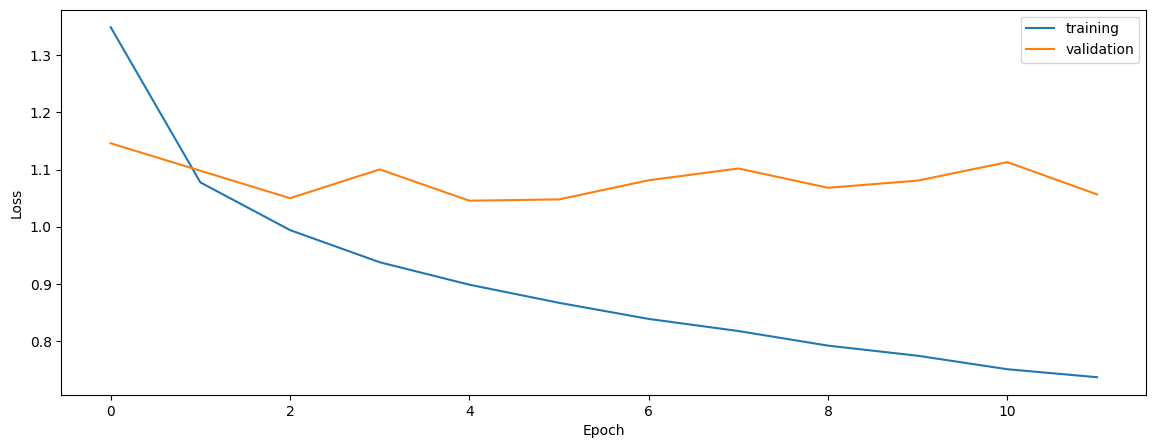

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_coords_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 831)
(1068345, 1)
validation
(123115, 831)
(123115, 1)
test
(152076, 831)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 831)]             0         


 dense_5 (Dense)             (None, 1024)              851968    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/107 [..............................] - ETA: 2:34 - loss: 0.2921 - STD: 1.1692e-04 - MAE: 0.5077

  4/107 [>.............................] - ETA: 2s - loss: 0.2458 - STD: 4.0362e-04 - MAE: 0.4504  

  7/107 [>.............................] - ETA: 2s - loss: 0.2390 - STD: 3.9130e-04 - MAE: 0.4385

 10/107 [=>............................] - ETA: 2s - loss: 0.2333 - STD: 4.5680e-04 - MAE: 0.4430

 13/107 [==>...........................] - ETA: 2s - loss: 0.2311 - STD: 5.2566e-04 - MAE: 0.4477

 16/107 [===>..........................] - ETA: 2s - loss: 0.2285 - STD: 5.9438e-04 - MAE: 0.4471

 19/107 [====>.........................] - ETA: 1s - loss: 0.2272 - STD: 6.5703e-04 - MAE: 0.4448

 21/107 [====>.........................] - ETA: 5s - loss: 0.2263 - STD: 7.0102e-04 - MAE: 0.4434

 24/107 [=====>........................] - ETA: 4s - loss: 0.2252 - STD: 7.7966e-04 - MAE: 0.4430

 27/107 [======>.......................] - ETA: 4s - loss: 0.2243 - STD: 8.6970e-04 - MAE: 0.4438

 30/107 [=======>......................] - ETA: 3s - loss: 0.2236 - STD: 9.7243e-04 - MAE: 0.4445

 33/107 [========>.....................] - ETA: 3s - loss: 0.2230 - STD: 0.0011 - MAE: 0.4443    

 36/107 [=========>....................] - ETA: 3s - loss: 0.2225 - STD: 0.0012 - MAE: 0.4438

 39/107 [=========>....................] - ETA: 3s - loss: 0.2221 - STD: 0.0014 - MAE: 0.4436

 42/107 [==========>...................] - ETA: 2s - loss: 0.2216 - STD: 0.0016 - MAE: 0.4437

 45/107 [===========>..................] - ETA: 2s - loss: 0.2212 - STD: 0.0019 - MAE: 0.4438

 48/107 [============>.................] - ETA: 2s - loss: 0.2209 - STD: 0.0022 - MAE: 0.4437

 51/107 [=============>................] - ETA: 2s - loss: 0.2205 - STD: 0.0027 - MAE: 0.4435

 54/107 [==============>...............] - ETA: 2s - loss: 0.2202 - STD: 0.0034 - MAE: 0.4432

 57/107 [==============>...............] - ETA: 1s - loss: 0.2197 - STD: 0.0042 - MAE: 0.4429

 60/107 [===============>..............] - ETA: 1s - loss: 0.2193 - STD: 0.0055 - MAE: 0.4427

 63/107 [================>.............] - ETA: 1s - loss: 0.2188 - STD: 0.0072 - MAE: 0.4422

 66/107 [=================>............] - ETA: 1s - loss: 0.2182 - STD: 0.0096 - MAE: 0.4414

 69/107 [==================>...........] - ETA: 1s - loss: 0.2174 - STD: 0.0127 - MAE: 0.4404

 72/107 [===================>..........] - ETA: 1s - loss: 0.2167 - STD: 0.0166 - MAE: 0.4392

 75/107 [====================>.........] - ETA: 1s - loss: 0.2159 - STD: 0.0207 - MAE: 0.4378

 78/107 [====================>.........] - ETA: 0s - loss: 0.2151 - STD: 0.0249 - MAE: 0.4364

 81/107 [=====================>........] - ETA: 0s - loss: 0.2142 - STD: 0.0287 - MAE: 0.4350

 84/107 [======================>.......] - ETA: 0s - loss: 0.2134 - STD: 0.0327 - MAE: 0.4336

 87/107 [=======================>......] - ETA: 0s - loss: 0.2126 - STD: 0.0365 - MAE: 0.4322

 90/107 [========================>.....] - ETA: 0s - loss: 0.2119 - STD: 0.0405 - MAE: 0.4308

 93/107 [=========================>....] - ETA: 0s - loss: 0.2111 - STD: 0.0442 - MAE: 0.4293

 96/107 [=========================>....] - ETA: 0s - loss: 0.2103 - STD: 0.0478 - MAE: 0.4279

 99/107 [==========================>...] - ETA: 0s - loss: 0.2094 - STD: 0.0514 - MAE: 0.4265

102/107 [===========================>..] - ETA: 0s - loss: 0.2085 - STD: 0.0549 - MAE: 0.4250

105/107 [============================>.] - ETA: 0s - loss: 0.2076 - STD: 0.0584 - MAE: 0.4235

107/107 [==============================] - 5s 38ms/step - loss: 0.2070 - STD: 0.0607 - MAE: 0.4224 - val_loss: 0.1674 - val_STD: 0.1738 - val_MAE: 0.3590


Epoch 2/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1769 - STD: 0.2001 - MAE: 0.3697

  4/107 [>.............................] - ETA: 2s - loss: 0.1736 - STD: 0.2002 - MAE: 0.3605

  7/107 [>.............................] - ETA: 2s - loss: 0.1740 - STD: 0.2050 - MAE: 0.3593

 10/107 [=>............................] - ETA: 2s - loss: 0.1738 - STD: 0.2078 - MAE: 0.3574

 13/107 [==>...........................] - ETA: 2s - loss: 0.1739 - STD: 0.2085 - MAE: 0.3568

 16/107 [===>..........................] - ETA: 2s - loss: 0.1737 - STD: 0.2075 - MAE: 0.3567

 19/107 [====>.........................] - ETA: 1s - loss: 0.1734 - STD: 0.2065 - MAE: 0.3572

 22/107 [=====>........................] - ETA: 1s - loss: 0.1730 - STD: 0.2051 - MAE: 0.3574

 25/107 [======>.......................] - ETA: 1s - loss: 0.1727 - STD: 0.2044 - MAE: 0.3573

 28/107 [======>.......................] - ETA: 1s - loss: 0.1724 - STD: 0.2048 - MAE: 0.3570

 31/107 [=======>......................] - ETA: 1s - loss: 0.1724 - STD: 0.2055 - MAE: 0.3567

 34/107 [========>.....................] - ETA: 1s - loss: 0.1722 - STD: 0.2061 - MAE: 0.3565

 37/107 [=========>....................] - ETA: 1s - loss: 0.1722 - STD: 0.2062 - MAE: 0.3565

 40/107 [==========>...................] - ETA: 1s - loss: 0.1719 - STD: 0.2064 - MAE: 0.3561

 43/107 [===========>..................] - ETA: 1s - loss: 0.1717 - STD: 0.2071 - MAE: 0.3557

 46/107 [===========>..................] - ETA: 1s - loss: 0.1715 - STD: 0.2078 - MAE: 0.3552

 49/107 [============>.................] - ETA: 1s - loss: 0.1712 - STD: 0.2086 - MAE: 0.3547

 52/107 [=============>................] - ETA: 1s - loss: 0.1711 - STD: 0.2090 - MAE: 0.3544

 55/107 [==============>...............] - ETA: 1s - loss: 0.1709 - STD: 0.2092 - MAE: 0.3540

 58/107 [===============>..............] - ETA: 1s - loss: 0.1708 - STD: 0.2092 - MAE: 0.3539

 61/107 [================>.............] - ETA: 1s - loss: 0.1707 - STD: 0.2093 - MAE: 0.3537

 64/107 [================>.............] - ETA: 0s - loss: 0.1706 - STD: 0.2096 - MAE: 0.3536

 67/107 [=================>............] - ETA: 0s - loss: 0.1706 - STD: 0.2098 - MAE: 0.3534

 70/107 [==================>...........] - ETA: 0s - loss: 0.1704 - STD: 0.2099 - MAE: 0.3532

 73/107 [===================>..........] - ETA: 0s - loss: 0.1704 - STD: 0.2101 - MAE: 0.3530

 76/107 [====================>.........] - ETA: 0s - loss: 0.1703 - STD: 0.2103 - MAE: 0.3528

 79/107 [=====================>........] - ETA: 0s - loss: 0.1702 - STD: 0.2106 - MAE: 0.3527

 82/107 [=====================>........] - ETA: 0s - loss: 0.1701 - STD: 0.2108 - MAE: 0.3525

 85/107 [======================>.......] - ETA: 0s - loss: 0.1700 - STD: 0.2110 - MAE: 0.3523

 88/107 [=======================>......] - ETA: 0s - loss: 0.1700 - STD: 0.2111 - MAE: 0.3522

 91/107 [========================>.....] - ETA: 0s - loss: 0.1700 - STD: 0.2113 - MAE: 0.3521

 94/107 [=========================>....] - ETA: 0s - loss: 0.1699 - STD: 0.2115 - MAE: 0.3520

 97/107 [==========================>...] - ETA: 0s - loss: 0.1698 - STD: 0.2117 - MAE: 0.3518

100/107 [===========================>..] - ETA: 0s - loss: 0.1697 - STD: 0.2119 - MAE: 0.3517

103/107 [===========================>..] - ETA: 0s - loss: 0.1697 - STD: 0.2122 - MAE: 0.3516

106/107 [============================>.] - ETA: 0s - loss: 0.1697 - STD: 0.2123 - MAE: 0.3516

107/107 [==============================] - 3s 25ms/step - loss: 0.1697 - STD: 0.2123 - MAE: 0.3516 - val_loss: 0.1593 - val_STD: 0.1789 - val_MAE: 0.3362


Epoch 3/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1685 - STD: 0.2123 - MAE: 0.3486

  4/107 [>.............................] - ETA: 2s - loss: 0.1674 - STD: 0.2152 - MAE: 0.3488

  7/107 [>.............................] - ETA: 2s - loss: 0.1669 - STD: 0.2161 - MAE: 0.3481

 10/107 [=>............................] - ETA: 2s - loss: 0.1670 - STD: 0.2180 - MAE: 0.3475

 13/107 [==>...........................] - ETA: 2s - loss: 0.1673 - STD: 0.2185 - MAE: 0.3471

 16/107 [===>..........................] - ETA: 2s - loss: 0.1677 - STD: 0.2185 - MAE: 0.3473

 19/107 [====>.........................] - ETA: 2s - loss: 0.1676 - STD: 0.2185 - MAE: 0.3473

 22/107 [=====>........................] - ETA: 1s - loss: 0.1676 - STD: 0.2181 - MAE: 0.3476

 25/107 [======>.......................] - ETA: 1s - loss: 0.1674 - STD: 0.2179 - MAE: 0.3474

 28/107 [======>.......................] - ETA: 1s - loss: 0.1672 - STD: 0.2185 - MAE: 0.3472

 31/107 [=======>......................] - ETA: 1s - loss: 0.1671 - STD: 0.2191 - MAE: 0.3468

 34/107 [========>.....................] - ETA: 1s - loss: 0.1669 - STD: 0.2197 - MAE: 0.3463

 37/107 [=========>....................] - ETA: 1s - loss: 0.1668 - STD: 0.2201 - MAE: 0.3461

 40/107 [==========>...................] - ETA: 1s - loss: 0.1668 - STD: 0.2201 - MAE: 0.3460

 43/107 [===========>..................] - ETA: 1s - loss: 0.1667 - STD: 0.2202 - MAE: 0.3459

 46/107 [===========>..................] - ETA: 1s - loss: 0.1668 - STD: 0.2203 - MAE: 0.3459

 49/107 [============>.................] - ETA: 1s - loss: 0.1667 - STD: 0.2206 - MAE: 0.3457

 52/107 [=============>................] - ETA: 1s - loss: 0.1667 - STD: 0.2209 - MAE: 0.3456

 55/107 [==============>...............] - ETA: 1s - loss: 0.1666 - STD: 0.2208 - MAE: 0.3455

 58/107 [===============>..............] - ETA: 1s - loss: 0.1665 - STD: 0.2206 - MAE: 0.3455

 61/107 [================>.............] - ETA: 1s - loss: 0.1665 - STD: 0.2207 - MAE: 0.3454

 64/107 [================>.............] - ETA: 0s - loss: 0.1664 - STD: 0.2209 - MAE: 0.3452

 67/107 [=================>............] - ETA: 0s - loss: 0.1663 - STD: 0.2211 - MAE: 0.3450

 70/107 [==================>...........] - ETA: 0s - loss: 0.1663 - STD: 0.2213 - MAE: 0.3450

 73/107 [===================>..........] - ETA: 0s - loss: 0.1663 - STD: 0.2214 - MAE: 0.3449

 76/107 [====================>.........] - ETA: 0s - loss: 0.1664 - STD: 0.2212 - MAE: 0.3450

 79/107 [=====================>........] - ETA: 0s - loss: 0.1663 - STD: 0.2212 - MAE: 0.3450

 82/107 [=====================>........] - ETA: 0s - loss: 0.1663 - STD: 0.2213 - MAE: 0.3449

 85/107 [======================>.......] - ETA: 0s - loss: 0.1662 - STD: 0.2215 - MAE: 0.3448

 88/107 [=======================>......] - ETA: 0s - loss: 0.1662 - STD: 0.2216 - MAE: 0.3447

 91/107 [========================>.....] - ETA: 0s - loss: 0.1662 - STD: 0.2217 - MAE: 0.3447

 94/107 [=========================>....] - ETA: 0s - loss: 0.1662 - STD: 0.2218 - MAE: 0.3446

 97/107 [==========================>...] - ETA: 0s - loss: 0.1663 - STD: 0.2218 - MAE: 0.3446

100/107 [===========================>..] - ETA: 0s - loss: 0.1663 - STD: 0.2218 - MAE: 0.3446

103/107 [===========================>..] - ETA: 0s - loss: 0.1662 - STD: 0.2217 - MAE: 0.3445

106/107 [============================>.] - ETA: 0s - loss: 0.1662 - STD: 0.2216 - MAE: 0.3445

107/107 [==============================] - 3s 25ms/step - loss: 0.1662 - STD: 0.2216 - MAE: 0.3445 - val_loss: 0.1554 - val_STD: 0.1880 - val_MAE: 0.3339


Epoch 4/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1628 - STD: 0.2235 - MAE: 0.3419

  4/107 [>.............................] - ETA: 2s - loss: 0.1628 - STD: 0.2232 - MAE: 0.3411

  7/107 [>.............................] - ETA: 2s - loss: 0.1638 - STD: 0.2257 - MAE: 0.3411

 10/107 [=>............................] - ETA: 2s - loss: 0.1641 - STD: 0.2274 - MAE: 0.3404

 13/107 [==>...........................] - ETA: 2s - loss: 0.1643 - STD: 0.2270 - MAE: 0.3404

 16/107 [===>..........................] - ETA: 2s - loss: 0.1642 - STD: 0.2271 - MAE: 0.3406

 19/107 [====>.........................] - ETA: 1s - loss: 0.1641 - STD: 0.2270 - MAE: 0.3407

 22/107 [=====>........................] - ETA: 1s - loss: 0.1640 - STD: 0.2272 - MAE: 0.3404

 25/107 [======>.......................] - ETA: 1s - loss: 0.1639 - STD: 0.2273 - MAE: 0.3403

 28/107 [======>.......................] - ETA: 1s - loss: 0.1640 - STD: 0.2270 - MAE: 0.3405

 31/107 [=======>......................] - ETA: 1s - loss: 0.1641 - STD: 0.2268 - MAE: 0.3407

 34/107 [========>.....................] - ETA: 1s - loss: 0.1641 - STD: 0.2271 - MAE: 0.3405

 37/107 [=========>....................] - ETA: 1s - loss: 0.1642 - STD: 0.2273 - MAE: 0.3404

 40/107 [==========>...................] - ETA: 1s - loss: 0.1642 - STD: 0.2272 - MAE: 0.3403

 43/107 [===========>..................] - ETA: 1s - loss: 0.1643 - STD: 0.2269 - MAE: 0.3404

 46/107 [===========>..................] - ETA: 1s - loss: 0.1644 - STD: 0.2266 - MAE: 0.3405

 49/107 [============>.................] - ETA: 1s - loss: 0.1643 - STD: 0.2262 - MAE: 0.3407

 52/107 [=============>................] - ETA: 1s - loss: 0.1644 - STD: 0.2260 - MAE: 0.3408

 55/107 [==============>...............] - ETA: 1s - loss: 0.1643 - STD: 0.2260 - MAE: 0.3407

 58/107 [===============>..............] - ETA: 1s - loss: 0.1642 - STD: 0.2263 - MAE: 0.3405

 61/107 [================>.............] - ETA: 1s - loss: 0.1641 - STD: 0.2265 - MAE: 0.3404

 64/107 [================>.............] - ETA: 0s - loss: 0.1641 - STD: 0.2265 - MAE: 0.3403

 67/107 [=================>............] - ETA: 0s - loss: 0.1640 - STD: 0.2266 - MAE: 0.3402

 70/107 [==================>...........] - ETA: 0s - loss: 0.1640 - STD: 0.2268 - MAE: 0.3401

 73/107 [===================>..........] - ETA: 0s - loss: 0.1640 - STD: 0.2269 - MAE: 0.3401

 76/107 [====================>.........] - ETA: 0s - loss: 0.1641 - STD: 0.2270 - MAE: 0.3402

 79/107 [=====================>........] - ETA: 0s - loss: 0.1641 - STD: 0.2268 - MAE: 0.3402

 82/107 [=====================>........] - ETA: 0s - loss: 0.1640 - STD: 0.2267 - MAE: 0.3402

 85/107 [======================>.......] - ETA: 0s - loss: 0.1640 - STD: 0.2268 - MAE: 0.3402

 88/107 [=======================>......] - ETA: 0s - loss: 0.1640 - STD: 0.2270 - MAE: 0.3401

 91/107 [========================>.....] - ETA: 0s - loss: 0.1639 - STD: 0.2270 - MAE: 0.3399

 94/107 [=========================>....] - ETA: 0s - loss: 0.1638 - STD: 0.2271 - MAE: 0.3398

 97/107 [==========================>...] - ETA: 0s - loss: 0.1637 - STD: 0.2274 - MAE: 0.3396

100/107 [===========================>..] - ETA: 0s - loss: 0.1637 - STD: 0.2277 - MAE: 0.3395

103/107 [===========================>..] - ETA: 0s - loss: 0.1637 - STD: 0.2278 - MAE: 0.3395

106/107 [============================>.] - ETA: 0s - loss: 0.1637 - STD: 0.2277 - MAE: 0.3395

107/107 [==============================] - 3s 25ms/step - loss: 0.1637 - STD: 0.2276 - MAE: 0.3395 - val_loss: 0.1523 - val_STD: 0.1990 - val_MAE: 0.3301


Epoch 5/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1607 - STD: 0.2333 - MAE: 0.3370

  4/107 [>.............................] - ETA: 2s - loss: 0.1635 - STD: 0.2310 - MAE: 0.3386

  7/107 [>.............................] - ETA: 2s - loss: 0.1624 - STD: 0.2308 - MAE: 0.3376

 10/107 [=>............................] - ETA: 2s - loss: 0.1626 - STD: 0.2295 - MAE: 0.3381

 13/107 [==>...........................] - ETA: 2s - loss: 0.1623 - STD: 0.2292 - MAE: 0.3377

 16/107 [===>..........................] - ETA: 2s - loss: 0.1624 - STD: 0.2305 - MAE: 0.3373

 19/107 [====>.........................] - ETA: 2s - loss: 0.1624 - STD: 0.2307 - MAE: 0.3373

 22/107 [=====>........................] - ETA: 1s - loss: 0.1623 - STD: 0.2306 - MAE: 0.3371

 25/107 [======>.......................] - ETA: 1s - loss: 0.1625 - STD: 0.2309 - MAE: 0.3372

 28/107 [======>.......................] - ETA: 1s - loss: 0.1624 - STD: 0.2310 - MAE: 0.3370

 31/107 [=======>......................] - ETA: 1s - loss: 0.1623 - STD: 0.2307 - MAE: 0.3370

 34/107 [========>.....................] - ETA: 1s - loss: 0.1622 - STD: 0.2310 - MAE: 0.3367

 37/107 [=========>....................] - ETA: 1s - loss: 0.1621 - STD: 0.2311 - MAE: 0.3365

 40/107 [==========>...................] - ETA: 1s - loss: 0.1620 - STD: 0.2312 - MAE: 0.3364

 43/107 [===========>..................] - ETA: 1s - loss: 0.1619 - STD: 0.2312 - MAE: 0.3362

 46/107 [===========>..................] - ETA: 1s - loss: 0.1617 - STD: 0.2314 - MAE: 0.3360

 49/107 [============>.................] - ETA: 1s - loss: 0.1616 - STD: 0.2317 - MAE: 0.3359

 52/107 [=============>................] - ETA: 1s - loss: 0.1617 - STD: 0.2318 - MAE: 0.3358

 55/107 [==============>...............] - ETA: 1s - loss: 0.1618 - STD: 0.2318 - MAE: 0.3357

 58/107 [===============>..............] - ETA: 1s - loss: 0.1621 - STD: 0.2317 - MAE: 0.3359

 61/107 [================>.............] - ETA: 1s - loss: 0.1626 - STD: 0.2315 - MAE: 0.3362

 64/107 [================>.............] - ETA: 0s - loss: 0.1630 - STD: 0.2311 - MAE: 0.3367

 67/107 [=================>............] - ETA: 0s - loss: 0.1632 - STD: 0.2301 - MAE: 0.3370

 70/107 [==================>...........] - ETA: 0s - loss: 0.1633 - STD: 0.2291 - MAE: 0.3375

 73/107 [===================>..........] - ETA: 0s - loss: 0.1633 - STD: 0.2285 - MAE: 0.3378

 76/107 [====================>.........] - ETA: 0s - loss: 0.1632 - STD: 0.2283 - MAE: 0.3378

 79/107 [=====================>........] - ETA: 0s - loss: 0.1631 - STD: 0.2285 - MAE: 0.3377

 82/107 [=====================>........] - ETA: 0s - loss: 0.1630 - STD: 0.2288 - MAE: 0.3375

 85/107 [======================>.......] - ETA: 0s - loss: 0.1629 - STD: 0.2291 - MAE: 0.3373

 88/107 [=======================>......] - ETA: 0s - loss: 0.1629 - STD: 0.2293 - MAE: 0.3372

 91/107 [========================>.....] - ETA: 0s - loss: 0.1628 - STD: 0.2295 - MAE: 0.3370

 94/107 [=========================>....] - ETA: 0s - loss: 0.1627 - STD: 0.2297 - MAE: 0.3369

 97/107 [==========================>...] - ETA: 0s - loss: 0.1627 - STD: 0.2298 - MAE: 0.3369

100/107 [===========================>..] - ETA: 0s - loss: 0.1627 - STD: 0.2297 - MAE: 0.3369

103/107 [===========================>..] - ETA: 0s - loss: 0.1626 - STD: 0.2296 - MAE: 0.3368

106/107 [============================>.] - ETA: 0s - loss: 0.1626 - STD: 0.2297 - MAE: 0.3368

107/107 [==============================] - 3s 25ms/step - loss: 0.1627 - STD: 0.2298 - MAE: 0.3369 - val_loss: 0.1513 - val_STD: 0.1977 - val_MAE: 0.3223


Epoch 6/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1602 - STD: 0.2333 - MAE: 0.3342

  4/107 [>.............................] - ETA: 2s - loss: 0.1613 - STD: 0.2317 - MAE: 0.3355

  7/107 [>.............................] - ETA: 2s - loss: 0.1608 - STD: 0.2313 - MAE: 0.3351

 10/107 [=>............................] - ETA: 2s - loss: 0.1607 - STD: 0.2320 - MAE: 0.3348

 13/107 [==>...........................] - ETA: 2s - loss: 0.1604 - STD: 0.2331 - MAE: 0.3340

 16/107 [===>..........................] - ETA: 2s - loss: 0.1601 - STD: 0.2336 - MAE: 0.3336

 19/107 [====>.........................] - ETA: 1s - loss: 0.1600 - STD: 0.2339 - MAE: 0.3333

 22/107 [=====>........................] - ETA: 1s - loss: 0.1598 - STD: 0.2347 - MAE: 0.3330

 25/107 [======>.......................] - ETA: 1s - loss: 0.1599 - STD: 0.2354 - MAE: 0.3327

 28/107 [======>.......................] - ETA: 1s - loss: 0.1601 - STD: 0.2351 - MAE: 0.3331

 31/107 [=======>......................] - ETA: 1s - loss: 0.1601 - STD: 0.2345 - MAE: 0.3332

 34/107 [========>.....................] - ETA: 1s - loss: 0.1601 - STD: 0.2345 - MAE: 0.3330

 37/107 [=========>....................] - ETA: 1s - loss: 0.1600 - STD: 0.2349 - MAE: 0.3327

 40/107 [==========>...................] - ETA: 1s - loss: 0.1600 - STD: 0.2351 - MAE: 0.3326

 43/107 [===========>..................] - ETA: 1s - loss: 0.1600 - STD: 0.2351 - MAE: 0.3327

 46/107 [===========>..................] - ETA: 1s - loss: 0.1600 - STD: 0.2349 - MAE: 0.3327

 49/107 [============>.................] - ETA: 1s - loss: 0.1601 - STD: 0.2351 - MAE: 0.3328

 52/107 [=============>................] - ETA: 1s - loss: 0.1601 - STD: 0.2353 - MAE: 0.3327

 55/107 [==============>...............] - ETA: 1s - loss: 0.1602 - STD: 0.2353 - MAE: 0.3328

 58/107 [===============>..............] - ETA: 1s - loss: 0.1602 - STD: 0.2348 - MAE: 0.3330

 61/107 [================>.............] - ETA: 1s - loss: 0.1602 - STD: 0.2347 - MAE: 0.3331

 64/107 [================>.............] - ETA: 0s - loss: 0.1602 - STD: 0.2349 - MAE: 0.3330

 67/107 [=================>............] - ETA: 0s - loss: 0.1602 - STD: 0.2351 - MAE: 0.3328

 70/107 [==================>...........] - ETA: 0s - loss: 0.1601 - STD: 0.2351 - MAE: 0.3327

 73/107 [===================>..........] - ETA: 0s - loss: 0.1600 - STD: 0.2352 - MAE: 0.3326

 76/107 [====================>.........] - ETA: 0s - loss: 0.1601 - STD: 0.2351 - MAE: 0.3328

 79/107 [=====================>........] - ETA: 0s - loss: 0.1601 - STD: 0.2352 - MAE: 0.3327

 82/107 [=====================>........] - ETA: 0s - loss: 0.1600 - STD: 0.2352 - MAE: 0.3327

 85/107 [======================>.......] - ETA: 0s - loss: 0.1600 - STD: 0.2352 - MAE: 0.3326

 88/107 [=======================>......] - ETA: 0s - loss: 0.1600 - STD: 0.2354 - MAE: 0.3325

 91/107 [========================>.....] - ETA: 0s - loss: 0.1600 - STD: 0.2354 - MAE: 0.3325

 94/107 [=========================>....] - ETA: 0s - loss: 0.1600 - STD: 0.2353 - MAE: 0.3325

 97/107 [==========================>...] - ETA: 0s - loss: 0.1599 - STD: 0.2356 - MAE: 0.3323

100/107 [===========================>..] - ETA: 0s - loss: 0.1599 - STD: 0.2357 - MAE: 0.3322

103/107 [===========================>..] - ETA: 0s - loss: 0.1598 - STD: 0.2357 - MAE: 0.3322

106/107 [============================>.] - ETA: 0s - loss: 0.1599 - STD: 0.2358 - MAE: 0.3322

107/107 [==============================] - 3s 25ms/step - loss: 0.1599 - STD: 0.2358 - MAE: 0.3322 - val_loss: 0.1595 - val_STD: 0.1828 - val_MAE: 0.3170


Epoch 7/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1685 - STD: 0.2188 - MAE: 0.3338

  4/107 [>.............................] - ETA: 2s - loss: 0.1630 - STD: 0.2281 - MAE: 0.3339

  7/107 [>.............................] - ETA: 2s - loss: 0.1614 - STD: 0.2310 - MAE: 0.3334

 10/107 [=>............................] - ETA: 2s - loss: 0.1612 - STD: 0.2309 - MAE: 0.3340

 13/107 [==>...........................] - ETA: 2s - loss: 0.1610 - STD: 0.2313 - MAE: 0.3338

 16/107 [===>..........................] - ETA: 2s - loss: 0.1610 - STD: 0.2326 - MAE: 0.3335

 19/107 [====>.........................] - ETA: 1s - loss: 0.1609 - STD: 0.2329 - MAE: 0.3335

 22/107 [=====>........................] - ETA: 1s - loss: 0.1606 - STD: 0.2328 - MAE: 0.3332

 25/107 [======>.......................] - ETA: 1s - loss: 0.1603 - STD: 0.2330 - MAE: 0.3328

 28/107 [======>.......................] - ETA: 1s - loss: 0.1599 - STD: 0.2335 - MAE: 0.3323

 31/107 [=======>......................] - ETA: 1s - loss: 0.1598 - STD: 0.2341 - MAE: 0.3319

 34/107 [========>.....................] - ETA: 1s - loss: 0.1599 - STD: 0.2347 - MAE: 0.3315

 37/107 [=========>....................] - ETA: 1s - loss: 0.1600 - STD: 0.2348 - MAE: 0.3315

 40/107 [==========>...................] - ETA: 1s - loss: 0.1601 - STD: 0.2346 - MAE: 0.3317

 43/107 [===========>..................] - ETA: 1s - loss: 0.1600 - STD: 0.2348 - MAE: 0.3317

 46/107 [===========>..................] - ETA: 1s - loss: 0.1599 - STD: 0.2352 - MAE: 0.3316

 49/107 [============>.................] - ETA: 1s - loss: 0.1600 - STD: 0.2354 - MAE: 0.3316

 52/107 [=============>................] - ETA: 1s - loss: 0.1599 - STD: 0.2353 - MAE: 0.3316

 55/107 [==============>...............] - ETA: 1s - loss: 0.1599 - STD: 0.2351 - MAE: 0.3316

 58/107 [===============>..............] - ETA: 1s - loss: 0.1598 - STD: 0.2352 - MAE: 0.3315

 61/107 [================>.............] - ETA: 1s - loss: 0.1597 - STD: 0.2355 - MAE: 0.3313

 64/107 [================>.............] - ETA: 0s - loss: 0.1595 - STD: 0.2356 - MAE: 0.3312

 67/107 [=================>............] - ETA: 0s - loss: 0.1595 - STD: 0.2358 - MAE: 0.3311

 70/107 [==================>...........] - ETA: 0s - loss: 0.1594 - STD: 0.2360 - MAE: 0.3309

 73/107 [===================>..........] - ETA: 0s - loss: 0.1593 - STD: 0.2363 - MAE: 0.3307

 76/107 [====================>.........] - ETA: 0s - loss: 0.1593 - STD: 0.2364 - MAE: 0.3307

 79/107 [=====================>........] - ETA: 0s - loss: 0.1591 - STD: 0.2365 - MAE: 0.3305

 82/107 [=====================>........] - ETA: 0s - loss: 0.1591 - STD: 0.2368 - MAE: 0.3305

 85/107 [======================>.......] - ETA: 0s - loss: 0.1590 - STD: 0.2370 - MAE: 0.3303

 88/107 [=======================>......] - ETA: 0s - loss: 0.1590 - STD: 0.2371 - MAE: 0.3302

 91/107 [========================>.....] - ETA: 0s - loss: 0.1589 - STD: 0.2372 - MAE: 0.3302

 94/107 [=========================>....] - ETA: 0s - loss: 0.1589 - STD: 0.2373 - MAE: 0.3301

 97/107 [==========================>...] - ETA: 0s - loss: 0.1589 - STD: 0.2373 - MAE: 0.3301

100/107 [===========================>..] - ETA: 0s - loss: 0.1589 - STD: 0.2374 - MAE: 0.3300

103/107 [===========================>..] - ETA: 0s - loss: 0.1589 - STD: 0.2375 - MAE: 0.3300

106/107 [============================>.] - ETA: 0s - loss: 0.1588 - STD: 0.2375 - MAE: 0.3299

107/107 [==============================] - 3s 25ms/step - loss: 0.1588 - STD: 0.2375 - MAE: 0.3299 - val_loss: 0.1496 - val_STD: 0.1986 - val_MAE: 0.3152


Epoch 8/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1593 - STD: 0.2333 - MAE: 0.3300

  4/107 [>.............................] - ETA: 2s - loss: 0.1593 - STD: 0.2393 - MAE: 0.3296

  7/107 [>.............................] - ETA: 2s - loss: 0.1582 - STD: 0.2397 - MAE: 0.3283

 10/107 [=>............................] - ETA: 2s - loss: 0.1582 - STD: 0.2407 - MAE: 0.3286

 13/107 [==>...........................] - ETA: 2s - loss: 0.1578 - STD: 0.2401 - MAE: 0.3285

 16/107 [===>..........................] - ETA: 2s - loss: 0.1581 - STD: 0.2404 - MAE: 0.3285

 19/107 [====>.........................] - ETA: 1s - loss: 0.1588 - STD: 0.2403 - MAE: 0.3285

 22/107 [=====>........................] - ETA: 1s - loss: 0.1601 - STD: 0.2395 - MAE: 0.3295

 25/107 [======>.......................] - ETA: 1s - loss: 0.1616 - STD: 0.2370 - MAE: 0.3305

 28/107 [======>.......................] - ETA: 1s - loss: 0.1619 - STD: 0.2356 - MAE: 0.3308

 31/107 [=======>......................] - ETA: 1s - loss: 0.1620 - STD: 0.2354 - MAE: 0.3314

 34/107 [========>.....................] - ETA: 1s - loss: 0.1621 - STD: 0.2347 - MAE: 0.3318

 37/107 [=========>....................] - ETA: 1s - loss: 0.1619 - STD: 0.2338 - MAE: 0.3317

 40/107 [==========>...................] - ETA: 1s - loss: 0.1620 - STD: 0.2335 - MAE: 0.3322

 43/107 [===========>..................] - ETA: 1s - loss: 0.1618 - STD: 0.2335 - MAE: 0.3323

 46/107 [===========>..................] - ETA: 1s - loss: 0.1617 - STD: 0.2334 - MAE: 0.3323

 49/107 [============>.................] - ETA: 1s - loss: 0.1616 - STD: 0.2331 - MAE: 0.3323

 52/107 [=============>................] - ETA: 1s - loss: 0.1614 - STD: 0.2336 - MAE: 0.3322

 55/107 [==============>...............] - ETA: 1s - loss: 0.1612 - STD: 0.2339 - MAE: 0.3320

 58/107 [===============>..............] - ETA: 1s - loss: 0.1610 - STD: 0.2341 - MAE: 0.3317

 61/107 [================>.............] - ETA: 1s - loss: 0.1608 - STD: 0.2343 - MAE: 0.3316

 64/107 [================>.............] - ETA: 0s - loss: 0.1605 - STD: 0.2345 - MAE: 0.3314

 67/107 [=================>............] - ETA: 0s - loss: 0.1604 - STD: 0.2349 - MAE: 0.3312

 70/107 [==================>...........] - ETA: 0s - loss: 0.1604 - STD: 0.2352 - MAE: 0.3310

 73/107 [===================>..........] - ETA: 0s - loss: 0.1602 - STD: 0.2353 - MAE: 0.3310

 76/107 [====================>.........] - ETA: 0s - loss: 0.1601 - STD: 0.2356 - MAE: 0.3308

 79/107 [=====================>........] - ETA: 0s - loss: 0.1600 - STD: 0.2360 - MAE: 0.3305

 82/107 [=====================>........] - ETA: 0s - loss: 0.1599 - STD: 0.2362 - MAE: 0.3303

 85/107 [======================>.......] - ETA: 0s - loss: 0.1597 - STD: 0.2363 - MAE: 0.3301

 88/107 [=======================>......] - ETA: 0s - loss: 0.1596 - STD: 0.2365 - MAE: 0.3301

 91/107 [========================>.....] - ETA: 0s - loss: 0.1595 - STD: 0.2366 - MAE: 0.3299

 94/107 [=========================>....] - ETA: 0s - loss: 0.1594 - STD: 0.2368 - MAE: 0.3298

 97/107 [==========================>...] - ETA: 0s - loss: 0.1594 - STD: 0.2370 - MAE: 0.3297

100/107 [===========================>..] - ETA: 0s - loss: 0.1593 - STD: 0.2372 - MAE: 0.3296

103/107 [===========================>..] - ETA: 0s - loss: 0.1592 - STD: 0.2373 - MAE: 0.3295

106/107 [============================>.] - ETA: 0s - loss: 0.1591 - STD: 0.2374 - MAE: 0.3294

107/107 [==============================] - 3s 25ms/step - loss: 0.1591 - STD: 0.2374 - MAE: 0.3294 - val_loss: 0.1468 - val_STD: 0.2050 - val_MAE: 0.3151


Epoch 9/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1548 - STD: 0.2444 - MAE: 0.3254

  4/107 [>.............................] - ETA: 2s - loss: 0.1562 - STD: 0.2426 - MAE: 0.3259

  7/107 [>.............................] - ETA: 2s - loss: 0.1558 - STD: 0.2424 - MAE: 0.3256

 10/107 [=>............................] - ETA: 2s - loss: 0.1563 - STD: 0.2419 - MAE: 0.3261

 13/107 [==>...........................] - ETA: 2s - loss: 0.1560 - STD: 0.2425 - MAE: 0.3253

 16/107 [===>..........................] - ETA: 2s - loss: 0.1566 - STD: 0.2436 - MAE: 0.3252

 19/107 [====>.........................] - ETA: 1s - loss: 0.1565 - STD: 0.2424 - MAE: 0.3256

 22/107 [=====>........................] - ETA: 1s - loss: 0.1566 - STD: 0.2418 - MAE: 0.3258

 25/107 [======>.......................] - ETA: 1s - loss: 0.1564 - STD: 0.2428 - MAE: 0.3251

 28/107 [======>.......................] - ETA: 1s - loss: 0.1564 - STD: 0.2430 - MAE: 0.3251

 31/107 [=======>......................] - ETA: 1s - loss: 0.1563 - STD: 0.2426 - MAE: 0.3251

 34/107 [========>.....................] - ETA: 1s - loss: 0.1563 - STD: 0.2426 - MAE: 0.3251

 37/107 [=========>....................] - ETA: 1s - loss: 0.1563 - STD: 0.2428 - MAE: 0.3252

 40/107 [==========>...................] - ETA: 1s - loss: 0.1563 - STD: 0.2427 - MAE: 0.3252

 43/107 [===========>..................] - ETA: 1s - loss: 0.1563 - STD: 0.2431 - MAE: 0.3250

 46/107 [===========>..................] - ETA: 1s - loss: 0.1564 - STD: 0.2435 - MAE: 0.3250

 49/107 [============>.................] - ETA: 1s - loss: 0.1563 - STD: 0.2433 - MAE: 0.3251

 52/107 [=============>................] - ETA: 1s - loss: 0.1563 - STD: 0.2432 - MAE: 0.3252

 55/107 [==============>...............] - ETA: 1s - loss: 0.1564 - STD: 0.2434 - MAE: 0.3252

 58/107 [===============>..............] - ETA: 1s - loss: 0.1563 - STD: 0.2433 - MAE: 0.3251

 61/107 [================>.............] - ETA: 1s - loss: 0.1563 - STD: 0.2435 - MAE: 0.3250

 64/107 [================>.............] - ETA: 0s - loss: 0.1562 - STD: 0.2436 - MAE: 0.3249

 67/107 [=================>............] - ETA: 0s - loss: 0.1562 - STD: 0.2436 - MAE: 0.3248

 70/107 [==================>...........] - ETA: 0s - loss: 0.1562 - STD: 0.2435 - MAE: 0.3249

 73/107 [===================>..........] - ETA: 0s - loss: 0.1562 - STD: 0.2434 - MAE: 0.3249

 76/107 [====================>.........] - ETA: 0s - loss: 0.1562 - STD: 0.2434 - MAE: 0.3249

 79/107 [=====================>........] - ETA: 0s - loss: 0.1560 - STD: 0.2435 - MAE: 0.3247

 82/107 [=====================>........] - ETA: 0s - loss: 0.1560 - STD: 0.2437 - MAE: 0.3246

 85/107 [======================>.......] - ETA: 0s - loss: 0.1560 - STD: 0.2439 - MAE: 0.3245

 88/107 [=======================>......] - ETA: 0s - loss: 0.1559 - STD: 0.2441 - MAE: 0.3244

 91/107 [========================>.....] - ETA: 0s - loss: 0.1559 - STD: 0.2442 - MAE: 0.3244

 94/107 [=========================>....] - ETA: 0s - loss: 0.1559 - STD: 0.2442 - MAE: 0.3244

 97/107 [==========================>...] - ETA: 0s - loss: 0.1558 - STD: 0.2443 - MAE: 0.3243

100/107 [===========================>..] - ETA: 0s - loss: 0.1558 - STD: 0.2443 - MAE: 0.3243

103/107 [===========================>..] - ETA: 0s - loss: 0.1558 - STD: 0.2444 - MAE: 0.3242

106/107 [============================>.] - ETA: 0s - loss: 0.1558 - STD: 0.2445 - MAE: 0.3241

107/107 [==============================] - 3s 25ms/step - loss: 0.1558 - STD: 0.2446 - MAE: 0.3241 - val_loss: 0.1462 - val_STD: 0.2104 - val_MAE: 0.3176


Epoch 10/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1574 - STD: 0.2449 - MAE: 0.3297

  4/107 [>.............................] - ETA: 2s - loss: 0.1575 - STD: 0.2408 - MAE: 0.3273

  7/107 [>.............................] - ETA: 2s - loss: 0.1566 - STD: 0.2433 - MAE: 0.3253

 10/107 [=>............................] - ETA: 2s - loss: 0.1557 - STD: 0.2439 - MAE: 0.3241

 13/107 [==>...........................] - ETA: 2s - loss: 0.1554 - STD: 0.2446 - MAE: 0.3236

 16/107 [===>..........................] - ETA: 2s - loss: 0.1555 - STD: 0.2457 - MAE: 0.3236

 19/107 [====>.........................] - ETA: 1s - loss: 0.1551 - STD: 0.2454 - MAE: 0.3232

 22/107 [=====>........................] - ETA: 1s - loss: 0.1550 - STD: 0.2453 - MAE: 0.3230

 25/107 [======>.......................] - ETA: 1s - loss: 0.1548 - STD: 0.2465 - MAE: 0.3222

 28/107 [======>.......................] - ETA: 1s - loss: 0.1548 - STD: 0.2469 - MAE: 0.3221

 31/107 [=======>......................] - ETA: 1s - loss: 0.1552 - STD: 0.2466 - MAE: 0.3227

 34/107 [========>.....................] - ETA: 1s - loss: 0.1553 - STD: 0.2471 - MAE: 0.3225

 37/107 [=========>....................] - ETA: 1s - loss: 0.1556 - STD: 0.2465 - MAE: 0.3228

 40/107 [==========>...................] - ETA: 1s - loss: 0.1560 - STD: 0.2459 - MAE: 0.3234

 43/107 [===========>..................] - ETA: 1s - loss: 0.1567 - STD: 0.2454 - MAE: 0.3238

 46/107 [===========>..................] - ETA: 1s - loss: 0.1573 - STD: 0.2447 - MAE: 0.3242

 49/107 [============>.................] - ETA: 1s - loss: 0.1575 - STD: 0.2437 - MAE: 0.3245

 52/107 [=============>................] - ETA: 1s - loss: 0.1578 - STD: 0.2430 - MAE: 0.3251

 55/107 [==============>...............] - ETA: 1s - loss: 0.1579 - STD: 0.2429 - MAE: 0.3253

 58/107 [===============>..............] - ETA: 1s - loss: 0.1579 - STD: 0.2425 - MAE: 0.3254

 61/107 [================>.............] - ETA: 1s - loss: 0.1578 - STD: 0.2421 - MAE: 0.3255

 64/107 [================>.............] - ETA: 0s - loss: 0.1578 - STD: 0.2419 - MAE: 0.3257

 67/107 [=================>............] - ETA: 0s - loss: 0.1576 - STD: 0.2418 - MAE: 0.3257

 70/107 [==================>...........] - ETA: 0s - loss: 0.1575 - STD: 0.2419 - MAE: 0.3255

 73/107 [===================>..........] - ETA: 0s - loss: 0.1574 - STD: 0.2420 - MAE: 0.3255

 76/107 [====================>.........] - ETA: 0s - loss: 0.1574 - STD: 0.2421 - MAE: 0.3255

 79/107 [=====================>........] - ETA: 0s - loss: 0.1573 - STD: 0.2421 - MAE: 0.3254

 82/107 [=====================>........] - ETA: 0s - loss: 0.1572 - STD: 0.2423 - MAE: 0.3254

 85/107 [======================>.......] - ETA: 0s - loss: 0.1571 - STD: 0.2423 - MAE: 0.3252

 88/107 [=======================>......] - ETA: 0s - loss: 0.1569 - STD: 0.2423 - MAE: 0.3251

 91/107 [========================>.....] - ETA: 0s - loss: 0.1568 - STD: 0.2425 - MAE: 0.3249

 94/107 [=========================>....] - ETA: 0s - loss: 0.1567 - STD: 0.2428 - MAE: 0.3247

 97/107 [==========================>...] - ETA: 0s - loss: 0.1567 - STD: 0.2430 - MAE: 0.3246

100/107 [===========================>..] - ETA: 0s - loss: 0.1566 - STD: 0.2432 - MAE: 0.3245

103/107 [===========================>..] - ETA: 0s - loss: 0.1566 - STD: 0.2433 - MAE: 0.3244

106/107 [============================>.] - ETA: 0s - loss: 0.1565 - STD: 0.2435 - MAE: 0.3243

107/107 [==============================] - 3s 25ms/step - loss: 0.1565 - STD: 0.2435 - MAE: 0.3243 - val_loss: 0.1496 - val_STD: 0.2002 - val_MAE: 0.3075


Epoch 11/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1557 - STD: 0.2456 - MAE: 0.3178

  4/107 [>.............................] - ETA: 2s - loss: 0.1562 - STD: 0.2450 - MAE: 0.3226

  7/107 [>.............................] - ETA: 2s - loss: 0.1547 - STD: 0.2442 - MAE: 0.3221

 10/107 [=>............................] - ETA: 2s - loss: 0.1551 - STD: 0.2453 - MAE: 0.3220

 13/107 [==>...........................] - ETA: 2s - loss: 0.1553 - STD: 0.2447 - MAE: 0.3225

 16/107 [===>..........................] - ETA: 2s - loss: 0.1554 - STD: 0.2445 - MAE: 0.3226

 19/107 [====>.........................] - ETA: 2s - loss: 0.1554 - STD: 0.2450 - MAE: 0.3226

 22/107 [=====>........................] - ETA: 1s - loss: 0.1554 - STD: 0.2454 - MAE: 0.3225

 25/107 [======>.......................] - ETA: 1s - loss: 0.1552 - STD: 0.2453 - MAE: 0.3222

 28/107 [======>.......................] - ETA: 1s - loss: 0.1552 - STD: 0.2451 - MAE: 0.3224

 31/107 [=======>......................] - ETA: 1s - loss: 0.1552 - STD: 0.2450 - MAE: 0.3224

 34/107 [========>.....................] - ETA: 1s - loss: 0.1548 - STD: 0.2457 - MAE: 0.3220

 37/107 [=========>....................] - ETA: 1s - loss: 0.1547 - STD: 0.2461 - MAE: 0.3217

 40/107 [==========>...................] - ETA: 1s - loss: 0.1547 - STD: 0.2461 - MAE: 0.3218

 43/107 [===========>..................] - ETA: 1s - loss: 0.1546 - STD: 0.2463 - MAE: 0.3217

 46/107 [===========>..................] - ETA: 1s - loss: 0.1546 - STD: 0.2467 - MAE: 0.3216

 49/107 [============>.................] - ETA: 1s - loss: 0.1547 - STD: 0.2464 - MAE: 0.3217

 52/107 [=============>................] - ETA: 1s - loss: 0.1547 - STD: 0.2466 - MAE: 0.3216

 55/107 [==============>...............] - ETA: 1s - loss: 0.1546 - STD: 0.2470 - MAE: 0.3214

 58/107 [===============>..............] - ETA: 1s - loss: 0.1545 - STD: 0.2469 - MAE: 0.3213

 61/107 [================>.............] - ETA: 1s - loss: 0.1544 - STD: 0.2467 - MAE: 0.3213

 64/107 [================>.............] - ETA: 0s - loss: 0.1543 - STD: 0.2470 - MAE: 0.3211

 67/107 [=================>............] - ETA: 0s - loss: 0.1542 - STD: 0.2473 - MAE: 0.3209

 70/107 [==================>...........] - ETA: 0s - loss: 0.1542 - STD: 0.2474 - MAE: 0.3209

 73/107 [===================>..........] - ETA: 0s - loss: 0.1542 - STD: 0.2475 - MAE: 0.3209

 76/107 [====================>.........] - ETA: 0s - loss: 0.1542 - STD: 0.2476 - MAE: 0.3209

 79/107 [=====================>........] - ETA: 0s - loss: 0.1542 - STD: 0.2476 - MAE: 0.3209

 82/107 [=====================>........] - ETA: 0s - loss: 0.1543 - STD: 0.2476 - MAE: 0.3210

 85/107 [======================>.......] - ETA: 0s - loss: 0.1544 - STD: 0.2478 - MAE: 0.3209

 88/107 [=======================>......] - ETA: 0s - loss: 0.1545 - STD: 0.2477 - MAE: 0.3210

 91/107 [========================>.....] - ETA: 0s - loss: 0.1546 - STD: 0.2475 - MAE: 0.3211

 94/107 [=========================>....] - ETA: 0s - loss: 0.1546 - STD: 0.2474 - MAE: 0.3212

 97/107 [==========================>...] - ETA: 0s - loss: 0.1547 - STD: 0.2473 - MAE: 0.3212

100/107 [===========================>..] - ETA: 0s - loss: 0.1546 - STD: 0.2472 - MAE: 0.3212

103/107 [===========================>..] - ETA: 0s - loss: 0.1546 - STD: 0.2471 - MAE: 0.3213

106/107 [============================>.] - ETA: 0s - loss: 0.1547 - STD: 0.2471 - MAE: 0.3213

107/107 [==============================] - 3s 25ms/step - loss: 0.1546 - STD: 0.2470 - MAE: 0.3213 - val_loss: 0.1444 - val_STD: 0.2106 - val_MAE: 0.3149


Epoch 12/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1536 - STD: 0.2483 - MAE: 0.3240

  4/107 [>.............................] - ETA: 2s - loss: 0.1516 - STD: 0.2472 - MAE: 0.3192

  7/107 [>.............................] - ETA: 2s - loss: 0.1516 - STD: 0.2498 - MAE: 0.3178

 10/107 [=>............................] - ETA: 2s - loss: 0.1525 - STD: 0.2485 - MAE: 0.3192

 13/107 [==>...........................] - ETA: 2s - loss: 0.1528 - STD: 0.2479 - MAE: 0.3197

 16/107 [===>..........................] - ETA: 2s - loss: 0.1531 - STD: 0.2494 - MAE: 0.3196

 19/107 [====>.........................] - ETA: 1s - loss: 0.1533 - STD: 0.2493 - MAE: 0.3199

 22/107 [=====>........................] - ETA: 1s - loss: 0.1529 - STD: 0.2494 - MAE: 0.3196

 25/107 [======>.......................] - ETA: 1s - loss: 0.1527 - STD: 0.2500 - MAE: 0.3189

 28/107 [======>.......................] - ETA: 1s - loss: 0.1527 - STD: 0.2499 - MAE: 0.3189

 31/107 [=======>......................] - ETA: 1s - loss: 0.1528 - STD: 0.2498 - MAE: 0.3192

 34/107 [========>.....................] - ETA: 1s - loss: 0.1530 - STD: 0.2498 - MAE: 0.3192

 37/107 [=========>....................] - ETA: 1s - loss: 0.1532 - STD: 0.2502 - MAE: 0.3192

 40/107 [==========>...................] - ETA: 1s - loss: 0.1536 - STD: 0.2500 - MAE: 0.3196

 43/107 [===========>..................] - ETA: 1s - loss: 0.1539 - STD: 0.2494 - MAE: 0.3199

 46/107 [===========>..................] - ETA: 1s - loss: 0.1548 - STD: 0.2490 - MAE: 0.3205

 49/107 [============>.................] - ETA: 1s - loss: 0.1549 - STD: 0.2482 - MAE: 0.3204

 52/107 [=============>................] - ETA: 1s - loss: 0.1555 - STD: 0.2472 - MAE: 0.3211

 55/107 [==============>...............] - ETA: 1s - loss: 0.1556 - STD: 0.2468 - MAE: 0.3215

 58/107 [===============>..............] - ETA: 1s - loss: 0.1556 - STD: 0.2464 - MAE: 0.3218

 61/107 [================>.............] - ETA: 1s - loss: 0.1556 - STD: 0.2460 - MAE: 0.3218

 64/107 [================>.............] - ETA: 0s - loss: 0.1556 - STD: 0.2458 - MAE: 0.3218

 67/107 [=================>............] - ETA: 0s - loss: 0.1555 - STD: 0.2457 - MAE: 0.3220

 70/107 [==================>...........] - ETA: 0s - loss: 0.1555 - STD: 0.2455 - MAE: 0.3221

 73/107 [===================>..........] - ETA: 0s - loss: 0.1554 - STD: 0.2455 - MAE: 0.3220

 76/107 [====================>.........] - ETA: 0s - loss: 0.1553 - STD: 0.2456 - MAE: 0.3219

 79/107 [=====================>........] - ETA: 0s - loss: 0.1552 - STD: 0.2457 - MAE: 0.3218

 82/107 [=====================>........] - ETA: 0s - loss: 0.1552 - STD: 0.2458 - MAE: 0.3218

 85/107 [======================>.......] - ETA: 0s - loss: 0.1550 - STD: 0.2461 - MAE: 0.3216

 88/107 [=======================>......] - ETA: 0s - loss: 0.1549 - STD: 0.2462 - MAE: 0.3214

 91/107 [========================>.....] - ETA: 0s - loss: 0.1548 - STD: 0.2464 - MAE: 0.3213

 94/107 [=========================>....] - ETA: 0s - loss: 0.1548 - STD: 0.2465 - MAE: 0.3213

 97/107 [==========================>...] - ETA: 0s - loss: 0.1548 - STD: 0.2466 - MAE: 0.3212

100/107 [===========================>..] - ETA: 0s - loss: 0.1547 - STD: 0.2467 - MAE: 0.3212

103/107 [===========================>..] - ETA: 0s - loss: 0.1547 - STD: 0.2467 - MAE: 0.3212

106/107 [============================>.] - ETA: 0s - loss: 0.1546 - STD: 0.2468 - MAE: 0.3211

107/107 [==============================] - 3s 25ms/step - loss: 0.1546 - STD: 0.2469 - MAE: 0.3210 - val_loss: 0.1431 - val_STD: 0.2156 - val_MAE: 0.3071


Epoch 13/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1503 - STD: 0.2581 - MAE: 0.3149

  4/107 [>.............................] - ETA: 2s - loss: 0.1514 - STD: 0.2556 - MAE: 0.3149

  7/107 [>.............................] - ETA: 2s - loss: 0.1525 - STD: 0.2538 - MAE: 0.3172

 10/107 [=>............................] - ETA: 2s - loss: 0.1526 - STD: 0.2517 - MAE: 0.3185

 13/107 [==>...........................] - ETA: 2s - loss: 0.1529 - STD: 0.2524 - MAE: 0.3187

 16/107 [===>..........................] - ETA: 2s - loss: 0.1526 - STD: 0.2518 - MAE: 0.3183

 19/107 [====>.........................] - ETA: 2s - loss: 0.1526 - STD: 0.2517 - MAE: 0.3185

 22/107 [=====>........................] - ETA: 1s - loss: 0.1525 - STD: 0.2517 - MAE: 0.3183

 25/107 [======>.......................] - ETA: 1s - loss: 0.1525 - STD: 0.2518 - MAE: 0.3180

 28/107 [======>.......................] - ETA: 1s - loss: 0.1528 - STD: 0.2514 - MAE: 0.3183

 31/107 [=======>......................] - ETA: 1s - loss: 0.1533 - STD: 0.2510 - MAE: 0.3188

 34/107 [========>.....................] - ETA: 1s - loss: 0.1537 - STD: 0.2508 - MAE: 0.3189

 37/107 [=========>....................] - ETA: 1s - loss: 0.1542 - STD: 0.2504 - MAE: 0.3193

 40/107 [==========>...................] - ETA: 1s - loss: 0.1544 - STD: 0.2496 - MAE: 0.3196

 43/107 [===========>..................] - ETA: 1s - loss: 0.1544 - STD: 0.2494 - MAE: 0.3198

 46/107 [===========>..................] - ETA: 1s - loss: 0.1544 - STD: 0.2492 - MAE: 0.3200

 49/107 [============>.................] - ETA: 1s - loss: 0.1542 - STD: 0.2491 - MAE: 0.3199

 52/107 [=============>................] - ETA: 1s - loss: 0.1541 - STD: 0.2493 - MAE: 0.3198

 55/107 [==============>...............] - ETA: 1s - loss: 0.1539 - STD: 0.2491 - MAE: 0.3197

 58/107 [===============>..............] - ETA: 1s - loss: 0.1538 - STD: 0.2490 - MAE: 0.3195

 61/107 [================>.............] - ETA: 1s - loss: 0.1538 - STD: 0.2493 - MAE: 0.3194

 64/107 [================>.............] - ETA: 0s - loss: 0.1536 - STD: 0.2494 - MAE: 0.3192

 67/107 [=================>............] - ETA: 0s - loss: 0.1535 - STD: 0.2495 - MAE: 0.3192

 70/107 [==================>...........] - ETA: 0s - loss: 0.1534 - STD: 0.2497 - MAE: 0.3190

 73/107 [===================>..........] - ETA: 0s - loss: 0.1534 - STD: 0.2498 - MAE: 0.3189

 76/107 [====================>.........] - ETA: 0s - loss: 0.1533 - STD: 0.2497 - MAE: 0.3188

 79/107 [=====================>........] - ETA: 0s - loss: 0.1532 - STD: 0.2499 - MAE: 0.3186

 82/107 [=====================>........] - ETA: 0s - loss: 0.1532 - STD: 0.2500 - MAE: 0.3185

 85/107 [======================>.......] - ETA: 0s - loss: 0.1533 - STD: 0.2499 - MAE: 0.3186

 88/107 [=======================>......] - ETA: 0s - loss: 0.1534 - STD: 0.2500 - MAE: 0.3186

 91/107 [========================>.....] - ETA: 0s - loss: 0.1535 - STD: 0.2500 - MAE: 0.3186

 94/107 [=========================>....] - ETA: 0s - loss: 0.1535 - STD: 0.2499 - MAE: 0.3187

 97/107 [==========================>...] - ETA: 0s - loss: 0.1534 - STD: 0.2499 - MAE: 0.3187

100/107 [===========================>..] - ETA: 0s - loss: 0.1534 - STD: 0.2500 - MAE: 0.3187

103/107 [===========================>..] - ETA: 0s - loss: 0.1533 - STD: 0.2498 - MAE: 0.3186

106/107 [============================>.] - ETA: 0s - loss: 0.1532 - STD: 0.2499 - MAE: 0.3186

107/107 [==============================] - 3s 25ms/step - loss: 0.1532 - STD: 0.2500 - MAE: 0.3185 - val_loss: 0.1422 - val_STD: 0.2131 - val_MAE: 0.3041


Epoch 14/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1501 - STD: 0.2543 - MAE: 0.3139

  4/107 [>.............................] - ETA: 2s - loss: 0.1516 - STD: 0.2501 - MAE: 0.3184

  7/107 [>.............................] - ETA: 2s - loss: 0.1523 - STD: 0.2502 - MAE: 0.3186

 10/107 [=>............................] - ETA: 2s - loss: 0.1519 - STD: 0.2518 - MAE: 0.3173

 13/107 [==>...........................] - ETA: 2s - loss: 0.1516 - STD: 0.2523 - MAE: 0.3169

 16/107 [===>..........................] - ETA: 2s - loss: 0.1516 - STD: 0.2527 - MAE: 0.3170

 19/107 [====>.........................] - ETA: 1s - loss: 0.1513 - STD: 0.2529 - MAE: 0.3164

 22/107 [=====>........................] - ETA: 1s - loss: 0.1514 - STD: 0.2533 - MAE: 0.3162

 25/107 [======>.......................] - ETA: 1s - loss: 0.1516 - STD: 0.2527 - MAE: 0.3166

 28/107 [======>.......................] - ETA: 1s - loss: 0.1517 - STD: 0.2524 - MAE: 0.3167

 31/107 [=======>......................] - ETA: 1s - loss: 0.1517 - STD: 0.2529 - MAE: 0.3164

 34/107 [========>.....................] - ETA: 1s - loss: 0.1517 - STD: 0.2527 - MAE: 0.3165

 37/107 [=========>....................] - ETA: 1s - loss: 0.1518 - STD: 0.2527 - MAE: 0.3165

 40/107 [==========>...................] - ETA: 1s - loss: 0.1517 - STD: 0.2528 - MAE: 0.3165

 43/107 [===========>..................] - ETA: 1s - loss: 0.1517 - STD: 0.2529 - MAE: 0.3164

 46/107 [===========>..................] - ETA: 1s - loss: 0.1516 - STD: 0.2529 - MAE: 0.3163

 49/107 [============>.................] - ETA: 1s - loss: 0.1515 - STD: 0.2529 - MAE: 0.3162

 52/107 [=============>................] - ETA: 1s - loss: 0.1515 - STD: 0.2531 - MAE: 0.3161

 55/107 [==============>...............] - ETA: 1s - loss: 0.1515 - STD: 0.2532 - MAE: 0.3161

 58/107 [===============>..............] - ETA: 1s - loss: 0.1514 - STD: 0.2533 - MAE: 0.3160

 61/107 [================>.............] - ETA: 1s - loss: 0.1513 - STD: 0.2534 - MAE: 0.3158

 64/107 [================>.............] - ETA: 0s - loss: 0.1514 - STD: 0.2535 - MAE: 0.3157

 67/107 [=================>............] - ETA: 0s - loss: 0.1514 - STD: 0.2534 - MAE: 0.3158

 70/107 [==================>...........] - ETA: 0s - loss: 0.1514 - STD: 0.2536 - MAE: 0.3157

 73/107 [===================>..........] - ETA: 0s - loss: 0.1515 - STD: 0.2536 - MAE: 0.3156

 76/107 [====================>.........] - ETA: 0s - loss: 0.1516 - STD: 0.2536 - MAE: 0.3157

 79/107 [=====================>........] - ETA: 0s - loss: 0.1517 - STD: 0.2535 - MAE: 0.3157

 82/107 [=====================>........] - ETA: 0s - loss: 0.1517 - STD: 0.2534 - MAE: 0.3158

 85/107 [======================>.......] - ETA: 0s - loss: 0.1517 - STD: 0.2533 - MAE: 0.3159

 88/107 [=======================>......] - ETA: 0s - loss: 0.1517 - STD: 0.2531 - MAE: 0.3159

 91/107 [========================>.....] - ETA: 0s - loss: 0.1516 - STD: 0.2532 - MAE: 0.3158

 94/107 [=========================>....] - ETA: 0s - loss: 0.1516 - STD: 0.2532 - MAE: 0.3157

 97/107 [==========================>...] - ETA: 0s - loss: 0.1517 - STD: 0.2530 - MAE: 0.3159

100/107 [===========================>..] - ETA: 0s - loss: 0.1516 - STD: 0.2531 - MAE: 0.3158

103/107 [===========================>..] - ETA: 0s - loss: 0.1516 - STD: 0.2532 - MAE: 0.3157

106/107 [============================>.] - ETA: 0s - loss: 0.1516 - STD: 0.2531 - MAE: 0.3158

107/107 [==============================] - 3s 25ms/step - loss: 0.1516 - STD: 0.2532 - MAE: 0.3158 - val_loss: 0.1433 - val_STD: 0.2114 - val_MAE: 0.2997


Epoch 15/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1496 - STD: 0.2543 - MAE: 0.3101

  4/107 [>.............................] - ETA: 2s - loss: 0.1514 - STD: 0.2547 - MAE: 0.3144

  7/107 [>.............................] - ETA: 2s - loss: 0.1510 - STD: 0.2545 - MAE: 0.3145

 10/107 [=>............................] - ETA: 2s - loss: 0.1510 - STD: 0.2562 - MAE: 0.3137

 13/107 [==>...........................] - ETA: 2s - loss: 0.1508 - STD: 0.2551 - MAE: 0.3142

 16/107 [===>..........................] - ETA: 2s - loss: 0.1505 - STD: 0.2547 - MAE: 0.3140

 19/107 [====>.........................] - ETA: 2s - loss: 0.1505 - STD: 0.2547 - MAE: 0.3138

 22/107 [=====>........................] - ETA: 1s - loss: 0.1505 - STD: 0.2542 - MAE: 0.3141

 25/107 [======>.......................] - ETA: 1s - loss: 0.1506 - STD: 0.2546 - MAE: 0.3140

 28/107 [======>.......................] - ETA: 1s - loss: 0.1506 - STD: 0.2547 - MAE: 0.3141

 31/107 [=======>......................] - ETA: 1s - loss: 0.1506 - STD: 0.2545 - MAE: 0.3142

 34/107 [========>.....................] - ETA: 1s - loss: 0.1506 - STD: 0.2546 - MAE: 0.3141

 37/107 [=========>....................] - ETA: 1s - loss: 0.1507 - STD: 0.2542 - MAE: 0.3144

 40/107 [==========>...................] - ETA: 1s - loss: 0.1506 - STD: 0.2543 - MAE: 0.3143

 43/107 [===========>..................] - ETA: 1s - loss: 0.1506 - STD: 0.2542 - MAE: 0.3143

 46/107 [===========>..................] - ETA: 1s - loss: 0.1507 - STD: 0.2542 - MAE: 0.3144

 49/107 [============>.................] - ETA: 1s - loss: 0.1507 - STD: 0.2542 - MAE: 0.3144

 52/107 [=============>................] - ETA: 1s - loss: 0.1506 - STD: 0.2544 - MAE: 0.3143

 55/107 [==============>...............] - ETA: 1s - loss: 0.1506 - STD: 0.2545 - MAE: 0.3143

 58/107 [===============>..............] - ETA: 1s - loss: 0.1506 - STD: 0.2547 - MAE: 0.3143

 61/107 [================>.............] - ETA: 1s - loss: 0.1508 - STD: 0.2547 - MAE: 0.3144

 64/107 [================>.............] - ETA: 0s - loss: 0.1507 - STD: 0.2547 - MAE: 0.3143

 67/107 [=================>............] - ETA: 0s - loss: 0.1506 - STD: 0.2548 - MAE: 0.3141

 70/107 [==================>...........] - ETA: 0s - loss: 0.1505 - STD: 0.2547 - MAE: 0.3142

 73/107 [===================>..........] - ETA: 0s - loss: 0.1506 - STD: 0.2550 - MAE: 0.3141

 76/107 [====================>.........] - ETA: 0s - loss: 0.1506 - STD: 0.2549 - MAE: 0.3141

 79/107 [=====================>........] - ETA: 0s - loss: 0.1506 - STD: 0.2550 - MAE: 0.3140

 82/107 [=====================>........] - ETA: 0s - loss: 0.1505 - STD: 0.2553 - MAE: 0.3138

 85/107 [======================>.......] - ETA: 0s - loss: 0.1505 - STD: 0.2552 - MAE: 0.3139

 88/107 [=======================>......] - ETA: 0s - loss: 0.1505 - STD: 0.2554 - MAE: 0.3138

 91/107 [========================>.....] - ETA: 0s - loss: 0.1504 - STD: 0.2554 - MAE: 0.3138

 94/107 [=========================>....] - ETA: 0s - loss: 0.1504 - STD: 0.2554 - MAE: 0.3138

 97/107 [==========================>...] - ETA: 0s - loss: 0.1504 - STD: 0.2556 - MAE: 0.3137

100/107 [===========================>..] - ETA: 0s - loss: 0.1503 - STD: 0.2556 - MAE: 0.3136

103/107 [===========================>..] - ETA: 0s - loss: 0.1503 - STD: 0.2557 - MAE: 0.3136

106/107 [============================>.] - ETA: 0s - loss: 0.1503 - STD: 0.2557 - MAE: 0.3136

107/107 [==============================] - 3s 25ms/step - loss: 0.1503 - STD: 0.2557 - MAE: 0.3136 - val_loss: 0.1417 - val_STD: 0.2164 - val_MAE: 0.2993


Epoch 16/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1494 - STD: 0.2606 - MAE: 0.3096

  4/107 [>.............................] - ETA: 2s - loss: 0.1497 - STD: 0.2586 - MAE: 0.3114

  7/107 [>.............................] - ETA: 2s - loss: 0.1486 - STD: 0.2566 - MAE: 0.3112

 10/107 [=>............................] - ETA: 2s - loss: 0.1483 - STD: 0.2573 - MAE: 0.3111

 13/107 [==>...........................] - ETA: 2s - loss: 0.1501 - STD: 0.2566 - MAE: 0.3120

 16/107 [===>..........................] - ETA: 2s - loss: 0.1503 - STD: 0.2565 - MAE: 0.3123

 19/107 [====>.........................] - ETA: 1s - loss: 0.1504 - STD: 0.2564 - MAE: 0.3124

 22/107 [=====>........................] - ETA: 1s - loss: 0.1503 - STD: 0.2564 - MAE: 0.3125

 25/107 [======>.......................] - ETA: 1s - loss: 0.1503 - STD: 0.2562 - MAE: 0.3127

 28/107 [======>.......................] - ETA: 1s - loss: 0.1504 - STD: 0.2566 - MAE: 0.3126

 31/107 [=======>......................] - ETA: 1s - loss: 0.1509 - STD: 0.2561 - MAE: 0.3131

 34/107 [========>.....................] - ETA: 1s - loss: 0.1511 - STD: 0.2557 - MAE: 0.3131

 37/107 [=========>....................] - ETA: 1s - loss: 0.1523 - STD: 0.2551 - MAE: 0.3138

 40/107 [==========>...................] - ETA: 1s - loss: 0.1528 - STD: 0.2552 - MAE: 0.3141

 43/107 [===========>..................] - ETA: 1s - loss: 0.1531 - STD: 0.2545 - MAE: 0.3148

 46/107 [===========>..................] - ETA: 1s - loss: 0.1533 - STD: 0.2541 - MAE: 0.3152

 49/107 [============>.................] - ETA: 1s - loss: 0.1532 - STD: 0.2531 - MAE: 0.3155

 52/107 [=============>................] - ETA: 1s - loss: 0.1531 - STD: 0.2532 - MAE: 0.3154

 55/107 [==============>...............] - ETA: 1s - loss: 0.1530 - STD: 0.2534 - MAE: 0.3153

 58/107 [===============>..............] - ETA: 1s - loss: 0.1529 - STD: 0.2528 - MAE: 0.3158

 61/107 [================>.............] - ETA: 1s - loss: 0.1528 - STD: 0.2530 - MAE: 0.3157

 64/107 [================>.............] - ETA: 0s - loss: 0.1527 - STD: 0.2533 - MAE: 0.3154

 67/107 [=================>............] - ETA: 0s - loss: 0.1526 - STD: 0.2528 - MAE: 0.3156

 70/107 [==================>...........] - ETA: 0s - loss: 0.1525 - STD: 0.2526 - MAE: 0.3157

 73/107 [===================>..........] - ETA: 0s - loss: 0.1524 - STD: 0.2529 - MAE: 0.3155

 76/107 [====================>.........] - ETA: 0s - loss: 0.1522 - STD: 0.2529 - MAE: 0.3155

 79/107 [=====================>........] - ETA: 0s - loss: 0.1522 - STD: 0.2528 - MAE: 0.3156

 82/107 [=====================>........] - ETA: 0s - loss: 0.1521 - STD: 0.2530 - MAE: 0.3154

 85/107 [======================>.......] - ETA: 0s - loss: 0.1520 - STD: 0.2531 - MAE: 0.3153

 88/107 [=======================>......] - ETA: 0s - loss: 0.1520 - STD: 0.2530 - MAE: 0.3153

 91/107 [========================>.....] - ETA: 0s - loss: 0.1520 - STD: 0.2532 - MAE: 0.3153

 94/107 [=========================>....] - ETA: 0s - loss: 0.1519 - STD: 0.2533 - MAE: 0.3151

 97/107 [==========================>...] - ETA: 0s - loss: 0.1518 - STD: 0.2535 - MAE: 0.3150

100/107 [===========================>..] - ETA: 0s - loss: 0.1517 - STD: 0.2536 - MAE: 0.3149

103/107 [===========================>..] - ETA: 0s - loss: 0.1516 - STD: 0.2535 - MAE: 0.3149

106/107 [============================>.] - ETA: 0s - loss: 0.1516 - STD: 0.2537 - MAE: 0.3148

107/107 [==============================] - 3s 25ms/step - loss: 0.1516 - STD: 0.2537 - MAE: 0.3148 - val_loss: 0.1416 - val_STD: 0.2151 - val_MAE: 0.2978


Epoch 17/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1475 - STD: 0.2576 - MAE: 0.3088

  4/107 [>.............................] - ETA: 2s - loss: 0.1483 - STD: 0.2555 - MAE: 0.3109

  7/107 [>.............................] - ETA: 2s - loss: 0.1496 - STD: 0.2546 - MAE: 0.3124

 10/107 [=>............................] - ETA: 2s - loss: 0.1502 - STD: 0.2546 - MAE: 0.3132

 13/107 [==>...........................] - ETA: 2s - loss: 0.1505 - STD: 0.2541 - MAE: 0.3133

 16/107 [===>..........................] - ETA: 2s - loss: 0.1515 - STD: 0.2539 - MAE: 0.3142

 19/107 [====>.........................] - ETA: 1s - loss: 0.1519 - STD: 0.2539 - MAE: 0.3145

 22/107 [=====>........................] - ETA: 1s - loss: 0.1520 - STD: 0.2537 - MAE: 0.3145

 25/107 [======>.......................] - ETA: 1s - loss: 0.1517 - STD: 0.2533 - MAE: 0.3144

 28/107 [======>.......................] - ETA: 1s - loss: 0.1517 - STD: 0.2538 - MAE: 0.3142

 31/107 [=======>......................] - ETA: 1s - loss: 0.1516 - STD: 0.2541 - MAE: 0.3142

 34/107 [========>.....................] - ETA: 1s - loss: 0.1514 - STD: 0.2540 - MAE: 0.3143

 37/107 [=========>....................] - ETA: 1s - loss: 0.1512 - STD: 0.2542 - MAE: 0.3142

 40/107 [==========>...................] - ETA: 1s - loss: 0.1510 - STD: 0.2543 - MAE: 0.3140

 43/107 [===========>..................] - ETA: 1s - loss: 0.1508 - STD: 0.2543 - MAE: 0.3139

 46/107 [===========>..................] - ETA: 1s - loss: 0.1507 - STD: 0.2545 - MAE: 0.3136

 49/107 [============>.................] - ETA: 1s - loss: 0.1507 - STD: 0.2546 - MAE: 0.3136

 52/107 [=============>................] - ETA: 1s - loss: 0.1507 - STD: 0.2545 - MAE: 0.3137

 55/107 [==============>...............] - ETA: 1s - loss: 0.1506 - STD: 0.2546 - MAE: 0.3136

 58/107 [===============>..............] - ETA: 1s - loss: 0.1505 - STD: 0.2547 - MAE: 0.3135

 61/107 [================>.............] - ETA: 1s - loss: 0.1504 - STD: 0.2547 - MAE: 0.3134

 64/107 [================>.............] - ETA: 0s - loss: 0.1504 - STD: 0.2548 - MAE: 0.3134

 67/107 [=================>............] - ETA: 0s - loss: 0.1504 - STD: 0.2550 - MAE: 0.3133

 70/107 [==================>...........] - ETA: 0s - loss: 0.1503 - STD: 0.2550 - MAE: 0.3133

 73/107 [===================>..........] - ETA: 0s - loss: 0.1502 - STD: 0.2550 - MAE: 0.3133

 76/107 [====================>.........] - ETA: 0s - loss: 0.1502 - STD: 0.2552 - MAE: 0.3132

 79/107 [=====================>........] - ETA: 0s - loss: 0.1501 - STD: 0.2553 - MAE: 0.3130

 82/107 [=====================>........] - ETA: 0s - loss: 0.1500 - STD: 0.2556 - MAE: 0.3129

 85/107 [======================>.......] - ETA: 0s - loss: 0.1499 - STD: 0.2557 - MAE: 0.3128

 88/107 [=======================>......] - ETA: 0s - loss: 0.1498 - STD: 0.2558 - MAE: 0.3126

 91/107 [========================>.....] - ETA: 0s - loss: 0.1497 - STD: 0.2559 - MAE: 0.3125

 94/107 [=========================>....] - ETA: 0s - loss: 0.1497 - STD: 0.2560 - MAE: 0.3125

 97/107 [==========================>...] - ETA: 0s - loss: 0.1497 - STD: 0.2561 - MAE: 0.3124

100/107 [===========================>..] - ETA: 0s - loss: 0.1498 - STD: 0.2563 - MAE: 0.3124

103/107 [===========================>..] - ETA: 0s - loss: 0.1500 - STD: 0.2564 - MAE: 0.3125

106/107 [============================>.] - ETA: 0s - loss: 0.1503 - STD: 0.2562 - MAE: 0.3126

107/107 [==============================] - 3s 25ms/step - loss: 0.1503 - STD: 0.2561 - MAE: 0.3126 - val_loss: 0.1603 - val_STD: 0.1904 - val_MAE: 0.3007


Epoch 18/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1606 - STD: 0.2440 - MAE: 0.3113

  4/107 [>.............................] - ETA: 2s - loss: 0.1565 - STD: 0.2527 - MAE: 0.3159

  7/107 [>.............................] - ETA: 2s - loss: 0.1547 - STD: 0.2530 - MAE: 0.3163

 10/107 [=>............................] - ETA: 2s - loss: 0.1545 - STD: 0.2511 - MAE: 0.3172

 13/107 [==>...........................] - ETA: 2s - loss: 0.1539 - STD: 0.2506 - MAE: 0.3162

 16/107 [===>..........................] - ETA: 2s - loss: 0.1539 - STD: 0.2509 - MAE: 0.3165

 19/107 [====>.........................] - ETA: 1s - loss: 0.1533 - STD: 0.2505 - MAE: 0.3169

 22/107 [=====>........................] - ETA: 1s - loss: 0.1530 - STD: 0.2515 - MAE: 0.3162

 25/107 [======>.......................] - ETA: 1s - loss: 0.1526 - STD: 0.2510 - MAE: 0.3163

 28/107 [======>.......................] - ETA: 1s - loss: 0.1522 - STD: 0.2508 - MAE: 0.3162

 31/107 [=======>......................] - ETA: 1s - loss: 0.1518 - STD: 0.2520 - MAE: 0.3154

 34/107 [========>.....................] - ETA: 1s - loss: 0.1515 - STD: 0.2519 - MAE: 0.3153

 37/107 [=========>....................] - ETA: 1s - loss: 0.1515 - STD: 0.2519 - MAE: 0.3152

 40/107 [==========>...................] - ETA: 1s - loss: 0.1512 - STD: 0.2525 - MAE: 0.3148

 43/107 [===========>..................] - ETA: 1s - loss: 0.1510 - STD: 0.2528 - MAE: 0.3146

 46/107 [===========>..................] - ETA: 1s - loss: 0.1507 - STD: 0.2530 - MAE: 0.3143

 49/107 [============>.................] - ETA: 1s - loss: 0.1506 - STD: 0.2532 - MAE: 0.3142

 52/107 [=============>................] - ETA: 1s - loss: 0.1504 - STD: 0.2535 - MAE: 0.3140

 55/107 [==============>...............] - ETA: 1s - loss: 0.1502 - STD: 0.2539 - MAE: 0.3135

 58/107 [===============>..............] - ETA: 1s - loss: 0.1501 - STD: 0.2542 - MAE: 0.3133

 61/107 [================>.............] - ETA: 1s - loss: 0.1501 - STD: 0.2543 - MAE: 0.3133

 64/107 [================>.............] - ETA: 0s - loss: 0.1499 - STD: 0.2545 - MAE: 0.3132

 67/107 [=================>............] - ETA: 0s - loss: 0.1498 - STD: 0.2549 - MAE: 0.3129

 70/107 [==================>...........] - ETA: 0s - loss: 0.1497 - STD: 0.2551 - MAE: 0.3128

 73/107 [===================>..........] - ETA: 0s - loss: 0.1497 - STD: 0.2552 - MAE: 0.3127

 76/107 [====================>.........] - ETA: 0s - loss: 0.1496 - STD: 0.2554 - MAE: 0.3124

 79/107 [=====================>........] - ETA: 0s - loss: 0.1495 - STD: 0.2556 - MAE: 0.3123

 82/107 [=====================>........] - ETA: 0s - loss: 0.1494 - STD: 0.2558 - MAE: 0.3122

 85/107 [======================>.......] - ETA: 0s - loss: 0.1494 - STD: 0.2559 - MAE: 0.3121

 88/107 [=======================>......] - ETA: 0s - loss: 0.1493 - STD: 0.2561 - MAE: 0.3119

 91/107 [========================>.....] - ETA: 0s - loss: 0.1492 - STD: 0.2562 - MAE: 0.3119

 94/107 [=========================>....] - ETA: 0s - loss: 0.1492 - STD: 0.2563 - MAE: 0.3118

 97/107 [==========================>...] - ETA: 0s - loss: 0.1491 - STD: 0.2564 - MAE: 0.3117

100/107 [===========================>..] - ETA: 0s - loss: 0.1491 - STD: 0.2566 - MAE: 0.3116

103/107 [===========================>..] - ETA: 0s - loss: 0.1491 - STD: 0.2566 - MAE: 0.3115

106/107 [============================>.] - ETA: 0s - loss: 0.1490 - STD: 0.2569 - MAE: 0.3114

107/107 [==============================] - 3s 25ms/step - loss: 0.1490 - STD: 0.2570 - MAE: 0.3113 - val_loss: 0.1397 - val_STD: 0.2243 - val_MAE: 0.3030


Epoch 19/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1478 - STD: 0.2640 - MAE: 0.3113

  4/107 [>.............................] - ETA: 2s - loss: 0.1491 - STD: 0.2595 - MAE: 0.3119

  7/107 [>.............................] - ETA: 2s - loss: 0.1477 - STD: 0.2596 - MAE: 0.3099

 10/107 [=>............................] - ETA: 2s - loss: 0.1468 - STD: 0.2616 - MAE: 0.3075

 13/107 [==>...........................] - ETA: 2s - loss: 0.1471 - STD: 0.2611 - MAE: 0.3079

 16/107 [===>..........................] - ETA: 2s - loss: 0.1476 - STD: 0.2617 - MAE: 0.3082

 19/107 [====>.........................] - ETA: 1s - loss: 0.1477 - STD: 0.2619 - MAE: 0.3084

 22/107 [=====>........................] - ETA: 1s - loss: 0.1476 - STD: 0.2611 - MAE: 0.3086

 25/107 [======>.......................] - ETA: 1s - loss: 0.1474 - STD: 0.2618 - MAE: 0.3081

 28/107 [======>.......................] - ETA: 1s - loss: 0.1476 - STD: 0.2609 - MAE: 0.3087

 31/107 [=======>......................] - ETA: 1s - loss: 0.1476 - STD: 0.2609 - MAE: 0.3086

 34/107 [========>.....................] - ETA: 1s - loss: 0.1477 - STD: 0.2609 - MAE: 0.3086

 37/107 [=========>....................] - ETA: 1s - loss: 0.1477 - STD: 0.2610 - MAE: 0.3085

 40/107 [==========>...................] - ETA: 1s - loss: 0.1477 - STD: 0.2611 - MAE: 0.3085

 43/107 [===========>..................] - ETA: 1s - loss: 0.1479 - STD: 0.2614 - MAE: 0.3086

 46/107 [===========>..................] - ETA: 1s - loss: 0.1480 - STD: 0.2611 - MAE: 0.3089

 49/107 [============>.................] - ETA: 1s - loss: 0.1481 - STD: 0.2611 - MAE: 0.3088

 52/107 [=============>................] - ETA: 1s - loss: 0.1482 - STD: 0.2613 - MAE: 0.3087

 55/107 [==============>...............] - ETA: 1s - loss: 0.1482 - STD: 0.2609 - MAE: 0.3089

 58/107 [===============>..............] - ETA: 1s - loss: 0.1481 - STD: 0.2609 - MAE: 0.3088

 61/107 [================>.............] - ETA: 1s - loss: 0.1481 - STD: 0.2611 - MAE: 0.3087

 64/107 [================>.............] - ETA: 0s - loss: 0.1481 - STD: 0.2608 - MAE: 0.3089

 67/107 [=================>............] - ETA: 0s - loss: 0.1481 - STD: 0.2608 - MAE: 0.3090

 70/107 [==================>...........] - ETA: 0s - loss: 0.1480 - STD: 0.2606 - MAE: 0.3090

 73/107 [===================>..........] - ETA: 0s - loss: 0.1480 - STD: 0.2605 - MAE: 0.3090

 76/107 [====================>.........] - ETA: 0s - loss: 0.1480 - STD: 0.2604 - MAE: 0.3090

 79/107 [=====================>........] - ETA: 0s - loss: 0.1479 - STD: 0.2604 - MAE: 0.3090

 82/107 [=====================>........] - ETA: 0s - loss: 0.1479 - STD: 0.2605 - MAE: 0.3090

 85/107 [======================>.......] - ETA: 0s - loss: 0.1478 - STD: 0.2605 - MAE: 0.3089

 88/107 [=======================>......] - ETA: 0s - loss: 0.1478 - STD: 0.2606 - MAE: 0.3088

 91/107 [========================>.....] - ETA: 0s - loss: 0.1477 - STD: 0.2606 - MAE: 0.3087

 94/107 [=========================>....] - ETA: 0s - loss: 0.1477 - STD: 0.2609 - MAE: 0.3086

 97/107 [==========================>...] - ETA: 0s - loss: 0.1476 - STD: 0.2609 - MAE: 0.3085

100/107 [===========================>..] - ETA: 0s - loss: 0.1477 - STD: 0.2612 - MAE: 0.3084

103/107 [===========================>..] - ETA: 0s - loss: 0.1477 - STD: 0.2612 - MAE: 0.3085

106/107 [============================>.] - ETA: 0s - loss: 0.1478 - STD: 0.2613 - MAE: 0.3085

107/107 [==============================] - 3s 25ms/step - loss: 0.1478 - STD: 0.2612 - MAE: 0.3084 - val_loss: 0.1430 - val_STD: 0.2161 - val_MAE: 0.2930


Epoch 20/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1461 - STD: 0.2618 - MAE: 0.3016

  4/107 [>.............................] - ETA: 2s - loss: 0.1493 - STD: 0.2604 - MAE: 0.3090

  7/107 [>.............................] - ETA: 2s - loss: 0.1490 - STD: 0.2587 - MAE: 0.3100

 10/107 [=>............................] - ETA: 2s - loss: 0.1496 - STD: 0.2592 - MAE: 0.3102

 13/107 [==>...........................] - ETA: 2s - loss: 0.1493 - STD: 0.2588 - MAE: 0.3100

 16/107 [===>..........................] - ETA: 2s - loss: 0.1488 - STD: 0.2588 - MAE: 0.3094

 19/107 [====>.........................] - ETA: 1s - loss: 0.1491 - STD: 0.2592 - MAE: 0.3095

 22/107 [=====>........................] - ETA: 1s - loss: 0.1495 - STD: 0.2587 - MAE: 0.3100

 25/107 [======>.......................] - ETA: 1s - loss: 0.1497 - STD: 0.2585 - MAE: 0.3101

 28/107 [======>.......................] - ETA: 1s - loss: 0.1496 - STD: 0.2586 - MAE: 0.3101

 31/107 [=======>......................] - ETA: 1s - loss: 0.1493 - STD: 0.2588 - MAE: 0.3099

 34/107 [========>.....................] - ETA: 1s - loss: 0.1491 - STD: 0.2592 - MAE: 0.3097

 37/107 [=========>....................] - ETA: 1s - loss: 0.1490 - STD: 0.2589 - MAE: 0.3098

 40/107 [==========>...................] - ETA: 1s - loss: 0.1487 - STD: 0.2589 - MAE: 0.3096

 43/107 [===========>..................] - ETA: 1s - loss: 0.1487 - STD: 0.2589 - MAE: 0.3095

 46/107 [===========>..................] - ETA: 1s - loss: 0.1487 - STD: 0.2588 - MAE: 0.3096

 49/107 [============>.................] - ETA: 1s - loss: 0.1486 - STD: 0.2593 - MAE: 0.3094

 52/107 [=============>................] - ETA: 1s - loss: 0.1484 - STD: 0.2594 - MAE: 0.3093

 55/107 [==============>...............] - ETA: 1s - loss: 0.1483 - STD: 0.2595 - MAE: 0.3093

 58/107 [===============>..............] - ETA: 1s - loss: 0.1482 - STD: 0.2596 - MAE: 0.3092

 61/107 [================>.............] - ETA: 1s - loss: 0.1481 - STD: 0.2597 - MAE: 0.3091

 64/107 [================>.............] - ETA: 0s - loss: 0.1481 - STD: 0.2600 - MAE: 0.3090

 67/107 [=================>............] - ETA: 0s - loss: 0.1480 - STD: 0.2601 - MAE: 0.3088

 70/107 [==================>...........] - ETA: 0s - loss: 0.1479 - STD: 0.2601 - MAE: 0.3087

 73/107 [===================>..........] - ETA: 0s - loss: 0.1478 - STD: 0.2603 - MAE: 0.3085

 76/107 [====================>.........] - ETA: 0s - loss: 0.1477 - STD: 0.2603 - MAE: 0.3085

 79/107 [=====================>........] - ETA: 0s - loss: 0.1477 - STD: 0.2604 - MAE: 0.3086

 82/107 [=====================>........] - ETA: 0s - loss: 0.1477 - STD: 0.2604 - MAE: 0.3085

 85/107 [======================>.......] - ETA: 0s - loss: 0.1477 - STD: 0.2603 - MAE: 0.3085

 88/107 [=======================>......] - ETA: 0s - loss: 0.1477 - STD: 0.2604 - MAE: 0.3085

 91/107 [========================>.....] - ETA: 0s - loss: 0.1476 - STD: 0.2605 - MAE: 0.3084

 94/107 [=========================>....] - ETA: 0s - loss: 0.1475 - STD: 0.2607 - MAE: 0.3083

 97/107 [==========================>...] - ETA: 0s - loss: 0.1474 - STD: 0.2607 - MAE: 0.3082

100/107 [===========================>..] - ETA: 0s - loss: 0.1474 - STD: 0.2609 - MAE: 0.3081

103/107 [===========================>..] - ETA: 0s - loss: 0.1474 - STD: 0.2610 - MAE: 0.3080

106/107 [============================>.] - ETA: 0s - loss: 0.1473 - STD: 0.2611 - MAE: 0.3079

107/107 [==============================] - 3s 25ms/step - loss: 0.1472 - STD: 0.2611 - MAE: 0.3078 - val_loss: 0.1385 - val_STD: 0.2269 - val_MAE: 0.2976


Epoch 21/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1418 - STD: 0.2703 - MAE: 0.3013

  4/107 [>.............................] - ETA: 2s - loss: 0.1457 - STD: 0.2688 - MAE: 0.3051

  7/107 [>.............................] - ETA: 2s - loss: 0.1471 - STD: 0.2662 - MAE: 0.3053

 10/107 [=>............................] - ETA: 2s - loss: 0.1469 - STD: 0.2646 - MAE: 0.3054

 13/107 [==>...........................] - ETA: 2s - loss: 0.1475 - STD: 0.2634 - MAE: 0.3063

 16/107 [===>..........................] - ETA: 2s - loss: 0.1473 - STD: 0.2634 - MAE: 0.3063

 19/107 [====>.........................] - ETA: 1s - loss: 0.1471 - STD: 0.2632 - MAE: 0.3064

 22/107 [=====>........................] - ETA: 1s - loss: 0.1469 - STD: 0.2629 - MAE: 0.3065

 25/107 [======>.......................] - ETA: 1s - loss: 0.1465 - STD: 0.2638 - MAE: 0.3057

 28/107 [======>.......................] - ETA: 1s - loss: 0.1464 - STD: 0.2638 - MAE: 0.3058

 31/107 [=======>......................] - ETA: 1s - loss: 0.1463 - STD: 0.2642 - MAE: 0.3055

 34/107 [========>.....................] - ETA: 1s - loss: 0.1463 - STD: 0.2640 - MAE: 0.3056

 37/107 [=========>....................] - ETA: 1s - loss: 0.1463 - STD: 0.2640 - MAE: 0.3056

 40/107 [==========>...................] - ETA: 1s - loss: 0.1463 - STD: 0.2638 - MAE: 0.3057

 43/107 [===========>..................] - ETA: 1s - loss: 0.1463 - STD: 0.2640 - MAE: 0.3057

 46/107 [===========>..................] - ETA: 1s - loss: 0.1464 - STD: 0.2641 - MAE: 0.3057

 49/107 [============>.................] - ETA: 1s - loss: 0.1464 - STD: 0.2639 - MAE: 0.3059

 52/107 [=============>................] - ETA: 1s - loss: 0.1464 - STD: 0.2639 - MAE: 0.3058

 55/107 [==============>...............] - ETA: 1s - loss: 0.1465 - STD: 0.2639 - MAE: 0.3059

 58/107 [===============>..............] - ETA: 1s - loss: 0.1468 - STD: 0.2639 - MAE: 0.3061

 61/107 [================>.............] - ETA: 1s - loss: 0.1468 - STD: 0.2639 - MAE: 0.3062

 64/107 [================>.............] - ETA: 0s - loss: 0.1468 - STD: 0.2641 - MAE: 0.3061

 67/107 [=================>............] - ETA: 0s - loss: 0.1468 - STD: 0.2637 - MAE: 0.3063

 70/107 [==================>...........] - ETA: 0s - loss: 0.1467 - STD: 0.2639 - MAE: 0.3061

 73/107 [===================>..........] - ETA: 0s - loss: 0.1466 - STD: 0.2638 - MAE: 0.3061

 76/107 [====================>.........] - ETA: 0s - loss: 0.1466 - STD: 0.2637 - MAE: 0.3061

 79/107 [=====================>........] - ETA: 0s - loss: 0.1466 - STD: 0.2637 - MAE: 0.3062

 82/107 [=====================>........] - ETA: 0s - loss: 0.1466 - STD: 0.2636 - MAE: 0.3062

 85/107 [======================>.......] - ETA: 0s - loss: 0.1466 - STD: 0.2636 - MAE: 0.3062

 88/107 [=======================>......] - ETA: 0s - loss: 0.1465 - STD: 0.2636 - MAE: 0.3062

 91/107 [========================>.....] - ETA: 0s - loss: 0.1466 - STD: 0.2637 - MAE: 0.3062

 94/107 [=========================>....] - ETA: 0s - loss: 0.1466 - STD: 0.2636 - MAE: 0.3061

 97/107 [==========================>...] - ETA: 0s - loss: 0.1465 - STD: 0.2635 - MAE: 0.3061

100/107 [===========================>..] - ETA: 0s - loss: 0.1466 - STD: 0.2636 - MAE: 0.3061

103/107 [===========================>..] - ETA: 0s - loss: 0.1466 - STD: 0.2637 - MAE: 0.3061

106/107 [============================>.] - ETA: 0s - loss: 0.1465 - STD: 0.2638 - MAE: 0.3060

107/107 [==============================] - 3s 25ms/step - loss: 0.1465 - STD: 0.2638 - MAE: 0.3060 - val_loss: 0.1409 - val_STD: 0.2156 - val_MAE: 0.2961


Epoch 22/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1468 - STD: 0.2594 - MAE: 0.3052

  4/107 [>.............................] - ETA: 2s - loss: 0.1479 - STD: 0.2660 - MAE: 0.3057

  7/107 [>.............................] - ETA: 2s - loss: 0.1472 - STD: 0.2643 - MAE: 0.3063

 10/107 [=>............................] - ETA: 2s - loss: 0.1470 - STD: 0.2649 - MAE: 0.3065

 13/107 [==>...........................] - ETA: 2s - loss: 0.1460 - STD: 0.2644 - MAE: 0.3054

 16/107 [===>..........................] - ETA: 2s - loss: 0.1461 - STD: 0.2639 - MAE: 0.3054

 19/107 [====>.........................] - ETA: 1s - loss: 0.1458 - STD: 0.2641 - MAE: 0.3050

 22/107 [=====>........................] - ETA: 1s - loss: 0.1457 - STD: 0.2644 - MAE: 0.3050

 25/107 [======>.......................] - ETA: 1s - loss: 0.1456 - STD: 0.2646 - MAE: 0.3048

 28/107 [======>.......................] - ETA: 1s - loss: 0.1455 - STD: 0.2644 - MAE: 0.3048

 31/107 [=======>......................] - ETA: 1s - loss: 0.1455 - STD: 0.2645 - MAE: 0.3047

 34/107 [========>.....................] - ETA: 1s - loss: 0.1457 - STD: 0.2647 - MAE: 0.3048

 37/107 [=========>....................] - ETA: 1s - loss: 0.1457 - STD: 0.2650 - MAE: 0.3048

 40/107 [==========>...................] - ETA: 1s - loss: 0.1458 - STD: 0.2649 - MAE: 0.3048

 43/107 [===========>..................] - ETA: 1s - loss: 0.1457 - STD: 0.2650 - MAE: 0.3048

 46/107 [===========>..................] - ETA: 1s - loss: 0.1458 - STD: 0.2650 - MAE: 0.3048

 49/107 [============>.................] - ETA: 1s - loss: 0.1457 - STD: 0.2651 - MAE: 0.3046

 52/107 [=============>................] - ETA: 1s - loss: 0.1459 - STD: 0.2650 - MAE: 0.3048

 55/107 [==============>...............] - ETA: 1s - loss: 0.1463 - STD: 0.2647 - MAE: 0.3051

 58/107 [===============>..............] - ETA: 1s - loss: 0.1462 - STD: 0.2647 - MAE: 0.3051

 61/107 [================>.............] - ETA: 1s - loss: 0.1461 - STD: 0.2647 - MAE: 0.3049

 64/107 [================>.............] - ETA: 0s - loss: 0.1461 - STD: 0.2645 - MAE: 0.3050

 67/107 [=================>............] - ETA: 0s - loss: 0.1461 - STD: 0.2645 - MAE: 0.3050

 70/107 [==================>...........] - ETA: 0s - loss: 0.1460 - STD: 0.2647 - MAE: 0.3049

 73/107 [===================>..........] - ETA: 0s - loss: 0.1461 - STD: 0.2647 - MAE: 0.3051

 76/107 [====================>.........] - ETA: 0s - loss: 0.1461 - STD: 0.2648 - MAE: 0.3051

 79/107 [=====================>........] - ETA: 0s - loss: 0.1462 - STD: 0.2646 - MAE: 0.3052

 82/107 [=====================>........] - ETA: 0s - loss: 0.1463 - STD: 0.2646 - MAE: 0.3052

 85/107 [======================>.......] - ETA: 0s - loss: 0.1463 - STD: 0.2645 - MAE: 0.3052

 88/107 [=======================>......] - ETA: 0s - loss: 0.1463 - STD: 0.2645 - MAE: 0.3052

 91/107 [========================>.....] - ETA: 0s - loss: 0.1464 - STD: 0.2644 - MAE: 0.3053

 94/107 [=========================>....] - ETA: 0s - loss: 0.1465 - STD: 0.2641 - MAE: 0.3055

 97/107 [==========================>...] - ETA: 0s - loss: 0.1465 - STD: 0.2642 - MAE: 0.3055

100/107 [===========================>..] - ETA: 0s - loss: 0.1465 - STD: 0.2641 - MAE: 0.3055

103/107 [===========================>..] - ETA: 0s - loss: 0.1465 - STD: 0.2641 - MAE: 0.3055

106/107 [============================>.] - ETA: 0s - loss: 0.1464 - STD: 0.2641 - MAE: 0.3055

107/107 [==============================] - 3s 25ms/step - loss: 0.1464 - STD: 0.2640 - MAE: 0.3055 - val_loss: 0.1398 - val_STD: 0.2156 - val_MAE: 0.2976


Epoch 23/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1473 - STD: 0.2590 - MAE: 0.3092

  4/107 [>.............................] - ETA: 2s - loss: 0.1467 - STD: 0.2600 - MAE: 0.3065

  7/107 [>.............................] - ETA: 2s - loss: 0.1471 - STD: 0.2618 - MAE: 0.3065

 10/107 [=>............................] - ETA: 2s - loss: 0.1463 - STD: 0.2619 - MAE: 0.3059

 13/107 [==>...........................] - ETA: 2s - loss: 0.1457 - STD: 0.2633 - MAE: 0.3048

 16/107 [===>..........................] - ETA: 2s - loss: 0.1452 - STD: 0.2633 - MAE: 0.3047

 19/107 [====>.........................] - ETA: 1s - loss: 0.1450 - STD: 0.2638 - MAE: 0.3043

 22/107 [=====>........................] - ETA: 1s - loss: 0.1449 - STD: 0.2637 - MAE: 0.3043

 25/107 [======>.......................] - ETA: 1s - loss: 0.1451 - STD: 0.2641 - MAE: 0.3045

 28/107 [======>.......................] - ETA: 1s - loss: 0.1450 - STD: 0.2639 - MAE: 0.3045

 31/107 [=======>......................] - ETA: 1s - loss: 0.1451 - STD: 0.2644 - MAE: 0.3043

 34/107 [========>.....................] - ETA: 1s - loss: 0.1451 - STD: 0.2643 - MAE: 0.3045

 37/107 [=========>....................] - ETA: 1s - loss: 0.1450 - STD: 0.2644 - MAE: 0.3042

 40/107 [==========>...................] - ETA: 1s - loss: 0.1449 - STD: 0.2646 - MAE: 0.3041

 43/107 [===========>..................] - ETA: 1s - loss: 0.1451 - STD: 0.2646 - MAE: 0.3043

 46/107 [===========>..................] - ETA: 1s - loss: 0.1450 - STD: 0.2647 - MAE: 0.3043

 49/107 [============>.................] - ETA: 1s - loss: 0.1451 - STD: 0.2649 - MAE: 0.3043

 52/107 [=============>................] - ETA: 1s - loss: 0.1451 - STD: 0.2648 - MAE: 0.3043

 55/107 [==============>...............] - ETA: 1s - loss: 0.1451 - STD: 0.2652 - MAE: 0.3041

 58/107 [===============>..............] - ETA: 1s - loss: 0.1451 - STD: 0.2652 - MAE: 0.3041

 61/107 [================>.............] - ETA: 1s - loss: 0.1451 - STD: 0.2650 - MAE: 0.3043

 64/107 [================>.............] - ETA: 0s - loss: 0.1451 - STD: 0.2652 - MAE: 0.3042

 67/107 [=================>............] - ETA: 0s - loss: 0.1452 - STD: 0.2651 - MAE: 0.3044

 70/107 [==================>...........] - ETA: 0s - loss: 0.1457 - STD: 0.2651 - MAE: 0.3046

 73/107 [===================>..........] - ETA: 0s - loss: 0.1470 - STD: 0.2644 - MAE: 0.3055

 76/107 [====================>.........] - ETA: 0s - loss: 0.1475 - STD: 0.2647 - MAE: 0.3054

 79/107 [=====================>........] - ETA: 0s - loss: 0.1478 - STD: 0.2643 - MAE: 0.3056

 82/107 [=====================>........] - ETA: 0s - loss: 0.1480 - STD: 0.2636 - MAE: 0.3062

 85/107 [======================>.......] - ETA: 0s - loss: 0.1482 - STD: 0.2640 - MAE: 0.3062

 88/107 [=======================>......] - ETA: 0s - loss: 0.1483 - STD: 0.2636 - MAE: 0.3065

 91/107 [========================>.....] - ETA: 0s - loss: 0.1484 - STD: 0.2630 - MAE: 0.3069

 94/107 [=========================>....] - ETA: 0s - loss: 0.1484 - STD: 0.2628 - MAE: 0.3070

 97/107 [==========================>...] - ETA: 0s - loss: 0.1484 - STD: 0.2624 - MAE: 0.3073

100/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2620 - MAE: 0.3075

103/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2618 - MAE: 0.3076

106/107 [============================>.] - ETA: 0s - loss: 0.1482 - STD: 0.2617 - MAE: 0.3076

107/107 [==============================] - 3s 25ms/step - loss: 0.1482 - STD: 0.2617 - MAE: 0.3076 - val_loss: 0.1395 - val_STD: 0.2166 - val_MAE: 0.2997


Epoch 24/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1466 - STD: 0.2584 - MAE: 0.3083

  4/107 [>.............................] - ETA: 2s - loss: 0.1465 - STD: 0.2552 - MAE: 0.3093

  7/107 [>.............................] - ETA: 2s - loss: 0.1459 - STD: 0.2566 - MAE: 0.3089

 10/107 [=>............................] - ETA: 2s - loss: 0.1459 - STD: 0.2583 - MAE: 0.3079

 13/107 [==>...........................] - ETA: 2s - loss: 0.1457 - STD: 0.2595 - MAE: 0.3073

 16/107 [===>..........................] - ETA: 2s - loss: 0.1455 - STD: 0.2599 - MAE: 0.3070

 19/107 [====>.........................] - ETA: 1s - loss: 0.1453 - STD: 0.2614 - MAE: 0.3062

 22/107 [=====>........................] - ETA: 1s - loss: 0.1454 - STD: 0.2617 - MAE: 0.3062

 25/107 [======>.......................] - ETA: 1s - loss: 0.1454 - STD: 0.2613 - MAE: 0.3063

 28/107 [======>.......................] - ETA: 1s - loss: 0.1453 - STD: 0.2618 - MAE: 0.3059

 31/107 [=======>......................] - ETA: 1s - loss: 0.1453 - STD: 0.2621 - MAE: 0.3057

 34/107 [========>.....................] - ETA: 1s - loss: 0.1452 - STD: 0.2621 - MAE: 0.3057

 37/107 [=========>....................] - ETA: 1s - loss: 0.1452 - STD: 0.2620 - MAE: 0.3057

 40/107 [==========>...................] - ETA: 1s - loss: 0.1450 - STD: 0.2622 - MAE: 0.3055

 43/107 [===========>..................] - ETA: 1s - loss: 0.1450 - STD: 0.2621 - MAE: 0.3055

 46/107 [===========>..................] - ETA: 1s - loss: 0.1451 - STD: 0.2626 - MAE: 0.3053

 49/107 [============>.................] - ETA: 1s - loss: 0.1451 - STD: 0.2627 - MAE: 0.3052

 52/107 [=============>................] - ETA: 1s - loss: 0.1452 - STD: 0.2630 - MAE: 0.3052

 55/107 [==============>...............] - ETA: 1s - loss: 0.1454 - STD: 0.2629 - MAE: 0.3053

 58/107 [===============>..............] - ETA: 1s - loss: 0.1453 - STD: 0.2633 - MAE: 0.3051

 61/107 [================>.............] - ETA: 1s - loss: 0.1453 - STD: 0.2634 - MAE: 0.3051

 64/107 [================>.............] - ETA: 0s - loss: 0.1455 - STD: 0.2634 - MAE: 0.3052

 67/107 [=================>............] - ETA: 0s - loss: 0.1455 - STD: 0.2633 - MAE: 0.3052

 70/107 [==================>...........] - ETA: 0s - loss: 0.1455 - STD: 0.2632 - MAE: 0.3053

 73/107 [===================>..........] - ETA: 0s - loss: 0.1456 - STD: 0.2632 - MAE: 0.3053

 76/107 [====================>.........] - ETA: 0s - loss: 0.1455 - STD: 0.2632 - MAE: 0.3052

 79/107 [=====================>........] - ETA: 0s - loss: 0.1455 - STD: 0.2633 - MAE: 0.3052

 82/107 [=====================>........] - ETA: 0s - loss: 0.1454 - STD: 0.2635 - MAE: 0.3050

 85/107 [======================>.......] - ETA: 0s - loss: 0.1454 - STD: 0.2634 - MAE: 0.3050

 88/107 [=======================>......] - ETA: 0s - loss: 0.1454 - STD: 0.2635 - MAE: 0.3050

 91/107 [========================>.....] - ETA: 0s - loss: 0.1453 - STD: 0.2637 - MAE: 0.3048

 94/107 [=========================>....] - ETA: 0s - loss: 0.1453 - STD: 0.2636 - MAE: 0.3048

 97/107 [==========================>...] - ETA: 0s - loss: 0.1454 - STD: 0.2637 - MAE: 0.3048

100/107 [===========================>..] - ETA: 0s - loss: 0.1454 - STD: 0.2639 - MAE: 0.3048

103/107 [===========================>..] - ETA: 0s - loss: 0.1454 - STD: 0.2638 - MAE: 0.3048

106/107 [============================>.] - ETA: 0s - loss: 0.1454 - STD: 0.2639 - MAE: 0.3048

107/107 [==============================] - 3s 25ms/step - loss: 0.1454 - STD: 0.2639 - MAE: 0.3048 - val_loss: 0.1389 - val_STD: 0.2332 - val_MAE: 0.3014


Epoch 25/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1489 - STD: 0.2735 - MAE: 0.3096

  4/107 [>.............................] - ETA: 2s - loss: 0.1455 - STD: 0.2659 - MAE: 0.3041

  7/107 [>.............................] - ETA: 2s - loss: 0.1450 - STD: 0.2653 - MAE: 0.3036

 10/107 [=>............................] - ETA: 2s - loss: 0.1444 - STD: 0.2657 - MAE: 0.3029

 13/107 [==>...........................] - ETA: 2s - loss: 0.1444 - STD: 0.2651 - MAE: 0.3033

 16/107 [===>..........................] - ETA: 2s - loss: 0.1444 - STD: 0.2652 - MAE: 0.3033

 19/107 [====>.........................] - ETA: 1s - loss: 0.1444 - STD: 0.2658 - MAE: 0.3030

 22/107 [=====>........................] - ETA: 1s - loss: 0.1445 - STD: 0.2658 - MAE: 0.3032

 25/107 [======>.......................] - ETA: 1s - loss: 0.1445 - STD: 0.2659 - MAE: 0.3032

 28/107 [======>.......................] - ETA: 1s - loss: 0.1443 - STD: 0.2661 - MAE: 0.3029

 31/107 [=======>......................] - ETA: 1s - loss: 0.1442 - STD: 0.2658 - MAE: 0.3031

 34/107 [========>.....................] - ETA: 1s - loss: 0.1441 - STD: 0.2663 - MAE: 0.3027

 37/107 [=========>....................] - ETA: 1s - loss: 0.1441 - STD: 0.2667 - MAE: 0.3025

 40/107 [==========>...................] - ETA: 1s - loss: 0.1442 - STD: 0.2665 - MAE: 0.3026

 43/107 [===========>..................] - ETA: 1s - loss: 0.1442 - STD: 0.2669 - MAE: 0.3025

 46/107 [===========>..................] - ETA: 1s - loss: 0.1442 - STD: 0.2670 - MAE: 0.3025

 49/107 [============>.................] - ETA: 1s - loss: 0.1442 - STD: 0.2669 - MAE: 0.3026

 52/107 [=============>................] - ETA: 1s - loss: 0.1442 - STD: 0.2671 - MAE: 0.3025

 55/107 [==============>...............] - ETA: 1s - loss: 0.1442 - STD: 0.2669 - MAE: 0.3025

 58/107 [===============>..............] - ETA: 1s - loss: 0.1441 - STD: 0.2670 - MAE: 0.3024

 61/107 [================>.............] - ETA: 1s - loss: 0.1442 - STD: 0.2672 - MAE: 0.3025

 64/107 [================>.............] - ETA: 0s - loss: 0.1442 - STD: 0.2669 - MAE: 0.3026

 67/107 [=================>............] - ETA: 0s - loss: 0.1441 - STD: 0.2671 - MAE: 0.3023

 70/107 [==================>...........] - ETA: 0s - loss: 0.1441 - STD: 0.2671 - MAE: 0.3023

 73/107 [===================>..........] - ETA: 0s - loss: 0.1442 - STD: 0.2669 - MAE: 0.3024

 76/107 [====================>.........] - ETA: 0s - loss: 0.1445 - STD: 0.2670 - MAE: 0.3025

 79/107 [=====================>........] - ETA: 0s - loss: 0.1449 - STD: 0.2668 - MAE: 0.3028

 82/107 [=====================>........] - ETA: 0s - loss: 0.1456 - STD: 0.2670 - MAE: 0.3031

 85/107 [======================>.......] - ETA: 0s - loss: 0.1460 - STD: 0.2667 - MAE: 0.3036

 88/107 [=======================>......] - ETA: 0s - loss: 0.1462 - STD: 0.2670 - MAE: 0.3034

 91/107 [========================>.....] - ETA: 0s - loss: 0.1462 - STD: 0.2666 - MAE: 0.3036

 94/107 [=========================>....] - ETA: 0s - loss: 0.1462 - STD: 0.2662 - MAE: 0.3038

 97/107 [==========================>...] - ETA: 0s - loss: 0.1462 - STD: 0.2663 - MAE: 0.3039

100/107 [===========================>..] - ETA: 0s - loss: 0.1462 - STD: 0.2661 - MAE: 0.3040

103/107 [===========================>..] - ETA: 0s - loss: 0.1462 - STD: 0.2657 - MAE: 0.3042

106/107 [============================>.] - ETA: 0s - loss: 0.1462 - STD: 0.2655 - MAE: 0.3042

107/107 [==============================] - 3s 25ms/step - loss: 0.1462 - STD: 0.2655 - MAE: 0.3042 - val_loss: 0.1400 - val_STD: 0.2150 - val_MAE: 0.2943


Epoch 26/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1444 - STD: 0.2635 - MAE: 0.3020

  4/107 [>.............................] - ETA: 2s - loss: 0.1436 - STD: 0.2609 - MAE: 0.3050

  7/107 [>.............................] - ETA: 2s - loss: 0.1438 - STD: 0.2616 - MAE: 0.3051

 10/107 [=>............................] - ETA: 2s - loss: 0.1433 - STD: 0.2626 - MAE: 0.3038

 13/107 [==>...........................] - ETA: 2s - loss: 0.1434 - STD: 0.2627 - MAE: 0.3035

 16/107 [===>..........................] - ETA: 2s - loss: 0.1434 - STD: 0.2632 - MAE: 0.3034

 19/107 [====>.........................] - ETA: 2s - loss: 0.1434 - STD: 0.2631 - MAE: 0.3035

 22/107 [=====>........................] - ETA: 1s - loss: 0.1433 - STD: 0.2634 - MAE: 0.3031

 25/107 [======>.......................] - ETA: 1s - loss: 0.1434 - STD: 0.2636 - MAE: 0.3032

 28/107 [======>.......................] - ETA: 1s - loss: 0.1434 - STD: 0.2638 - MAE: 0.3031

 31/107 [=======>......................] - ETA: 1s - loss: 0.1433 - STD: 0.2644 - MAE: 0.3028

 34/107 [========>.....................] - ETA: 1s - loss: 0.1435 - STD: 0.2644 - MAE: 0.3030

 37/107 [=========>....................] - ETA: 1s - loss: 0.1436 - STD: 0.2645 - MAE: 0.3031

 40/107 [==========>...................] - ETA: 1s - loss: 0.1436 - STD: 0.2650 - MAE: 0.3029

 43/107 [===========>..................] - ETA: 1s - loss: 0.1437 - STD: 0.2652 - MAE: 0.3027

 46/107 [===========>..................] - ETA: 1s - loss: 0.1437 - STD: 0.2653 - MAE: 0.3025

 49/107 [============>.................] - ETA: 1s - loss: 0.1437 - STD: 0.2654 - MAE: 0.3024

 52/107 [=============>................] - ETA: 1s - loss: 0.1436 - STD: 0.2655 - MAE: 0.3024

 55/107 [==============>...............] - ETA: 1s - loss: 0.1436 - STD: 0.2659 - MAE: 0.3022

 58/107 [===============>..............] - ETA: 1s - loss: 0.1436 - STD: 0.2659 - MAE: 0.3022

 61/107 [================>.............] - ETA: 1s - loss: 0.1436 - STD: 0.2658 - MAE: 0.3023

 64/107 [================>.............] - ETA: 0s - loss: 0.1437 - STD: 0.2659 - MAE: 0.3023

 67/107 [=================>............] - ETA: 0s - loss: 0.1436 - STD: 0.2660 - MAE: 0.3023

 70/107 [==================>...........] - ETA: 0s - loss: 0.1436 - STD: 0.2660 - MAE: 0.3023

 73/107 [===================>..........] - ETA: 0s - loss: 0.1435 - STD: 0.2663 - MAE: 0.3020

 76/107 [====================>.........] - ETA: 0s - loss: 0.1435 - STD: 0.2664 - MAE: 0.3020

 79/107 [=====================>........] - ETA: 0s - loss: 0.1436 - STD: 0.2664 - MAE: 0.3021

 82/107 [=====================>........] - ETA: 0s - loss: 0.1436 - STD: 0.2665 - MAE: 0.3020

 85/107 [======================>.......] - ETA: 0s - loss: 0.1436 - STD: 0.2666 - MAE: 0.3020

 88/107 [=======================>......] - ETA: 0s - loss: 0.1436 - STD: 0.2667 - MAE: 0.3020

 91/107 [========================>.....] - ETA: 0s - loss: 0.1436 - STD: 0.2666 - MAE: 0.3021

 94/107 [=========================>....] - ETA: 0s - loss: 0.1436 - STD: 0.2668 - MAE: 0.3020

 97/107 [==========================>...] - ETA: 0s - loss: 0.1436 - STD: 0.2669 - MAE: 0.3020

100/107 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2668 - MAE: 0.3020

103/107 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2669 - MAE: 0.3020

106/107 [============================>.] - ETA: 0s - loss: 0.1437 - STD: 0.2669 - MAE: 0.3020

107/107 [==============================] - 3s 25ms/step - loss: 0.1437 - STD: 0.2669 - MAE: 0.3020 - val_loss: 0.1370 - val_STD: 0.2295 - val_MAE: 0.2958


Epoch 27/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1433 - STD: 0.2709 - MAE: 0.3031

  4/107 [>.............................] - ETA: 2s - loss: 0.1463 - STD: 0.2672 - MAE: 0.3042

  7/107 [>.............................] - ETA: 2s - loss: 0.1449 - STD: 0.2690 - MAE: 0.3015

 10/107 [=>............................] - ETA: 2s - loss: 0.1450 - STD: 0.2687 - MAE: 0.3018

 13/107 [==>...........................] - ETA: 2s - loss: 0.1449 - STD: 0.2685 - MAE: 0.3022

 16/107 [===>..........................] - ETA: 2s - loss: 0.1447 - STD: 0.2686 - MAE: 0.3020

 19/107 [====>.........................] - ETA: 1s - loss: 0.1446 - STD: 0.2690 - MAE: 0.3018

 22/107 [=====>........................] - ETA: 1s - loss: 0.1445 - STD: 0.2690 - MAE: 0.3016

 25/107 [======>.......................] - ETA: 1s - loss: 0.1445 - STD: 0.2689 - MAE: 0.3017

 28/107 [======>.......................] - ETA: 1s - loss: 0.1442 - STD: 0.2684 - MAE: 0.3016

 31/107 [=======>......................] - ETA: 1s - loss: 0.1441 - STD: 0.2690 - MAE: 0.3012

 34/107 [========>.....................] - ETA: 1s - loss: 0.1442 - STD: 0.2688 - MAE: 0.3014

 37/107 [=========>....................] - ETA: 1s - loss: 0.1443 - STD: 0.2683 - MAE: 0.3018

 40/107 [==========>...................] - ETA: 1s - loss: 0.1443 - STD: 0.2689 - MAE: 0.3015

 43/107 [===========>..................] - ETA: 1s - loss: 0.1440 - STD: 0.2689 - MAE: 0.3012

 46/107 [===========>..................] - ETA: 1s - loss: 0.1440 - STD: 0.2691 - MAE: 0.3011

 49/107 [============>.................] - ETA: 1s - loss: 0.1440 - STD: 0.2690 - MAE: 0.3011

 52/107 [=============>................] - ETA: 1s - loss: 0.1440 - STD: 0.2691 - MAE: 0.3011

 55/107 [==============>...............] - ETA: 1s - loss: 0.1441 - STD: 0.2691 - MAE: 0.3012

 58/107 [===============>..............] - ETA: 1s - loss: 0.1440 - STD: 0.2692 - MAE: 0.3012

 61/107 [================>.............] - ETA: 1s - loss: 0.1440 - STD: 0.2690 - MAE: 0.3013

 64/107 [================>.............] - ETA: 0s - loss: 0.1440 - STD: 0.2690 - MAE: 0.3012

 67/107 [=================>............] - ETA: 0s - loss: 0.1439 - STD: 0.2691 - MAE: 0.3010

 70/107 [==================>...........] - ETA: 0s - loss: 0.1439 - STD: 0.2689 - MAE: 0.3011

 73/107 [===================>..........] - ETA: 0s - loss: 0.1438 - STD: 0.2691 - MAE: 0.3009

 76/107 [====================>.........] - ETA: 0s - loss: 0.1438 - STD: 0.2690 - MAE: 0.3010

 79/107 [=====================>........] - ETA: 0s - loss: 0.1438 - STD: 0.2689 - MAE: 0.3010

 82/107 [=====================>........] - ETA: 0s - loss: 0.1437 - STD: 0.2690 - MAE: 0.3009

 85/107 [======================>.......] - ETA: 0s - loss: 0.1437 - STD: 0.2689 - MAE: 0.3009

 88/107 [=======================>......] - ETA: 0s - loss: 0.1437 - STD: 0.2690 - MAE: 0.3009

 91/107 [========================>.....] - ETA: 0s - loss: 0.1436 - STD: 0.2691 - MAE: 0.3008

 94/107 [=========================>....] - ETA: 0s - loss: 0.1436 - STD: 0.2691 - MAE: 0.3007

 97/107 [==========================>...] - ETA: 0s - loss: 0.1435 - STD: 0.2692 - MAE: 0.3006

100/107 [===========================>..] - ETA: 0s - loss: 0.1436 - STD: 0.2692 - MAE: 0.3007

103/107 [===========================>..] - ETA: 0s - loss: 0.1436 - STD: 0.2692 - MAE: 0.3006

106/107 [============================>.] - ETA: 0s - loss: 0.1437 - STD: 0.2692 - MAE: 0.3007

107/107 [==============================] - 3s 25ms/step - loss: 0.1437 - STD: 0.2693 - MAE: 0.3006 - val_loss: 0.1383 - val_STD: 0.2414 - val_MAE: 0.2955


Epoch 28/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1475 - STD: 0.2829 - MAE: 0.3034

  4/107 [>.............................] - ETA: 2s - loss: 0.1463 - STD: 0.2693 - MAE: 0.3045

  7/107 [>.............................] - ETA: 2s - loss: 0.1461 - STD: 0.2685 - MAE: 0.3037

 10/107 [=>............................] - ETA: 2s - loss: 0.1461 - STD: 0.2694 - MAE: 0.3027

 13/107 [==>...........................] - ETA: 2s - loss: 0.1469 - STD: 0.2686 - MAE: 0.3030

 16/107 [===>..........................] - ETA: 2s - loss: 0.1469 - STD: 0.2682 - MAE: 0.3026

 19/107 [====>.........................] - ETA: 1s - loss: 0.1467 - STD: 0.2687 - MAE: 0.3018

 22/107 [=====>........................] - ETA: 1s - loss: 0.1465 - STD: 0.2679 - MAE: 0.3022

 25/107 [======>.......................] - ETA: 1s - loss: 0.1460 - STD: 0.2674 - MAE: 0.3023

 28/107 [======>.......................] - ETA: 1s - loss: 0.1458 - STD: 0.2674 - MAE: 0.3021

 31/107 [=======>......................] - ETA: 1s - loss: 0.1455 - STD: 0.2670 - MAE: 0.3022

 34/107 [========>.....................] - ETA: 1s - loss: 0.1454 - STD: 0.2669 - MAE: 0.3023

 37/107 [=========>....................] - ETA: 1s - loss: 0.1452 - STD: 0.2665 - MAE: 0.3023

 40/107 [==========>...................] - ETA: 1s - loss: 0.1449 - STD: 0.2664 - MAE: 0.3021

 43/107 [===========>..................] - ETA: 1s - loss: 0.1449 - STD: 0.2667 - MAE: 0.3021

 46/107 [===========>..................] - ETA: 1s - loss: 0.1449 - STD: 0.2668 - MAE: 0.3020

 49/107 [============>.................] - ETA: 1s - loss: 0.1447 - STD: 0.2670 - MAE: 0.3020

 52/107 [=============>................] - ETA: 1s - loss: 0.1448 - STD: 0.2671 - MAE: 0.3020

 55/107 [==============>...............] - ETA: 1s - loss: 0.1448 - STD: 0.2671 - MAE: 0.3019

 58/107 [===============>..............] - ETA: 1s - loss: 0.1449 - STD: 0.2669 - MAE: 0.3021

 61/107 [================>.............] - ETA: 1s - loss: 0.1449 - STD: 0.2672 - MAE: 0.3020

 64/107 [================>.............] - ETA: 0s - loss: 0.1451 - STD: 0.2671 - MAE: 0.3022

 67/107 [=================>............] - ETA: 0s - loss: 0.1451 - STD: 0.2670 - MAE: 0.3022

 70/107 [==================>...........] - ETA: 0s - loss: 0.1449 - STD: 0.2671 - MAE: 0.3020

 73/107 [===================>..........] - ETA: 0s - loss: 0.1448 - STD: 0.2672 - MAE: 0.3020

 76/107 [====================>.........] - ETA: 0s - loss: 0.1447 - STD: 0.2671 - MAE: 0.3019

 79/107 [=====================>........] - ETA: 0s - loss: 0.1446 - STD: 0.2671 - MAE: 0.3018

 82/107 [=====================>........] - ETA: 0s - loss: 0.1446 - STD: 0.2672 - MAE: 0.3018

 85/107 [======================>.......] - ETA: 0s - loss: 0.1445 - STD: 0.2673 - MAE: 0.3017

 88/107 [=======================>......] - ETA: 0s - loss: 0.1445 - STD: 0.2673 - MAE: 0.3017

 91/107 [========================>.....] - ETA: 0s - loss: 0.1444 - STD: 0.2674 - MAE: 0.3016

 94/107 [=========================>....] - ETA: 0s - loss: 0.1443 - STD: 0.2676 - MAE: 0.3015

 97/107 [==========================>...] - ETA: 0s - loss: 0.1444 - STD: 0.2673 - MAE: 0.3017

100/107 [===========================>..] - ETA: 0s - loss: 0.1444 - STD: 0.2674 - MAE: 0.3016

103/107 [===========================>..] - ETA: 0s - loss: 0.1445 - STD: 0.2674 - MAE: 0.3016

106/107 [============================>.] - ETA: 0s - loss: 0.1446 - STD: 0.2673 - MAE: 0.3017

107/107 [==============================] - 3s 25ms/step - loss: 0.1446 - STD: 0.2674 - MAE: 0.3017 - val_loss: 0.1387 - val_STD: 0.2205 - val_MAE: 0.2899


Epoch 29/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1417 - STD: 0.2658 - MAE: 0.2972

  4/107 [>.............................] - ETA: 2s - loss: 0.1432 - STD: 0.2668 - MAE: 0.3010

  7/107 [>.............................] - ETA: 2s - loss: 0.1430 - STD: 0.2679 - MAE: 0.3005

 10/107 [=>............................] - ETA: 2s - loss: 0.1428 - STD: 0.2664 - MAE: 0.3007

 13/107 [==>...........................] - ETA: 2s - loss: 0.1423 - STD: 0.2687 - MAE: 0.2990

 16/107 [===>..........................] - ETA: 2s - loss: 0.1419 - STD: 0.2697 - MAE: 0.2983

 19/107 [====>.........................] - ETA: 1s - loss: 0.1422 - STD: 0.2694 - MAE: 0.2989

 22/107 [=====>........................] - ETA: 1s - loss: 0.1422 - STD: 0.2697 - MAE: 0.2991

 25/107 [======>.......................] - ETA: 1s - loss: 0.1421 - STD: 0.2690 - MAE: 0.2992

 28/107 [======>.......................] - ETA: 1s - loss: 0.1421 - STD: 0.2692 - MAE: 0.2990

 31/107 [=======>......................] - ETA: 1s - loss: 0.1420 - STD: 0.2697 - MAE: 0.2988

 34/107 [========>.....................] - ETA: 1s - loss: 0.1420 - STD: 0.2695 - MAE: 0.2990

 37/107 [=========>....................] - ETA: 1s - loss: 0.1421 - STD: 0.2696 - MAE: 0.2991

 40/107 [==========>...................] - ETA: 1s - loss: 0.1422 - STD: 0.2696 - MAE: 0.2992

 43/107 [===========>..................] - ETA: 1s - loss: 0.1422 - STD: 0.2695 - MAE: 0.2994

 46/107 [===========>..................] - ETA: 1s - loss: 0.1421 - STD: 0.2699 - MAE: 0.2991

 49/107 [============>.................] - ETA: 1s - loss: 0.1421 - STD: 0.2700 - MAE: 0.2991

 52/107 [=============>................] - ETA: 1s - loss: 0.1421 - STD: 0.2700 - MAE: 0.2990

 55/107 [==============>...............] - ETA: 1s - loss: 0.1421 - STD: 0.2701 - MAE: 0.2990

 58/107 [===============>..............] - ETA: 1s - loss: 0.1421 - STD: 0.2699 - MAE: 0.2991

 61/107 [================>.............] - ETA: 1s - loss: 0.1421 - STD: 0.2701 - MAE: 0.2990

 64/107 [================>.............] - ETA: 0s - loss: 0.1422 - STD: 0.2700 - MAE: 0.2991

 67/107 [=================>............] - ETA: 0s - loss: 0.1423 - STD: 0.2701 - MAE: 0.2991

 70/107 [==================>...........] - ETA: 0s - loss: 0.1423 - STD: 0.2701 - MAE: 0.2991

 73/107 [===================>..........] - ETA: 0s - loss: 0.1424 - STD: 0.2701 - MAE: 0.2992

 76/107 [====================>.........] - ETA: 0s - loss: 0.1423 - STD: 0.2703 - MAE: 0.2991

 79/107 [=====================>........] - ETA: 0s - loss: 0.1424 - STD: 0.2701 - MAE: 0.2992

 82/107 [=====================>........] - ETA: 0s - loss: 0.1424 - STD: 0.2703 - MAE: 0.2991

 85/107 [======================>.......] - ETA: 0s - loss: 0.1424 - STD: 0.2704 - MAE: 0.2991

 88/107 [=======================>......] - ETA: 0s - loss: 0.1424 - STD: 0.2704 - MAE: 0.2991

 91/107 [========================>.....] - ETA: 0s - loss: 0.1424 - STD: 0.2704 - MAE: 0.2991

 94/107 [=========================>....] - ETA: 0s - loss: 0.1424 - STD: 0.2704 - MAE: 0.2991

 97/107 [==========================>...] - ETA: 0s - loss: 0.1423 - STD: 0.2705 - MAE: 0.2990

100/107 [===========================>..] - ETA: 0s - loss: 0.1423 - STD: 0.2706 - MAE: 0.2988

103/107 [===========================>..] - ETA: 0s - loss: 0.1423 - STD: 0.2705 - MAE: 0.2989

106/107 [============================>.] - ETA: 0s - loss: 0.1425 - STD: 0.2704 - MAE: 0.2990

107/107 [==============================] - 3s 25ms/step - loss: 0.1425 - STD: 0.2705 - MAE: 0.2990 - val_loss: 0.1404 - val_STD: 0.2363 - val_MAE: 0.3032


Epoch 30/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1501 - STD: 0.2758 - MAE: 0.3100

  4/107 [>.............................] - ETA: 2s - loss: 0.1470 - STD: 0.2717 - MAE: 0.3022

  7/107 [>.............................] - ETA: 2s - loss: 0.1477 - STD: 0.2712 - MAE: 0.3019

 10/107 [=>............................] - ETA: 2s - loss: 0.1497 - STD: 0.2690 - MAE: 0.3034

 13/107 [==>...........................] - ETA: 2s - loss: 0.1503 - STD: 0.2682 - MAE: 0.3033

 16/107 [===>..........................] - ETA: 2s - loss: 0.1493 - STD: 0.2679 - MAE: 0.3025

 19/107 [====>.........................] - ETA: 1s - loss: 0.1493 - STD: 0.2665 - MAE: 0.3033

 22/107 [=====>........................] - ETA: 1s - loss: 0.1487 - STD: 0.2666 - MAE: 0.3032

 25/107 [======>.......................] - ETA: 1s - loss: 0.1483 - STD: 0.2670 - MAE: 0.3031

 28/107 [======>.......................] - ETA: 1s - loss: 0.1481 - STD: 0.2660 - MAE: 0.3037

 31/107 [=======>......................] - ETA: 1s - loss: 0.1477 - STD: 0.2660 - MAE: 0.3033

 34/107 [========>.....................] - ETA: 1s - loss: 0.1473 - STD: 0.2660 - MAE: 0.3031

 37/107 [=========>....................] - ETA: 1s - loss: 0.1468 - STD: 0.2658 - MAE: 0.3031

 40/107 [==========>...................] - ETA: 1s - loss: 0.1464 - STD: 0.2659 - MAE: 0.3028

 43/107 [===========>..................] - ETA: 1s - loss: 0.1462 - STD: 0.2660 - MAE: 0.3028

 46/107 [===========>..................] - ETA: 1s - loss: 0.1460 - STD: 0.2660 - MAE: 0.3027

 49/107 [============>.................] - ETA: 1s - loss: 0.1457 - STD: 0.2660 - MAE: 0.3025

 52/107 [=============>................] - ETA: 1s - loss: 0.1456 - STD: 0.2663 - MAE: 0.3023

 55/107 [==============>...............] - ETA: 1s - loss: 0.1455 - STD: 0.2663 - MAE: 0.3023

 58/107 [===============>..............] - ETA: 1s - loss: 0.1453 - STD: 0.2664 - MAE: 0.3023

 61/107 [================>.............] - ETA: 1s - loss: 0.1452 - STD: 0.2665 - MAE: 0.3022

 64/107 [================>.............] - ETA: 0s - loss: 0.1451 - STD: 0.2665 - MAE: 0.3021

 67/107 [=================>............] - ETA: 0s - loss: 0.1449 - STD: 0.2668 - MAE: 0.3019

 70/107 [==================>...........] - ETA: 0s - loss: 0.1448 - STD: 0.2669 - MAE: 0.3018

 73/107 [===================>..........] - ETA: 0s - loss: 0.1446 - STD: 0.2669 - MAE: 0.3016

 76/107 [====================>.........] - ETA: 0s - loss: 0.1445 - STD: 0.2673 - MAE: 0.3014

 79/107 [=====================>........] - ETA: 0s - loss: 0.1443 - STD: 0.2674 - MAE: 0.3013

 82/107 [=====================>........] - ETA: 0s - loss: 0.1443 - STD: 0.2675 - MAE: 0.3013

 85/107 [======================>.......] - ETA: 0s - loss: 0.1442 - STD: 0.2678 - MAE: 0.3011

 88/107 [=======================>......] - ETA: 0s - loss: 0.1440 - STD: 0.2678 - MAE: 0.3010

 91/107 [========================>.....] - ETA: 0s - loss: 0.1440 - STD: 0.2681 - MAE: 0.3008

 94/107 [=========================>....] - ETA: 0s - loss: 0.1439 - STD: 0.2682 - MAE: 0.3007

 97/107 [==========================>...] - ETA: 0s - loss: 0.1438 - STD: 0.2683 - MAE: 0.3006

100/107 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2685 - MAE: 0.3004

103/107 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2684 - MAE: 0.3004

106/107 [============================>.] - ETA: 0s - loss: 0.1437 - STD: 0.2685 - MAE: 0.3004

107/107 [==============================] - 3s 25ms/step - loss: 0.1437 - STD: 0.2686 - MAE: 0.3003 - val_loss: 0.1364 - val_STD: 0.2307 - val_MAE: 0.2908


Epoch 31/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1417 - STD: 0.2766 - MAE: 0.2966

  4/107 [>.............................] - ETA: 2s - loss: 0.1422 - STD: 0.2733 - MAE: 0.2986

  7/107 [>.............................] - ETA: 2s - loss: 0.1425 - STD: 0.2721 - MAE: 0.2987

 10/107 [=>............................] - ETA: 2s - loss: 0.1428 - STD: 0.2739 - MAE: 0.2979

 13/107 [==>...........................] - ETA: 2s - loss: 0.1425 - STD: 0.2725 - MAE: 0.2983

 16/107 [===>..........................] - ETA: 2s - loss: 0.1427 - STD: 0.2730 - MAE: 0.2983

 19/107 [====>.........................] - ETA: 1s - loss: 0.1427 - STD: 0.2729 - MAE: 0.2984

 22/107 [=====>........................] - ETA: 1s - loss: 0.1425 - STD: 0.2722 - MAE: 0.2985

 25/107 [======>.......................] - ETA: 1s - loss: 0.1423 - STD: 0.2729 - MAE: 0.2980

 28/107 [======>.......................] - ETA: 1s - loss: 0.1422 - STD: 0.2729 - MAE: 0.2980

 31/107 [=======>......................] - ETA: 1s - loss: 0.1420 - STD: 0.2728 - MAE: 0.2978

 34/107 [========>.....................] - ETA: 1s - loss: 0.1420 - STD: 0.2728 - MAE: 0.2977

 37/107 [=========>....................] - ETA: 1s - loss: 0.1419 - STD: 0.2726 - MAE: 0.2976

 40/107 [==========>...................] - ETA: 1s - loss: 0.1419 - STD: 0.2726 - MAE: 0.2975

 43/107 [===========>..................] - ETA: 1s - loss: 0.1420 - STD: 0.2728 - MAE: 0.2974

 46/107 [===========>..................] - ETA: 1s - loss: 0.1421 - STD: 0.2727 - MAE: 0.2975

 49/107 [============>.................] - ETA: 1s - loss: 0.1424 - STD: 0.2725 - MAE: 0.2978

 52/107 [=============>................] - ETA: 1s - loss: 0.1428 - STD: 0.2723 - MAE: 0.2980

 55/107 [==============>...............] - ETA: 1s - loss: 0.1436 - STD: 0.2718 - MAE: 0.2985

 58/107 [===============>..............] - ETA: 1s - loss: 0.1444 - STD: 0.2716 - MAE: 0.2990

 61/107 [================>.............] - ETA: 1s - loss: 0.1445 - STD: 0.2713 - MAE: 0.2993

 64/107 [================>.............] - ETA: 0s - loss: 0.1445 - STD: 0.2714 - MAE: 0.2992

 67/107 [=================>............] - ETA: 0s - loss: 0.1445 - STD: 0.2709 - MAE: 0.2995

 70/107 [==================>...........] - ETA: 0s - loss: 0.1443 - STD: 0.2709 - MAE: 0.2994

 73/107 [===================>..........] - ETA: 0s - loss: 0.1443 - STD: 0.2706 - MAE: 0.2995

 76/107 [====================>.........] - ETA: 0s - loss: 0.1442 - STD: 0.2703 - MAE: 0.2997

 79/107 [=====================>........] - ETA: 0s - loss: 0.1442 - STD: 0.2705 - MAE: 0.2996

 82/107 [=====================>........] - ETA: 0s - loss: 0.1441 - STD: 0.2703 - MAE: 0.2997

 85/107 [======================>.......] - ETA: 0s - loss: 0.1440 - STD: 0.2701 - MAE: 0.2998

 88/107 [=======================>......] - ETA: 0s - loss: 0.1440 - STD: 0.2700 - MAE: 0.2998

 91/107 [========================>.....] - ETA: 0s - loss: 0.1438 - STD: 0.2700 - MAE: 0.2996

 94/107 [=========================>....] - ETA: 0s - loss: 0.1437 - STD: 0.2699 - MAE: 0.2996

 97/107 [==========================>...] - ETA: 0s - loss: 0.1437 - STD: 0.2699 - MAE: 0.2996

100/107 [===========================>..] - ETA: 0s - loss: 0.1436 - STD: 0.2700 - MAE: 0.2995

103/107 [===========================>..] - ETA: 0s - loss: 0.1436 - STD: 0.2700 - MAE: 0.2995

106/107 [============================>.] - ETA: 0s - loss: 0.1436 - STD: 0.2699 - MAE: 0.2996

107/107 [==============================] - 3s 25ms/step - loss: 0.1435 - STD: 0.2699 - MAE: 0.2995 - val_loss: 0.1366 - val_STD: 0.2312 - val_MAE: 0.2956


Epoch 32/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1432 - STD: 0.2737 - MAE: 0.3021

  4/107 [>.............................] - ETA: 2s - loss: 0.1417 - STD: 0.2741 - MAE: 0.2964

  7/107 [>.............................] - ETA: 2s - loss: 0.1422 - STD: 0.2725 - MAE: 0.2971

 10/107 [=>............................] - ETA: 2s - loss: 0.1432 - STD: 0.2706 - MAE: 0.2990

 13/107 [==>...........................] - ETA: 2s - loss: 0.1433 - STD: 0.2722 - MAE: 0.2982

 16/107 [===>..........................] - ETA: 2s - loss: 0.1432 - STD: 0.2724 - MAE: 0.2982

 19/107 [====>.........................] - ETA: 1s - loss: 0.1429 - STD: 0.2719 - MAE: 0.2984

 22/107 [=====>........................] - ETA: 1s - loss: 0.1429 - STD: 0.2725 - MAE: 0.2982

 25/107 [======>.......................] - ETA: 1s - loss: 0.1427 - STD: 0.2718 - MAE: 0.2983

 28/107 [======>.......................] - ETA: 1s - loss: 0.1427 - STD: 0.2718 - MAE: 0.2983

 31/107 [=======>......................] - ETA: 1s - loss: 0.1424 - STD: 0.2721 - MAE: 0.2978

 34/107 [========>.....................] - ETA: 1s - loss: 0.1422 - STD: 0.2720 - MAE: 0.2977

 37/107 [=========>....................] - ETA: 1s - loss: 0.1422 - STD: 0.2721 - MAE: 0.2978

 40/107 [==========>...................] - ETA: 1s - loss: 0.1421 - STD: 0.2717 - MAE: 0.2980

 43/107 [===========>..................] - ETA: 1s - loss: 0.1423 - STD: 0.2717 - MAE: 0.2980

 46/107 [===========>..................] - ETA: 1s - loss: 0.1421 - STD: 0.2717 - MAE: 0.2978

 49/107 [============>.................] - ETA: 1s - loss: 0.1419 - STD: 0.2717 - MAE: 0.2977

 52/107 [=============>................] - ETA: 1s - loss: 0.1419 - STD: 0.2717 - MAE: 0.2977

 55/107 [==============>...............] - ETA: 1s - loss: 0.1419 - STD: 0.2718 - MAE: 0.2976

 58/107 [===============>..............] - ETA: 1s - loss: 0.1419 - STD: 0.2719 - MAE: 0.2974

 61/107 [================>.............] - ETA: 1s - loss: 0.1419 - STD: 0.2720 - MAE: 0.2975

 64/107 [================>.............] - ETA: 0s - loss: 0.1419 - STD: 0.2721 - MAE: 0.2973

 67/107 [=================>............] - ETA: 0s - loss: 0.1421 - STD: 0.2719 - MAE: 0.2976

 70/107 [==================>...........] - ETA: 0s - loss: 0.1423 - STD: 0.2723 - MAE: 0.2976

 73/107 [===================>..........] - ETA: 0s - loss: 0.1425 - STD: 0.2720 - MAE: 0.2979

 76/107 [====================>.........] - ETA: 0s - loss: 0.1426 - STD: 0.2722 - MAE: 0.2978

 79/107 [=====================>........] - ETA: 0s - loss: 0.1426 - STD: 0.2721 - MAE: 0.2980

 82/107 [=====================>........] - ETA: 0s - loss: 0.1426 - STD: 0.2721 - MAE: 0.2980

 85/107 [======================>.......] - ETA: 0s - loss: 0.1427 - STD: 0.2719 - MAE: 0.2981

 88/107 [=======================>......] - ETA: 0s - loss: 0.1427 - STD: 0.2716 - MAE: 0.2982

 91/107 [========================>.....] - ETA: 0s - loss: 0.1427 - STD: 0.2715 - MAE: 0.2983

 94/107 [=========================>....] - ETA: 0s - loss: 0.1427 - STD: 0.2715 - MAE: 0.2983

 97/107 [==========================>...] - ETA: 0s - loss: 0.1427 - STD: 0.2714 - MAE: 0.2983

100/107 [===========================>..] - ETA: 0s - loss: 0.1427 - STD: 0.2714 - MAE: 0.2984

103/107 [===========================>..] - ETA: 0s - loss: 0.1426 - STD: 0.2714 - MAE: 0.2983

106/107 [============================>.] - ETA: 0s - loss: 0.1425 - STD: 0.2713 - MAE: 0.2983

107/107 [==============================] - 3s 25ms/step - loss: 0.1425 - STD: 0.2713 - MAE: 0.2982 - val_loss: 0.1363 - val_STD: 0.2273 - val_MAE: 0.2908


Epoch 33/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1417 - STD: 0.2701 - MAE: 0.2980

  4/107 [>.............................] - ETA: 2s - loss: 0.1409 - STD: 0.2727 - MAE: 0.2969

  7/107 [>.............................] - ETA: 2s - loss: 0.1412 - STD: 0.2723 - MAE: 0.2977

 10/107 [=>............................] - ETA: 2s - loss: 0.1411 - STD: 0.2725 - MAE: 0.2972

 13/107 [==>...........................] - ETA: 2s - loss: 0.1411 - STD: 0.2719 - MAE: 0.2972

 16/107 [===>..........................] - ETA: 2s - loss: 0.1409 - STD: 0.2721 - MAE: 0.2969

 19/107 [====>.........................] - ETA: 1s - loss: 0.1409 - STD: 0.2723 - MAE: 0.2966

 22/107 [=====>........................] - ETA: 1s - loss: 0.1407 - STD: 0.2725 - MAE: 0.2963

 25/107 [======>.......................] - ETA: 1s - loss: 0.1412 - STD: 0.2726 - MAE: 0.2965

 28/107 [======>.......................] - ETA: 1s - loss: 0.1413 - STD: 0.2726 - MAE: 0.2966

 31/107 [=======>......................] - ETA: 1s - loss: 0.1415 - STD: 0.2726 - MAE: 0.2968

 34/107 [========>.....................] - ETA: 1s - loss: 0.1415 - STD: 0.2727 - MAE: 0.2968

 37/107 [=========>....................] - ETA: 1s - loss: 0.1413 - STD: 0.2730 - MAE: 0.2965

 40/107 [==========>...................] - ETA: 1s - loss: 0.1412 - STD: 0.2730 - MAE: 0.2963

 43/107 [===========>..................] - ETA: 1s - loss: 0.1412 - STD: 0.2729 - MAE: 0.2963

 46/107 [===========>..................] - ETA: 1s - loss: 0.1413 - STD: 0.2729 - MAE: 0.2965

 49/107 [============>.................] - ETA: 1s - loss: 0.1414 - STD: 0.2730 - MAE: 0.2966

 52/107 [=============>................] - ETA: 1s - loss: 0.1415 - STD: 0.2729 - MAE: 0.2968

 55/107 [==============>...............] - ETA: 1s - loss: 0.1414 - STD: 0.2728 - MAE: 0.2967

 58/107 [===============>..............] - ETA: 1s - loss: 0.1413 - STD: 0.2727 - MAE: 0.2968

 61/107 [================>.............] - ETA: 1s - loss: 0.1414 - STD: 0.2727 - MAE: 0.2969

 64/107 [================>.............] - ETA: 0s - loss: 0.1414 - STD: 0.2728 - MAE: 0.2969

 67/107 [=================>............] - ETA: 0s - loss: 0.1413 - STD: 0.2729 - MAE: 0.2967

 70/107 [==================>...........] - ETA: 0s - loss: 0.1413 - STD: 0.2731 - MAE: 0.2966

 73/107 [===================>..........] - ETA: 0s - loss: 0.1412 - STD: 0.2730 - MAE: 0.2966

 76/107 [====================>.........] - ETA: 0s - loss: 0.1412 - STD: 0.2729 - MAE: 0.2966

 79/107 [=====================>........] - ETA: 0s - loss: 0.1412 - STD: 0.2730 - MAE: 0.2965

 82/107 [=====================>........] - ETA: 0s - loss: 0.1411 - STD: 0.2731 - MAE: 0.2964

 85/107 [======================>.......] - ETA: 0s - loss: 0.1411 - STD: 0.2731 - MAE: 0.2963

 88/107 [=======================>......] - ETA: 0s - loss: 0.1411 - STD: 0.2732 - MAE: 0.2963

 91/107 [========================>.....] - ETA: 0s - loss: 0.1413 - STD: 0.2732 - MAE: 0.2964

 94/107 [=========================>....] - ETA: 0s - loss: 0.1414 - STD: 0.2732 - MAE: 0.2964

 97/107 [==========================>...] - ETA: 0s - loss: 0.1414 - STD: 0.2732 - MAE: 0.2964

100/107 [===========================>..] - ETA: 0s - loss: 0.1416 - STD: 0.2732 - MAE: 0.2964

103/107 [===========================>..] - ETA: 0s - loss: 0.1417 - STD: 0.2733 - MAE: 0.2965

106/107 [============================>.] - ETA: 0s - loss: 0.1417 - STD: 0.2731 - MAE: 0.2965

107/107 [==============================] - 3s 25ms/step - loss: 0.1418 - STD: 0.2732 - MAE: 0.2966 - val_loss: 0.1361 - val_STD: 0.2286 - val_MAE: 0.2881


Epoch 34/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1408 - STD: 0.2783 - MAE: 0.2949

  4/107 [>.............................] - ETA: 2s - loss: 0.1426 - STD: 0.2724 - MAE: 0.2984

  7/107 [>.............................] - ETA: 2s - loss: 0.1423 - STD: 0.2729 - MAE: 0.2974

 10/107 [=>............................] - ETA: 2s - loss: 0.1416 - STD: 0.2722 - MAE: 0.2970

 13/107 [==>...........................] - ETA: 2s - loss: 0.1414 - STD: 0.2728 - MAE: 0.2963

 16/107 [===>..........................] - ETA: 2s - loss: 0.1414 - STD: 0.2722 - MAE: 0.2968

 19/107 [====>.........................] - ETA: 1s - loss: 0.1413 - STD: 0.2719 - MAE: 0.2965

 22/107 [=====>........................] - ETA: 1s - loss: 0.1412 - STD: 0.2721 - MAE: 0.2964

 25/107 [======>.......................] - ETA: 1s - loss: 0.1412 - STD: 0.2719 - MAE: 0.2966

 28/107 [======>.......................] - ETA: 1s - loss: 0.1411 - STD: 0.2718 - MAE: 0.2964

 31/107 [=======>......................] - ETA: 1s - loss: 0.1410 - STD: 0.2721 - MAE: 0.2963

 34/107 [========>.....................] - ETA: 1s - loss: 0.1409 - STD: 0.2722 - MAE: 0.2961

 37/107 [=========>....................] - ETA: 1s - loss: 0.1408 - STD: 0.2727 - MAE: 0.2959

 40/107 [==========>...................] - ETA: 1s - loss: 0.1409 - STD: 0.2726 - MAE: 0.2962

 43/107 [===========>..................] - ETA: 1s - loss: 0.1408 - STD: 0.2724 - MAE: 0.2963

 46/107 [===========>..................] - ETA: 1s - loss: 0.1407 - STD: 0.2727 - MAE: 0.2961

 49/107 [============>.................] - ETA: 1s - loss: 0.1408 - STD: 0.2727 - MAE: 0.2962

 52/107 [=============>................] - ETA: 1s - loss: 0.1407 - STD: 0.2729 - MAE: 0.2961

 55/107 [==============>...............] - ETA: 1s - loss: 0.1408 - STD: 0.2732 - MAE: 0.2960

 58/107 [===============>..............] - ETA: 1s - loss: 0.1408 - STD: 0.2730 - MAE: 0.2962

 61/107 [================>.............] - ETA: 1s - loss: 0.1408 - STD: 0.2732 - MAE: 0.2960

 64/107 [================>.............] - ETA: 0s - loss: 0.1407 - STD: 0.2731 - MAE: 0.2960

 67/107 [=================>............] - ETA: 0s - loss: 0.1407 - STD: 0.2730 - MAE: 0.2960

 70/107 [==================>...........] - ETA: 0s - loss: 0.1407 - STD: 0.2731 - MAE: 0.2960

 73/107 [===================>..........] - ETA: 0s - loss: 0.1406 - STD: 0.2732 - MAE: 0.2958

 76/107 [====================>.........] - ETA: 0s - loss: 0.1406 - STD: 0.2733 - MAE: 0.2958

 79/107 [=====================>........] - ETA: 0s - loss: 0.1406 - STD: 0.2733 - MAE: 0.2959

 82/107 [=====================>........] - ETA: 0s - loss: 0.1406 - STD: 0.2733 - MAE: 0.2959

 85/107 [======================>.......] - ETA: 0s - loss: 0.1407 - STD: 0.2734 - MAE: 0.2958

 88/107 [=======================>......] - ETA: 0s - loss: 0.1406 - STD: 0.2734 - MAE: 0.2958

 91/107 [========================>.....] - ETA: 0s - loss: 0.1407 - STD: 0.2733 - MAE: 0.2958

 94/107 [=========================>....] - ETA: 0s - loss: 0.1406 - STD: 0.2733 - MAE: 0.2958

 97/107 [==========================>...] - ETA: 0s - loss: 0.1406 - STD: 0.2735 - MAE: 0.2957

100/107 [===========================>..] - ETA: 0s - loss: 0.1407 - STD: 0.2736 - MAE: 0.2957

103/107 [===========================>..] - ETA: 0s - loss: 0.1407 - STD: 0.2735 - MAE: 0.2958

106/107 [============================>.] - ETA: 0s - loss: 0.1408 - STD: 0.2736 - MAE: 0.2959

107/107 [==============================] - 3s 25ms/step - loss: 0.1408 - STD: 0.2735 - MAE: 0.2958 - val_loss: 0.1372 - val_STD: 0.2325 - val_MAE: 0.2952


Epoch 35/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1390 - STD: 0.2766 - MAE: 0.2951

  4/107 [>.............................] - ETA: 2s - loss: 0.1408 - STD: 0.2749 - MAE: 0.2959

  7/107 [>.............................] - ETA: 2s - loss: 0.1401 - STD: 0.2736 - MAE: 0.2946

 10/107 [=>............................] - ETA: 2s - loss: 0.1407 - STD: 0.2733 - MAE: 0.2956

 13/107 [==>...........................] - ETA: 2s - loss: 0.1402 - STD: 0.2742 - MAE: 0.2948

 16/107 [===>..........................] - ETA: 2s - loss: 0.1401 - STD: 0.2745 - MAE: 0.2946

 19/107 [====>.........................] - ETA: 1s - loss: 0.1406 - STD: 0.2742 - MAE: 0.2949

 22/107 [=====>........................] - ETA: 1s - loss: 0.1410 - STD: 0.2738 - MAE: 0.2954

 25/107 [======>.......................] - ETA: 1s - loss: 0.1410 - STD: 0.2737 - MAE: 0.2955

 28/107 [======>.......................] - ETA: 1s - loss: 0.1409 - STD: 0.2737 - MAE: 0.2953

 31/107 [=======>......................] - ETA: 1s - loss: 0.1415 - STD: 0.2736 - MAE: 0.2954

 34/107 [========>.....................] - ETA: 1s - loss: 0.1436 - STD: 0.2729 - MAE: 0.2966

 37/107 [=========>....................] - ETA: 1s - loss: 0.1449 - STD: 0.2727 - MAE: 0.2974

 40/107 [==========>...................] - ETA: 1s - loss: 0.1452 - STD: 0.2723 - MAE: 0.2980

 43/107 [===========>..................] - ETA: 1s - loss: 0.1455 - STD: 0.2720 - MAE: 0.2986

 46/107 [===========>..................] - ETA: 1s - loss: 0.1457 - STD: 0.2718 - MAE: 0.2986

 49/107 [============>.................] - ETA: 1s - loss: 0.1456 - STD: 0.2709 - MAE: 0.2989

 52/107 [=============>................] - ETA: 1s - loss: 0.1456 - STD: 0.2707 - MAE: 0.2992

 55/107 [==============>...............] - ETA: 1s - loss: 0.1457 - STD: 0.2706 - MAE: 0.2994

 58/107 [===============>..............] - ETA: 1s - loss: 0.1455 - STD: 0.2699 - MAE: 0.2996

 61/107 [================>.............] - ETA: 1s - loss: 0.1454 - STD: 0.2695 - MAE: 0.2998

 64/107 [================>.............] - ETA: 0s - loss: 0.1452 - STD: 0.2693 - MAE: 0.2999

 67/107 [=================>............] - ETA: 0s - loss: 0.1451 - STD: 0.2693 - MAE: 0.2999

 70/107 [==================>...........] - ETA: 0s - loss: 0.1450 - STD: 0.2690 - MAE: 0.3000

 73/107 [===================>..........] - ETA: 0s - loss: 0.1448 - STD: 0.2689 - MAE: 0.2999

 76/107 [====================>.........] - ETA: 0s - loss: 0.1446 - STD: 0.2690 - MAE: 0.2998

 79/107 [=====================>........] - ETA: 0s - loss: 0.1445 - STD: 0.2691 - MAE: 0.2998

 82/107 [=====================>........] - ETA: 0s - loss: 0.1443 - STD: 0.2691 - MAE: 0.2997

 85/107 [======================>.......] - ETA: 0s - loss: 0.1443 - STD: 0.2693 - MAE: 0.2996

 88/107 [=======================>......] - ETA: 0s - loss: 0.1442 - STD: 0.2694 - MAE: 0.2994

 91/107 [========================>.....] - ETA: 0s - loss: 0.1441 - STD: 0.2695 - MAE: 0.2993

 94/107 [=========================>....] - ETA: 0s - loss: 0.1440 - STD: 0.2696 - MAE: 0.2992

 97/107 [==========================>...] - ETA: 0s - loss: 0.1438 - STD: 0.2697 - MAE: 0.2991

100/107 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2699 - MAE: 0.2989

103/107 [===========================>..] - ETA: 0s - loss: 0.1436 - STD: 0.2700 - MAE: 0.2987

106/107 [============================>.] - ETA: 0s - loss: 0.1435 - STD: 0.2701 - MAE: 0.2987

107/107 [==============================] - 3s 25ms/step - loss: 0.1435 - STD: 0.2701 - MAE: 0.2986 - val_loss: 0.1371 - val_STD: 0.2244 - val_MAE: 0.2887


Epoch 36/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1371 - STD: 0.2727 - MAE: 0.2900

  4/107 [>.............................] - ETA: 2s - loss: 0.1407 - STD: 0.2726 - MAE: 0.2961

  7/107 [>.............................] - ETA: 2s - loss: 0.1407 - STD: 0.2715 - MAE: 0.2967

 10/107 [=>............................] - ETA: 2s - loss: 0.1402 - STD: 0.2726 - MAE: 0.2959

 13/107 [==>...........................] - ETA: 2s - loss: 0.1401 - STD: 0.2740 - MAE: 0.2951

 16/107 [===>..........................] - ETA: 2s - loss: 0.1404 - STD: 0.2739 - MAE: 0.2953

 19/107 [====>.........................] - ETA: 2s - loss: 0.1404 - STD: 0.2730 - MAE: 0.2958

 22/107 [=====>........................] - ETA: 1s - loss: 0.1401 - STD: 0.2737 - MAE: 0.2952

 25/107 [======>.......................] - ETA: 1s - loss: 0.1401 - STD: 0.2742 - MAE: 0.2950

 28/107 [======>.......................] - ETA: 1s - loss: 0.1400 - STD: 0.2741 - MAE: 0.2949

 31/107 [=======>......................] - ETA: 1s - loss: 0.1400 - STD: 0.2742 - MAE: 0.2949

 34/107 [========>.....................] - ETA: 1s - loss: 0.1400 - STD: 0.2742 - MAE: 0.2948

 37/107 [=========>....................] - ETA: 1s - loss: 0.1400 - STD: 0.2741 - MAE: 0.2948

 40/107 [==========>...................] - ETA: 1s - loss: 0.1399 - STD: 0.2741 - MAE: 0.2947

 43/107 [===========>..................] - ETA: 1s - loss: 0.1400 - STD: 0.2744 - MAE: 0.2946

 46/107 [===========>..................] - ETA: 1s - loss: 0.1399 - STD: 0.2743 - MAE: 0.2946

 49/107 [============>.................] - ETA: 1s - loss: 0.1400 - STD: 0.2741 - MAE: 0.2948

 52/107 [=============>................] - ETA: 1s - loss: 0.1399 - STD: 0.2742 - MAE: 0.2947

 55/107 [==============>...............] - ETA: 1s - loss: 0.1398 - STD: 0.2742 - MAE: 0.2946

 58/107 [===============>..............] - ETA: 1s - loss: 0.1399 - STD: 0.2744 - MAE: 0.2945

 61/107 [================>.............] - ETA: 1s - loss: 0.1400 - STD: 0.2744 - MAE: 0.2947

 64/107 [================>.............] - ETA: 0s - loss: 0.1400 - STD: 0.2744 - MAE: 0.2947

 67/107 [=================>............] - ETA: 0s - loss: 0.1400 - STD: 0.2746 - MAE: 0.2946

 70/107 [==================>...........] - ETA: 0s - loss: 0.1400 - STD: 0.2746 - MAE: 0.2945

 73/107 [===================>..........] - ETA: 0s - loss: 0.1400 - STD: 0.2746 - MAE: 0.2945

 76/107 [====================>.........] - ETA: 0s - loss: 0.1400 - STD: 0.2747 - MAE: 0.2945

 79/107 [=====================>........] - ETA: 0s - loss: 0.1400 - STD: 0.2747 - MAE: 0.2946

 82/107 [=====================>........] - ETA: 0s - loss: 0.1400 - STD: 0.2748 - MAE: 0.2946

 85/107 [======================>.......] - ETA: 0s - loss: 0.1400 - STD: 0.2748 - MAE: 0.2945

 88/107 [=======================>......] - ETA: 0s - loss: 0.1399 - STD: 0.2748 - MAE: 0.2945

 91/107 [========================>.....] - ETA: 0s - loss: 0.1399 - STD: 0.2748 - MAE: 0.2945

 94/107 [=========================>....] - ETA: 0s - loss: 0.1398 - STD: 0.2749 - MAE: 0.2944

 97/107 [==========================>...] - ETA: 0s - loss: 0.1398 - STD: 0.2751 - MAE: 0.2943

100/107 [===========================>..] - ETA: 0s - loss: 0.1398 - STD: 0.2751 - MAE: 0.2942

103/107 [===========================>..] - ETA: 0s - loss: 0.1398 - STD: 0.2754 - MAE: 0.2941

106/107 [============================>.] - ETA: 0s - loss: 0.1398 - STD: 0.2754 - MAE: 0.2941

107/107 [==============================] - 3s 25ms/step - loss: 0.1398 - STD: 0.2754 - MAE: 0.2941 - val_loss: 0.1355 - val_STD: 0.2382 - val_MAE: 0.2882


Epoch 37/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1376 - STD: 0.2869 - MAE: 0.2891

  4/107 [>.............................] - ETA: 2s - loss: 0.1400 - STD: 0.2798 - MAE: 0.2926

  7/107 [>.............................] - ETA: 2s - loss: 0.1406 - STD: 0.2753 - MAE: 0.2948

 10/107 [=>............................] - ETA: 2s - loss: 0.1400 - STD: 0.2767 - MAE: 0.2940

 13/107 [==>...........................] - ETA: 2s - loss: 0.1401 - STD: 0.2773 - MAE: 0.2937

 16/107 [===>..........................] - ETA: 2s - loss: 0.1404 - STD: 0.2768 - MAE: 0.2942

 19/107 [====>.........................] - ETA: 1s - loss: 0.1406 - STD: 0.2773 - MAE: 0.2943

 22/107 [=====>........................] - ETA: 1s - loss: 0.1406 - STD: 0.2768 - MAE: 0.2944

 25/107 [======>.......................] - ETA: 1s - loss: 0.1406 - STD: 0.2770 - MAE: 0.2943

 28/107 [======>.......................] - ETA: 1s - loss: 0.1406 - STD: 0.2772 - MAE: 0.2941

 31/107 [=======>......................] - ETA: 1s - loss: 0.1404 - STD: 0.2766 - MAE: 0.2941

 34/107 [========>.....................] - ETA: 1s - loss: 0.1404 - STD: 0.2770 - MAE: 0.2940

 37/107 [=========>....................] - ETA: 1s - loss: 0.1403 - STD: 0.2768 - MAE: 0.2939

 40/107 [==========>...................] - ETA: 1s - loss: 0.1404 - STD: 0.2768 - MAE: 0.2938

 43/107 [===========>..................] - ETA: 1s - loss: 0.1406 - STD: 0.2767 - MAE: 0.2940

 46/107 [===========>..................] - ETA: 1s - loss: 0.1409 - STD: 0.2763 - MAE: 0.2943

 49/107 [============>.................] - ETA: 1s - loss: 0.1409 - STD: 0.2763 - MAE: 0.2942

 52/107 [=============>................] - ETA: 1s - loss: 0.1411 - STD: 0.2761 - MAE: 0.2944

 55/107 [==============>...............] - ETA: 1s - loss: 0.1413 - STD: 0.2760 - MAE: 0.2946

 58/107 [===============>..............] - ETA: 1s - loss: 0.1414 - STD: 0.2757 - MAE: 0.2947

 61/107 [================>.............] - ETA: 1s - loss: 0.1414 - STD: 0.2758 - MAE: 0.2947

 64/107 [================>.............] - ETA: 0s - loss: 0.1415 - STD: 0.2755 - MAE: 0.2949

 67/107 [=================>............] - ETA: 0s - loss: 0.1414 - STD: 0.2755 - MAE: 0.2949

 70/107 [==================>...........] - ETA: 0s - loss: 0.1415 - STD: 0.2755 - MAE: 0.2950

 73/107 [===================>..........] - ETA: 0s - loss: 0.1414 - STD: 0.2754 - MAE: 0.2950

 76/107 [====================>.........] - ETA: 0s - loss: 0.1415 - STD: 0.2754 - MAE: 0.2951

 79/107 [=====================>........] - ETA: 0s - loss: 0.1414 - STD: 0.2752 - MAE: 0.2951

 82/107 [=====================>........] - ETA: 0s - loss: 0.1413 - STD: 0.2751 - MAE: 0.2951

 85/107 [======================>.......] - ETA: 0s - loss: 0.1413 - STD: 0.2750 - MAE: 0.2952

 88/107 [=======================>......] - ETA: 0s - loss: 0.1413 - STD: 0.2749 - MAE: 0.2952

 91/107 [========================>.....] - ETA: 0s - loss: 0.1412 - STD: 0.2748 - MAE: 0.2952

 94/107 [=========================>....] - ETA: 0s - loss: 0.1411 - STD: 0.2748 - MAE: 0.2951

 97/107 [==========================>...] - ETA: 0s - loss: 0.1410 - STD: 0.2749 - MAE: 0.2950

100/107 [===========================>..] - ETA: 0s - loss: 0.1409 - STD: 0.2749 - MAE: 0.2949

103/107 [===========================>..] - ETA: 0s - loss: 0.1409 - STD: 0.2750 - MAE: 0.2948

106/107 [============================>.] - ETA: 0s - loss: 0.1408 - STD: 0.2752 - MAE: 0.2947

107/107 [==============================] - 3s 25ms/step - loss: 0.1408 - STD: 0.2752 - MAE: 0.2946 - val_loss: 0.1370 - val_STD: 0.2363 - val_MAE: 0.2939


Epoch 38/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1395 - STD: 0.2798 - MAE: 0.2960

  4/107 [>.............................] - ETA: 2s - loss: 0.1406 - STD: 0.2780 - MAE: 0.2949

  7/107 [>.............................] - ETA: 2s - loss: 0.1410 - STD: 0.2767 - MAE: 0.2951

 10/107 [=>............................] - ETA: 2s - loss: 0.1408 - STD: 0.2768 - MAE: 0.2946

 13/107 [==>...........................] - ETA: 2s - loss: 0.1407 - STD: 0.2763 - MAE: 0.2946

 16/107 [===>..........................] - ETA: 2s - loss: 0.1407 - STD: 0.2758 - MAE: 0.2946

 19/107 [====>.........................] - ETA: 1s - loss: 0.1404 - STD: 0.2757 - MAE: 0.2943

 22/107 [=====>........................] - ETA: 1s - loss: 0.1402 - STD: 0.2758 - MAE: 0.2941

 25/107 [======>.......................] - ETA: 1s - loss: 0.1401 - STD: 0.2754 - MAE: 0.2941

 28/107 [======>.......................] - ETA: 1s - loss: 0.1401 - STD: 0.2756 - MAE: 0.2942

 31/107 [=======>......................] - ETA: 1s - loss: 0.1400 - STD: 0.2758 - MAE: 0.2939

 34/107 [========>.....................] - ETA: 1s - loss: 0.1400 - STD: 0.2757 - MAE: 0.2941

 37/107 [=========>....................] - ETA: 1s - loss: 0.1399 - STD: 0.2757 - MAE: 0.2940

 40/107 [==========>...................] - ETA: 1s - loss: 0.1398 - STD: 0.2760 - MAE: 0.2937

 43/107 [===========>..................] - ETA: 1s - loss: 0.1397 - STD: 0.2759 - MAE: 0.2936

 46/107 [===========>..................] - ETA: 1s - loss: 0.1395 - STD: 0.2761 - MAE: 0.2934

 49/107 [============>.................] - ETA: 1s - loss: 0.1395 - STD: 0.2761 - MAE: 0.2933

 52/107 [=============>................] - ETA: 1s - loss: 0.1394 - STD: 0.2765 - MAE: 0.2930

 55/107 [==============>...............] - ETA: 1s - loss: 0.1394 - STD: 0.2766 - MAE: 0.2929

 58/107 [===============>..............] - ETA: 1s - loss: 0.1394 - STD: 0.2765 - MAE: 0.2929

 61/107 [================>.............] - ETA: 1s - loss: 0.1394 - STD: 0.2766 - MAE: 0.2929

 64/107 [================>.............] - ETA: 0s - loss: 0.1394 - STD: 0.2768 - MAE: 0.2929

 67/107 [=================>............] - ETA: 0s - loss: 0.1395 - STD: 0.2767 - MAE: 0.2930

 70/107 [==================>...........] - ETA: 0s - loss: 0.1395 - STD: 0.2767 - MAE: 0.2930

 73/107 [===================>..........] - ETA: 0s - loss: 0.1398 - STD: 0.2766 - MAE: 0.2932

 76/107 [====================>.........] - ETA: 0s - loss: 0.1404 - STD: 0.2765 - MAE: 0.2936

 79/107 [=====================>........] - ETA: 0s - loss: 0.1417 - STD: 0.2757 - MAE: 0.2944

 82/107 [=====================>........] - ETA: 0s - loss: 0.1420 - STD: 0.2762 - MAE: 0.2942

 85/107 [======================>.......] - ETA: 0s - loss: 0.1423 - STD: 0.2762 - MAE: 0.2945

 88/107 [=======================>......] - ETA: 0s - loss: 0.1424 - STD: 0.2757 - MAE: 0.2951

 91/107 [========================>.....] - ETA: 0s - loss: 0.1425 - STD: 0.2760 - MAE: 0.2950

 94/107 [=========================>....] - ETA: 0s - loss: 0.1425 - STD: 0.2758 - MAE: 0.2951

 97/107 [==========================>...] - ETA: 0s - loss: 0.1425 - STD: 0.2752 - MAE: 0.2955

100/107 [===========================>..] - ETA: 0s - loss: 0.1424 - STD: 0.2750 - MAE: 0.2956

103/107 [===========================>..] - ETA: 0s - loss: 0.1424 - STD: 0.2748 - MAE: 0.2956

106/107 [============================>.] - ETA: 0s - loss: 0.1423 - STD: 0.2744 - MAE: 0.2957

107/107 [==============================] - 3s 25ms/step - loss: 0.1423 - STD: 0.2743 - MAE: 0.2958 - val_loss: 0.1369 - val_STD: 0.2261 - val_MAE: 0.2977


Epoch 39/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1391 - STD: 0.2680 - MAE: 0.3001

  4/107 [>.............................] - ETA: 2s - loss: 0.1409 - STD: 0.2730 - MAE: 0.2970

  7/107 [>.............................] - ETA: 2s - loss: 0.1414 - STD: 0.2715 - MAE: 0.2981

 10/107 [=>............................] - ETA: 2s - loss: 0.1409 - STD: 0.2698 - MAE: 0.2979

 13/107 [==>...........................] - ETA: 2s - loss: 0.1410 - STD: 0.2714 - MAE: 0.2972

 16/107 [===>..........................] - ETA: 2s - loss: 0.1407 - STD: 0.2721 - MAE: 0.2967

 19/107 [====>.........................] - ETA: 1s - loss: 0.1405 - STD: 0.2715 - MAE: 0.2967

 22/107 [=====>........................] - ETA: 1s - loss: 0.1403 - STD: 0.2716 - MAE: 0.2964

 25/107 [======>.......................] - ETA: 1s - loss: 0.1403 - STD: 0.2720 - MAE: 0.2962

 28/107 [======>.......................] - ETA: 1s - loss: 0.1403 - STD: 0.2722 - MAE: 0.2959

 31/107 [=======>......................] - ETA: 1s - loss: 0.1401 - STD: 0.2726 - MAE: 0.2956

 34/107 [========>.....................] - ETA: 1s - loss: 0.1401 - STD: 0.2730 - MAE: 0.2954

 37/107 [=========>....................] - ETA: 1s - loss: 0.1400 - STD: 0.2728 - MAE: 0.2954

 40/107 [==========>...................] - ETA: 1s - loss: 0.1398 - STD: 0.2733 - MAE: 0.2950

 43/107 [===========>..................] - ETA: 1s - loss: 0.1397 - STD: 0.2736 - MAE: 0.2946

 46/107 [===========>..................] - ETA: 1s - loss: 0.1396 - STD: 0.2736 - MAE: 0.2945

 49/107 [============>.................] - ETA: 1s - loss: 0.1396 - STD: 0.2738 - MAE: 0.2943

 52/107 [=============>................] - ETA: 1s - loss: 0.1396 - STD: 0.2739 - MAE: 0.2943

 55/107 [==============>...............] - ETA: 1s - loss: 0.1396 - STD: 0.2740 - MAE: 0.2943

 58/107 [===============>..............] - ETA: 1s - loss: 0.1396 - STD: 0.2742 - MAE: 0.2942

 61/107 [================>.............] - ETA: 1s - loss: 0.1397 - STD: 0.2743 - MAE: 0.2942

 64/107 [================>.............] - ETA: 0s - loss: 0.1396 - STD: 0.2747 - MAE: 0.2939

 67/107 [=================>............] - ETA: 0s - loss: 0.1396 - STD: 0.2747 - MAE: 0.2939

 70/107 [==================>...........] - ETA: 0s - loss: 0.1395 - STD: 0.2748 - MAE: 0.2938

 73/107 [===================>..........] - ETA: 0s - loss: 0.1395 - STD: 0.2749 - MAE: 0.2938

 76/107 [====================>.........] - ETA: 0s - loss: 0.1394 - STD: 0.2749 - MAE: 0.2938

 79/107 [=====================>........] - ETA: 0s - loss: 0.1394 - STD: 0.2749 - MAE: 0.2937

 82/107 [=====================>........] - ETA: 0s - loss: 0.1393 - STD: 0.2749 - MAE: 0.2936

 85/107 [======================>.......] - ETA: 0s - loss: 0.1393 - STD: 0.2750 - MAE: 0.2936

 88/107 [=======================>......] - ETA: 0s - loss: 0.1393 - STD: 0.2751 - MAE: 0.2936

 91/107 [========================>.....] - ETA: 0s - loss: 0.1393 - STD: 0.2751 - MAE: 0.2936

 94/107 [=========================>....] - ETA: 0s - loss: 0.1393 - STD: 0.2752 - MAE: 0.2935

 97/107 [==========================>...] - ETA: 0s - loss: 0.1393 - STD: 0.2751 - MAE: 0.2935

100/107 [===========================>..] - ETA: 0s - loss: 0.1393 - STD: 0.2753 - MAE: 0.2935

103/107 [===========================>..] - ETA: 0s - loss: 0.1393 - STD: 0.2752 - MAE: 0.2935

106/107 [============================>.] - ETA: 0s - loss: 0.1393 - STD: 0.2754 - MAE: 0.2934

107/107 [==============================] - 3s 25ms/step - loss: 0.1393 - STD: 0.2754 - MAE: 0.2934 - val_loss: 0.1378 - val_STD: 0.2297 - val_MAE: 0.2851


Epoch 40/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1384 - STD: 0.2793 - MAE: 0.2874

  4/107 [>.............................] - ETA: 2s - loss: 0.1382 - STD: 0.2784 - MAE: 0.2905

  7/107 [>.............................] - ETA: 2s - loss: 0.1387 - STD: 0.2794 - MAE: 0.2902

 10/107 [=>............................] - ETA: 2s - loss: 0.1396 - STD: 0.2784 - MAE: 0.2914

 13/107 [==>...........................] - ETA: 2s - loss: 0.1397 - STD: 0.2785 - MAE: 0.2912

 16/107 [===>..........................] - ETA: 2s - loss: 0.1408 - STD: 0.2780 - MAE: 0.2924

 19/107 [====>.........................] - ETA: 1s - loss: 0.1413 - STD: 0.2778 - MAE: 0.2929

 22/107 [=====>........................] - ETA: 1s - loss: 0.1412 - STD: 0.2772 - MAE: 0.2932

 25/107 [======>.......................] - ETA: 1s - loss: 0.1414 - STD: 0.2774 - MAE: 0.2932

 28/107 [======>.......................] - ETA: 1s - loss: 0.1418 - STD: 0.2768 - MAE: 0.2939

 31/107 [=======>......................] - ETA: 1s - loss: 0.1421 - STD: 0.2768 - MAE: 0.2941

 34/107 [========>.....................] - ETA: 1s - loss: 0.1421 - STD: 0.2770 - MAE: 0.2942

 37/107 [=========>....................] - ETA: 1s - loss: 0.1422 - STD: 0.2767 - MAE: 0.2945

 40/107 [==========>...................] - ETA: 1s - loss: 0.1423 - STD: 0.2765 - MAE: 0.2947

 43/107 [===========>..................] - ETA: 1s - loss: 0.1422 - STD: 0.2766 - MAE: 0.2945

 46/107 [===========>..................] - ETA: 1s - loss: 0.1422 - STD: 0.2759 - MAE: 0.2947

 49/107 [============>.................] - ETA: 1s - loss: 0.1422 - STD: 0.2758 - MAE: 0.2948

 52/107 [=============>................] - ETA: 1s - loss: 0.1421 - STD: 0.2759 - MAE: 0.2946

 55/107 [==============>...............] - ETA: 1s - loss: 0.1420 - STD: 0.2755 - MAE: 0.2949

 58/107 [===============>..............] - ETA: 1s - loss: 0.1419 - STD: 0.2755 - MAE: 0.2948

 61/107 [================>.............] - ETA: 1s - loss: 0.1418 - STD: 0.2752 - MAE: 0.2949

 64/107 [================>.............] - ETA: 0s - loss: 0.1417 - STD: 0.2750 - MAE: 0.2950

 67/107 [=================>............] - ETA: 0s - loss: 0.1416 - STD: 0.2750 - MAE: 0.2949

 70/107 [==================>...........] - ETA: 0s - loss: 0.1414 - STD: 0.2752 - MAE: 0.2947

 73/107 [===================>..........] - ETA: 0s - loss: 0.1414 - STD: 0.2751 - MAE: 0.2948

 76/107 [====================>.........] - ETA: 0s - loss: 0.1414 - STD: 0.2749 - MAE: 0.2948

 79/107 [=====================>........] - ETA: 0s - loss: 0.1413 - STD: 0.2750 - MAE: 0.2946

 82/107 [=====================>........] - ETA: 0s - loss: 0.1412 - STD: 0.2750 - MAE: 0.2946

 85/107 [======================>.......] - ETA: 0s - loss: 0.1412 - STD: 0.2750 - MAE: 0.2946

 88/107 [=======================>......] - ETA: 0s - loss: 0.1411 - STD: 0.2751 - MAE: 0.2945

 91/107 [========================>.....] - ETA: 0s - loss: 0.1410 - STD: 0.2750 - MAE: 0.2944

 94/107 [=========================>....] - ETA: 0s - loss: 0.1410 - STD: 0.2751 - MAE: 0.2944

 97/107 [==========================>...] - ETA: 0s - loss: 0.1409 - STD: 0.2751 - MAE: 0.2943

100/107 [===========================>..] - ETA: 0s - loss: 0.1409 - STD: 0.2751 - MAE: 0.2943

103/107 [===========================>..] - ETA: 0s - loss: 0.1408 - STD: 0.2751 - MAE: 0.2943

106/107 [============================>.] - ETA: 0s - loss: 0.1408 - STD: 0.2752 - MAE: 0.2942

107/107 [==============================] - 3s 25ms/step - loss: 0.1408 - STD: 0.2752 - MAE: 0.2942 - val_loss: 0.1366 - val_STD: 0.2322 - val_MAE: 0.2906


Epoch 41/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1390 - STD: 0.2793 - MAE: 0.2929

  4/107 [>.............................] - ETA: 2s - loss: 0.1392 - STD: 0.2785 - MAE: 0.2927

  7/107 [>.............................] - ETA: 2s - loss: 0.1382 - STD: 0.2781 - MAE: 0.2916

 10/107 [=>............................] - ETA: 2s - loss: 0.1384 - STD: 0.2772 - MAE: 0.2922

 13/107 [==>...........................] - ETA: 2s - loss: 0.1384 - STD: 0.2780 - MAE: 0.2917

 16/107 [===>..........................] - ETA: 2s - loss: 0.1384 - STD: 0.2774 - MAE: 0.2917

 19/107 [====>.........................] - ETA: 1s - loss: 0.1383 - STD: 0.2772 - MAE: 0.2915

 22/107 [=====>........................] - ETA: 1s - loss: 0.1381 - STD: 0.2774 - MAE: 0.2912

 25/107 [======>.......................] - ETA: 1s - loss: 0.1383 - STD: 0.2773 - MAE: 0.2915

 28/107 [======>.......................] - ETA: 1s - loss: 0.1383 - STD: 0.2777 - MAE: 0.2914

 31/107 [=======>......................] - ETA: 1s - loss: 0.1383 - STD: 0.2775 - MAE: 0.2915

 34/107 [========>.....................] - ETA: 1s - loss: 0.1385 - STD: 0.2773 - MAE: 0.2917

 37/107 [=========>....................] - ETA: 1s - loss: 0.1388 - STD: 0.2777 - MAE: 0.2917

 40/107 [==========>...................] - ETA: 1s - loss: 0.1388 - STD: 0.2777 - MAE: 0.2917

 43/107 [===========>..................] - ETA: 1s - loss: 0.1391 - STD: 0.2777 - MAE: 0.2918

 46/107 [===========>..................] - ETA: 1s - loss: 0.1391 - STD: 0.2777 - MAE: 0.2917

 49/107 [============>.................] - ETA: 1s - loss: 0.1391 - STD: 0.2777 - MAE: 0.2917

 52/107 [=============>................] - ETA: 1s - loss: 0.1391 - STD: 0.2777 - MAE: 0.2917

 55/107 [==============>...............] - ETA: 1s - loss: 0.1391 - STD: 0.2777 - MAE: 0.2917

 58/107 [===============>..............] - ETA: 1s - loss: 0.1392 - STD: 0.2774 - MAE: 0.2921

 61/107 [================>.............] - ETA: 1s - loss: 0.1393 - STD: 0.2772 - MAE: 0.2921

 64/107 [================>.............] - ETA: 0s - loss: 0.1393 - STD: 0.2772 - MAE: 0.2921

 67/107 [=================>............] - ETA: 0s - loss: 0.1394 - STD: 0.2773 - MAE: 0.2921

 70/107 [==================>...........] - ETA: 0s - loss: 0.1396 - STD: 0.2771 - MAE: 0.2923

 73/107 [===================>..........] - ETA: 0s - loss: 0.1397 - STD: 0.2771 - MAE: 0.2924

 76/107 [====================>.........] - ETA: 0s - loss: 0.1399 - STD: 0.2769 - MAE: 0.2926

 79/107 [=====================>........] - ETA: 0s - loss: 0.1400 - STD: 0.2770 - MAE: 0.2926

 82/107 [=====================>........] - ETA: 0s - loss: 0.1400 - STD: 0.2768 - MAE: 0.2928

 85/107 [======================>.......] - ETA: 0s - loss: 0.1401 - STD: 0.2768 - MAE: 0.2928

 88/107 [=======================>......] - ETA: 0s - loss: 0.1400 - STD: 0.2767 - MAE: 0.2928

 91/107 [========================>.....] - ETA: 0s - loss: 0.1401 - STD: 0.2766 - MAE: 0.2929

 94/107 [=========================>....] - ETA: 0s - loss: 0.1401 - STD: 0.2764 - MAE: 0.2930

 97/107 [==========================>...] - ETA: 0s - loss: 0.1400 - STD: 0.2763 - MAE: 0.2930

100/107 [===========================>..] - ETA: 0s - loss: 0.1400 - STD: 0.2763 - MAE: 0.2930

103/107 [===========================>..] - ETA: 0s - loss: 0.1398 - STD: 0.2763 - MAE: 0.2929

106/107 [============================>.] - ETA: 0s - loss: 0.1398 - STD: 0.2763 - MAE: 0.2928

107/107 [==============================] - 3s 25ms/step - loss: 0.1397 - STD: 0.2764 - MAE: 0.2928 - val_loss: 0.1361 - val_STD: 0.2325 - val_MAE: 0.2897


Epoch 42/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1362 - STD: 0.2780 - MAE: 0.2899

  4/107 [>.............................] - ETA: 2s - loss: 0.1373 - STD: 0.2786 - MAE: 0.2905

  7/107 [>.............................] - ETA: 2s - loss: 0.1378 - STD: 0.2786 - MAE: 0.2911

 10/107 [=>............................] - ETA: 2s - loss: 0.1380 - STD: 0.2786 - MAE: 0.2913

 13/107 [==>...........................] - ETA: 2s - loss: 0.1379 - STD: 0.2784 - MAE: 0.2913

 16/107 [===>..........................] - ETA: 2s - loss: 0.1379 - STD: 0.2788 - MAE: 0.2909

 19/107 [====>.........................] - ETA: 1s - loss: 0.1376 - STD: 0.2793 - MAE: 0.2903

 22/107 [=====>........................] - ETA: 1s - loss: 0.1377 - STD: 0.2786 - MAE: 0.2907

 25/107 [======>.......................] - ETA: 1s - loss: 0.1376 - STD: 0.2791 - MAE: 0.2902

 28/107 [======>.......................] - ETA: 1s - loss: 0.1377 - STD: 0.2791 - MAE: 0.2902

 31/107 [=======>......................] - ETA: 1s - loss: 0.1379 - STD: 0.2791 - MAE: 0.2902

 34/107 [========>.....................] - ETA: 1s - loss: 0.1381 - STD: 0.2793 - MAE: 0.2903

 37/107 [=========>....................] - ETA: 1s - loss: 0.1379 - STD: 0.2795 - MAE: 0.2899

 40/107 [==========>...................] - ETA: 1s - loss: 0.1380 - STD: 0.2799 - MAE: 0.2898

 43/107 [===========>..................] - ETA: 1s - loss: 0.1381 - STD: 0.2796 - MAE: 0.2901

 46/107 [===========>..................] - ETA: 1s - loss: 0.1382 - STD: 0.2794 - MAE: 0.2903

 49/107 [============>.................] - ETA: 1s - loss: 0.1383 - STD: 0.2795 - MAE: 0.2903

 52/107 [=============>................] - ETA: 1s - loss: 0.1385 - STD: 0.2791 - MAE: 0.2907

 55/107 [==============>...............] - ETA: 1s - loss: 0.1386 - STD: 0.2790 - MAE: 0.2909

 58/107 [===============>..............] - ETA: 1s - loss: 0.1386 - STD: 0.2789 - MAE: 0.2909

 61/107 [================>.............] - ETA: 1s - loss: 0.1385 - STD: 0.2787 - MAE: 0.2909

 64/107 [================>.............] - ETA: 0s - loss: 0.1385 - STD: 0.2788 - MAE: 0.2909

 67/107 [=================>............] - ETA: 0s - loss: 0.1385 - STD: 0.2787 - MAE: 0.2909

 70/107 [==================>...........] - ETA: 0s - loss: 0.1386 - STD: 0.2787 - MAE: 0.2910

 73/107 [===================>..........] - ETA: 0s - loss: 0.1386 - STD: 0.2787 - MAE: 0.2909

 76/107 [====================>.........] - ETA: 0s - loss: 0.1386 - STD: 0.2787 - MAE: 0.2910

 79/107 [=====================>........] - ETA: 0s - loss: 0.1386 - STD: 0.2787 - MAE: 0.2910

 82/107 [=====================>........] - ETA: 0s - loss: 0.1386 - STD: 0.2785 - MAE: 0.2910

 85/107 [======================>.......] - ETA: 0s - loss: 0.1386 - STD: 0.2786 - MAE: 0.2910

 88/107 [=======================>......] - ETA: 0s - loss: 0.1385 - STD: 0.2786 - MAE: 0.2910

 91/107 [========================>.....] - ETA: 0s - loss: 0.1386 - STD: 0.2787 - MAE: 0.2910

 94/107 [=========================>....] - ETA: 0s - loss: 0.1385 - STD: 0.2787 - MAE: 0.2909

 97/107 [==========================>...] - ETA: 0s - loss: 0.1386 - STD: 0.2787 - MAE: 0.2910

100/107 [===========================>..] - ETA: 0s - loss: 0.1386 - STD: 0.2788 - MAE: 0.2909

103/107 [===========================>..] - ETA: 0s - loss: 0.1385 - STD: 0.2788 - MAE: 0.2909

106/107 [============================>.] - ETA: 0s - loss: 0.1385 - STD: 0.2787 - MAE: 0.2909

107/107 [==============================] - 3s 25ms/step - loss: 0.1385 - STD: 0.2787 - MAE: 0.2909 - val_loss: 0.1374 - val_STD: 0.2294 - val_MAE: 0.2857


Epoch 43/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1399 - STD: 0.2752 - MAE: 0.2894

  4/107 [>.............................] - ETA: 2s - loss: 0.1368 - STD: 0.2810 - MAE: 0.2874

  7/107 [>.............................] - ETA: 2s - loss: 0.1374 - STD: 0.2803 - MAE: 0.2890

 10/107 [=>............................] - ETA: 2s - loss: 0.1376 - STD: 0.2797 - MAE: 0.2890

 13/107 [==>...........................] - ETA: 2s - loss: 0.1380 - STD: 0.2794 - MAE: 0.2893

 16/107 [===>..........................] - ETA: 2s - loss: 0.1387 - STD: 0.2789 - MAE: 0.2902

 19/107 [====>.........................] - ETA: 1s - loss: 0.1390 - STD: 0.2792 - MAE: 0.2903

 22/107 [=====>........................] - ETA: 1s - loss: 0.1388 - STD: 0.2789 - MAE: 0.2902

 25/107 [======>.......................] - ETA: 1s - loss: 0.1392 - STD: 0.2788 - MAE: 0.2904

 28/107 [======>.......................] - ETA: 1s - loss: 0.1396 - STD: 0.2789 - MAE: 0.2906

 31/107 [=======>......................] - ETA: 1s - loss: 0.1401 - STD: 0.2781 - MAE: 0.2911

 34/107 [========>.....................] - ETA: 1s - loss: 0.1413 - STD: 0.2774 - MAE: 0.2920

 37/107 [=========>....................] - ETA: 1s - loss: 0.1417 - STD: 0.2775 - MAE: 0.2922

 40/107 [==========>...................] - ETA: 1s - loss: 0.1417 - STD: 0.2774 - MAE: 0.2925

 43/107 [===========>..................] - ETA: 1s - loss: 0.1417 - STD: 0.2774 - MAE: 0.2927

 46/107 [===========>..................] - ETA: 1s - loss: 0.1417 - STD: 0.2773 - MAE: 0.2927

 49/107 [============>.................] - ETA: 1s - loss: 0.1415 - STD: 0.2768 - MAE: 0.2930

 52/107 [=============>................] - ETA: 1s - loss: 0.1413 - STD: 0.2766 - MAE: 0.2929

 55/107 [==============>...............] - ETA: 1s - loss: 0.1413 - STD: 0.2765 - MAE: 0.2930

 58/107 [===============>..............] - ETA: 1s - loss: 0.1412 - STD: 0.2762 - MAE: 0.2932

 61/107 [================>.............] - ETA: 1s - loss: 0.1411 - STD: 0.2760 - MAE: 0.2933

 64/107 [================>.............] - ETA: 0s - loss: 0.1410 - STD: 0.2761 - MAE: 0.2933

 67/107 [=================>............] - ETA: 0s - loss: 0.1408 - STD: 0.2759 - MAE: 0.2933

 70/107 [==================>...........] - ETA: 0s - loss: 0.1407 - STD: 0.2759 - MAE: 0.2932

 73/107 [===================>..........] - ETA: 0s - loss: 0.1407 - STD: 0.2758 - MAE: 0.2933

 76/107 [====================>.........] - ETA: 0s - loss: 0.1406 - STD: 0.2758 - MAE: 0.2932

 79/107 [=====================>........] - ETA: 0s - loss: 0.1405 - STD: 0.2759 - MAE: 0.2931

 82/107 [=====================>........] - ETA: 0s - loss: 0.1403 - STD: 0.2760 - MAE: 0.2930

 85/107 [======================>.......] - ETA: 0s - loss: 0.1403 - STD: 0.2761 - MAE: 0.2929

 88/107 [=======================>......] - ETA: 0s - loss: 0.1401 - STD: 0.2761 - MAE: 0.2928

 91/107 [========================>.....] - ETA: 0s - loss: 0.1400 - STD: 0.2761 - MAE: 0.2928

 94/107 [=========================>....] - ETA: 0s - loss: 0.1400 - STD: 0.2763 - MAE: 0.2926

 97/107 [==========================>...] - ETA: 0s - loss: 0.1399 - STD: 0.2763 - MAE: 0.2927

100/107 [===========================>..] - ETA: 0s - loss: 0.1398 - STD: 0.2764 - MAE: 0.2925

103/107 [===========================>..] - ETA: 0s - loss: 0.1397 - STD: 0.2766 - MAE: 0.2924

106/107 [============================>.] - ETA: 0s - loss: 0.1398 - STD: 0.2765 - MAE: 0.2924

107/107 [==============================] - 3s 25ms/step - loss: 0.1397 - STD: 0.2766 - MAE: 0.2923 - val_loss: 0.1388 - val_STD: 0.2472 - val_MAE: 0.2941


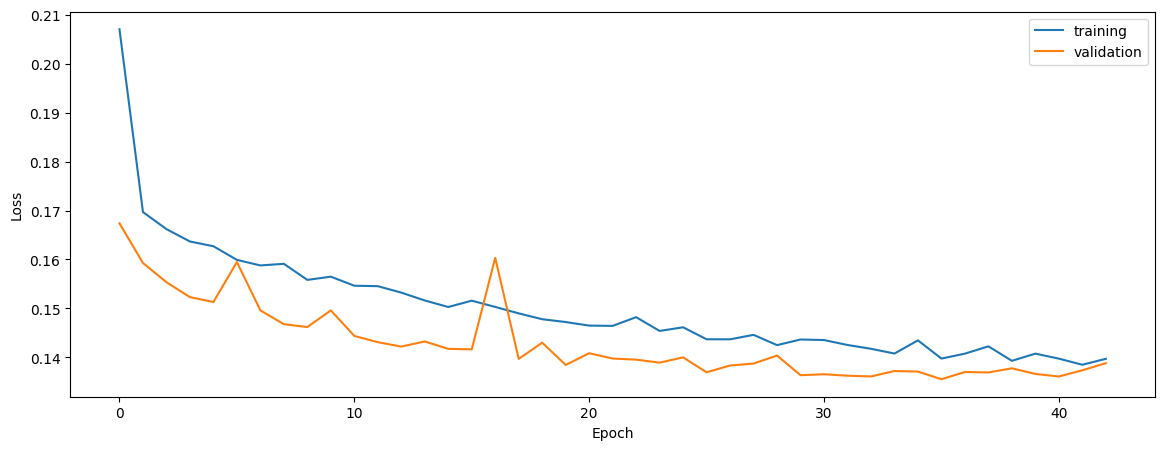

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6936603543995741
0.6841248924268503
0.6500807120108197


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.693173303015426
0.680382880404885
0.6491377676710252


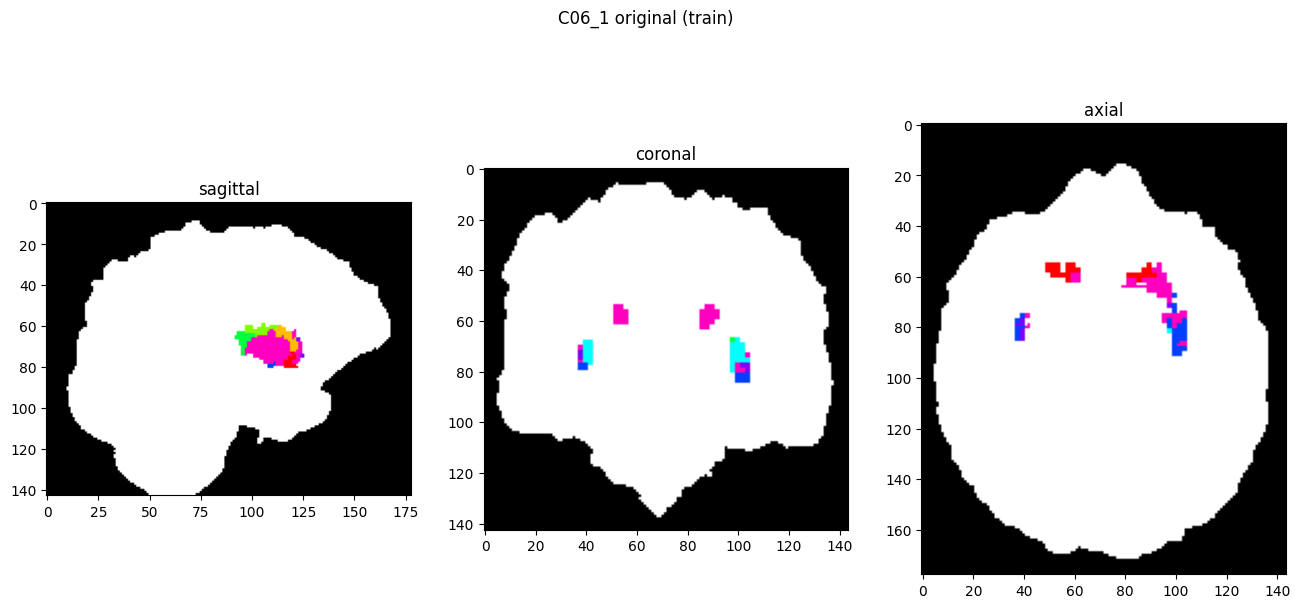

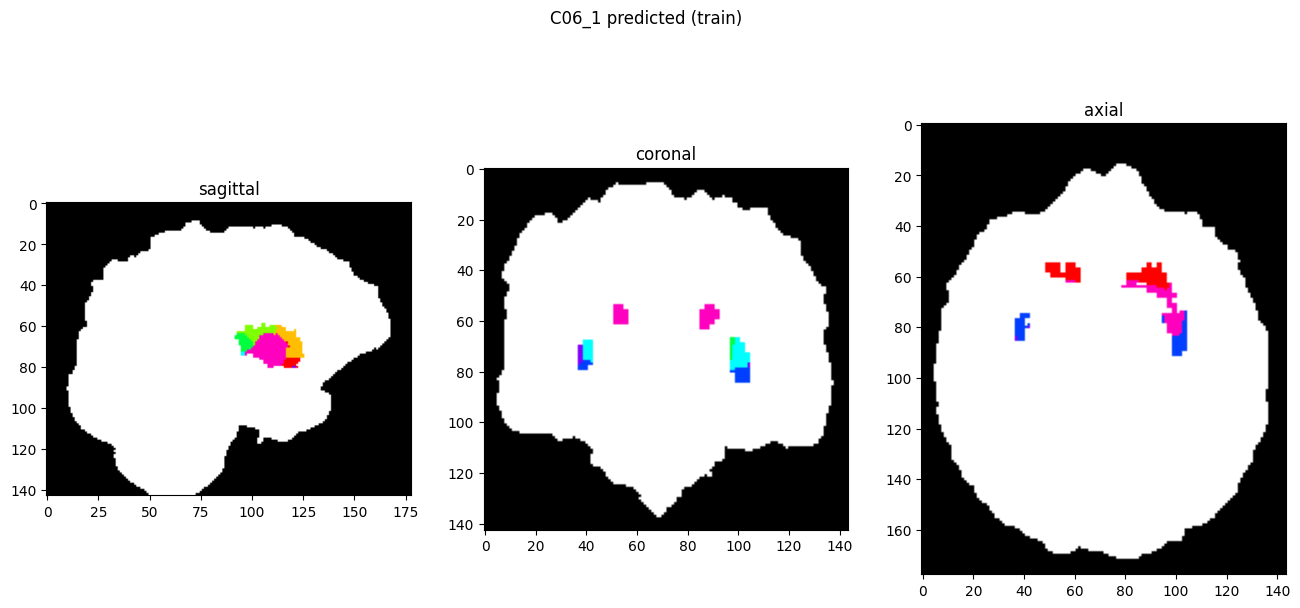

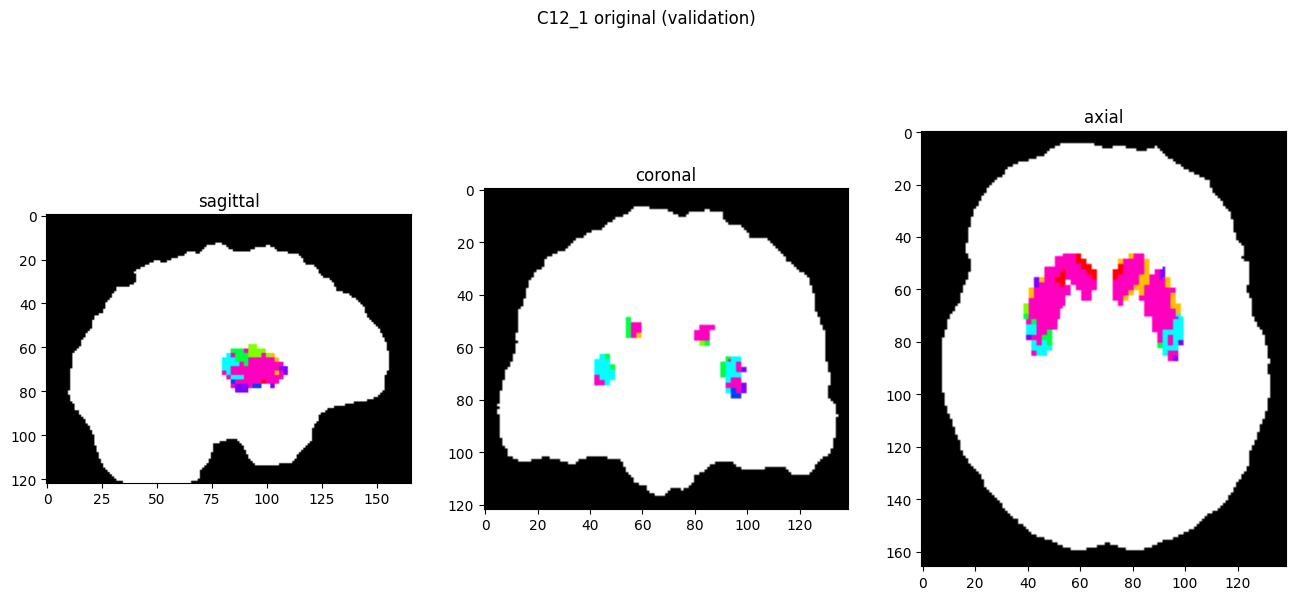

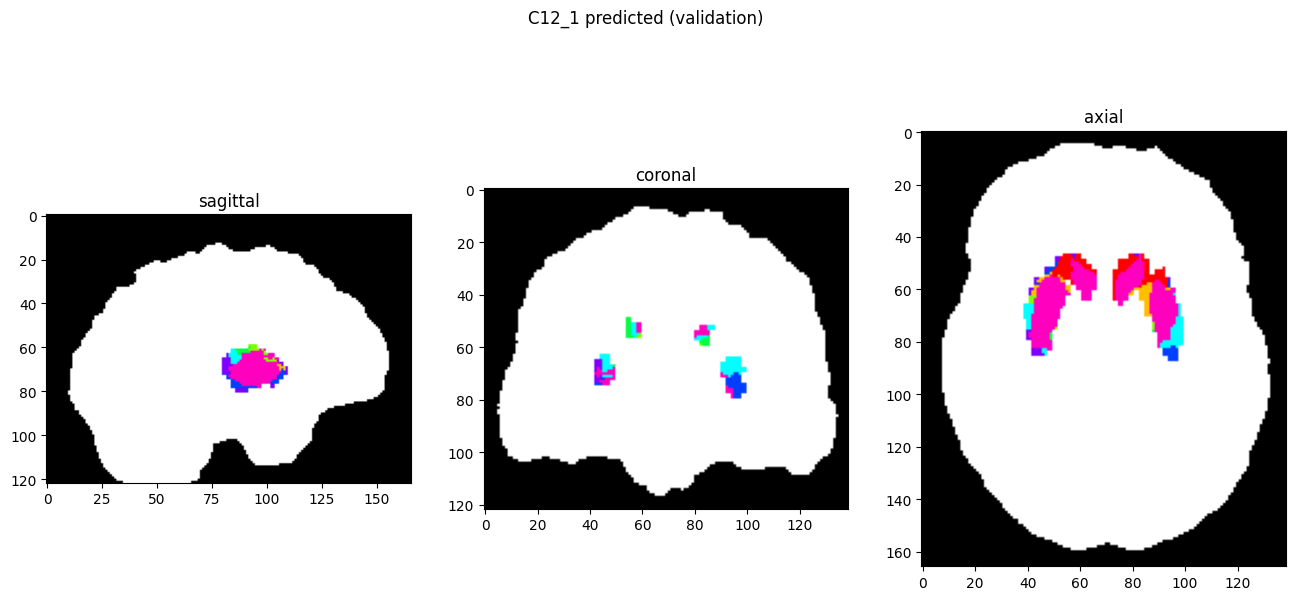

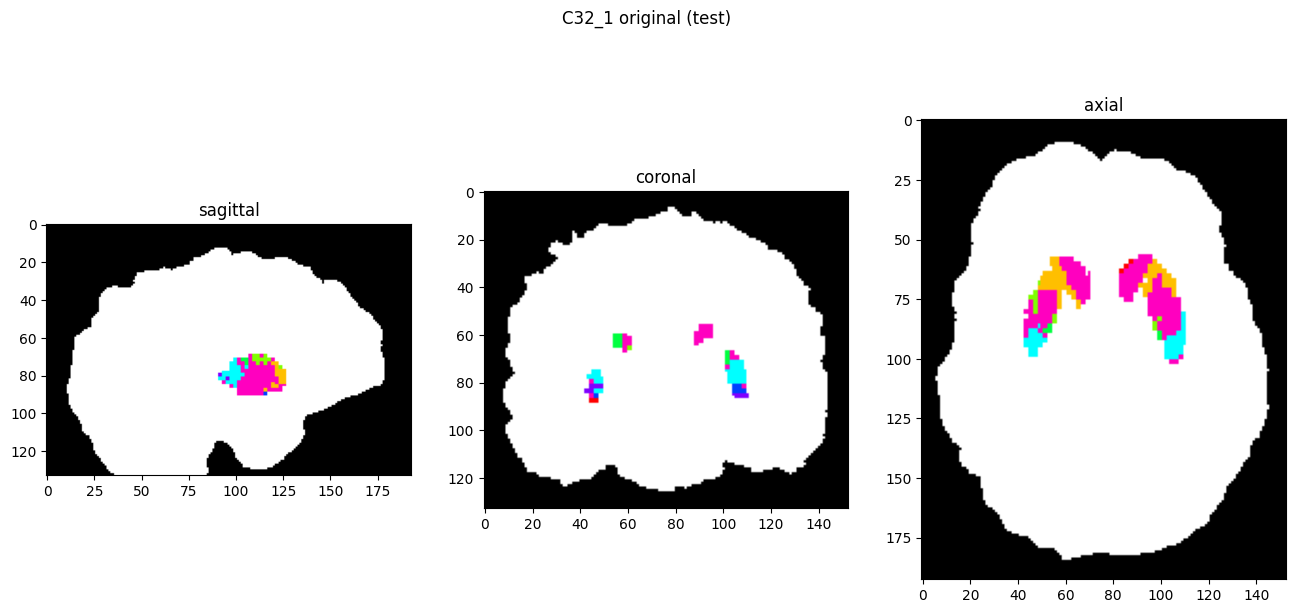

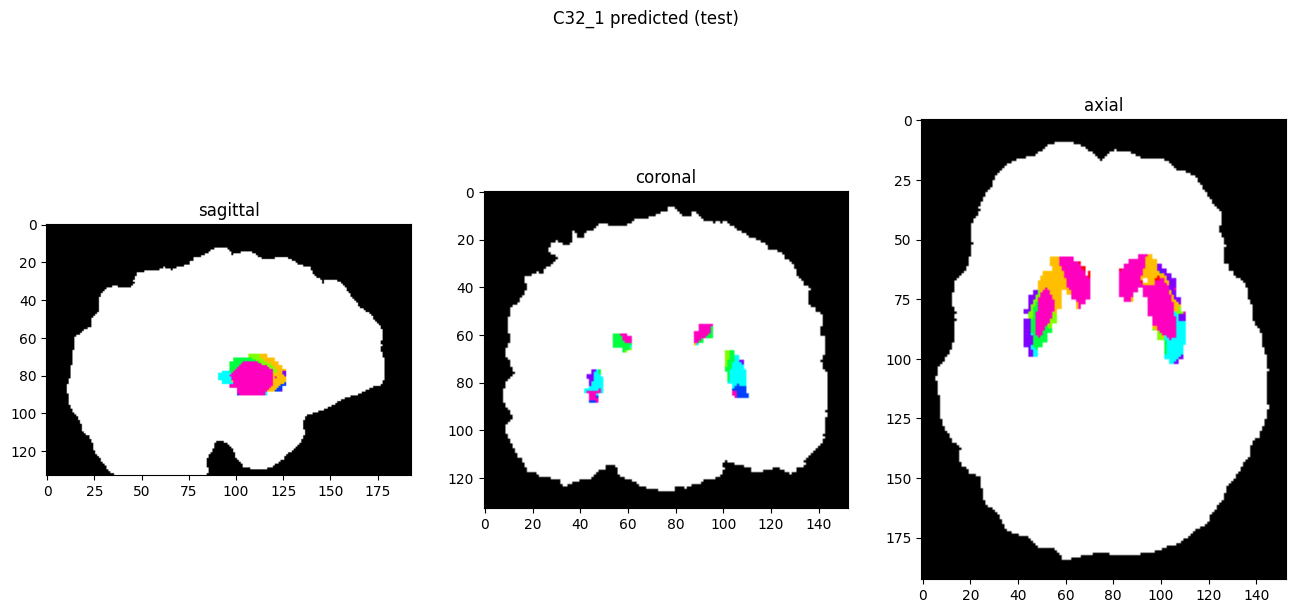

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)